# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977

#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_TRAIN_AE = False #  True
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = False # False

EPOCHS_AE = 30#30
PATIENCE_AE = 0#10
LIST_UNITS_AE = [512]
LIST_UNITS_ENC_AE = [32]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 30#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [512]
LIST_DROPOUT_PRED = [0.5]

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78194/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
93881  1700695500000   2059.15   2061.46  2058.47    2060.36   1431.2804   
93882  1700695800000   2060.35   2066.30  2059.19    2065.02   1306.2176   
93883  1700696100000   2065.01   2065.87  2064.16    2065.44    768.8257   
93884  1700696400000   2065.44   2066.58  2065.15    2065.15    533.2508   
93885  1700696700000   2065.16   2067.69  2064.62    2064.89    693.2496   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1742.347452       1741.894136   
1      2023-01-01 00:05:00       1742.347452       1741.894136   
2      2023-01-01 00:10:00       1742.347452       1741.894136   
3      2023-01-01 00:15:00       1742.347452       1741.894136   
4      2023-01-01 00:20:00       1742.347452       1741.894136   
...                    ...               ...               ...   
93881  2023-11-22 23:25:00       2076.605000       2059.135000   
93882  2023-11-22 23:30:00       2076.605000       2059.135000   
93883  2023-11-22 23:35:00       2078.370000       2060.900000   
93884  2023-11-22 23:40:00       2078.600000       2061.130000   
93885  2023-11-22 23:45:00       2078.600000       2061.870000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
93881         2075.23  ...   NaN         NaN            NaN           NaN   
93882         2075.23  ...   NaN         NaN            NaN           NaN   
93883         2075.23  ...   NaN         NaN            NaN           NaN   
93884         2072.68  ...   NaN         NaN            NaN           NaN   
93885         2072.68  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
93881               NaN         0.0               NaN         0.0      0.0   
93882               NaN         0.0               NaN         0.0      0.0   
93883               NaN         0.0               NaN         0.0      0.0   
93884               NaN         0.0               NaN         0.0      0.0   
93885               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
93881   NaN  
93882   NaN  
93883   NaN  
93884   NaN  
93885   NaN  

[93886 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH        1
vwap_z_score_BTC        1
ichi_tenkan_ETH         8
ichi_tenkan_BTC         8
rsi_h_ETH              13
                    ...  
Actual              93846
Event               93846
Country             93846
keep                93846
date                93846
Length: 65, dtype: int64

on 93886 samples


#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
93881  1700695500000   2059.15   2061.46  2058.47    2060.36   1431.2804   
93882  1700695800000   2060.35   2066.30  2059.19    2065.02   1306.2176   
93883  1700696100000   2065.01   2065.87  2064.16    2065.44    768.8257   
93884  1700696400000   2065.44   2066.58  2065.15    2065.15    533.2508   
93885  1700696700000   2065.16   2067.69  2064.62    2064.89    693.2496   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1742.347452       1741.894136   
1      2023-01-01 00:05:00       1742.347452       1741.894136   
2      2023-01-01 00:10:00       1742.347452       1741.894136   
3      2023-01-01 00:15:00       1742.347452       1741.894136   
4      2023-01-01 00:20:00       1742.347452       1741.894136   
...                    ...               ...               ...   
93881  2023-11-22 23:25:00       2076.605000       2059.135000   
93882  2023-11-22 23:30:00       2076.605000       2059.135000   
93883  2023-11-22 23:35:00       2078.370000       2060.900000   
93884  2023-11-22 23:40:00       2078.600000       2061.130000   
93885  2023-11-22 23:45:00       2078.600000       2061.870000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...   1.0         0.0            0.0           0.0   
1             1194.71  ...   1.0         0.0            0.0           0.0   
2             1194.71  ...   1.0         0.0            0.0           0.0   
3             1194.71  ...   1.0         0.0            0.0           0.0   
4             1194.71  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
93881         2075.23  ...   NaN         NaN            NaN           NaN   
93882         2075.23  ...   NaN         NaN            NaN           NaN   
93883         2075.23  ...   NaN         NaN            NaN           NaN   
93884         2072.68  ...   NaN         NaN            NaN           NaN   
93885         2072.68  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
93881               NaN         0.0               NaN         0.0      0.0   
93882               NaN         0.0               NaN         0.0      0.0   
93883               NaN         0.0               NaN         0.0      0.0   
93884               NaN         0.0               NaN         0.0      0.0   
93885               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
93881                  NaN  
93882                  NaN  
93883                  NaN  
93884                  NaN  
93885                  NaN  

[93886 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       2145
delta_event_real    2145
delta_event_pred    2145
Previous_num        2145
Actual_num          2145
Event               2145
Date                2145
Previous            2145
Consensus           2145
Actual              2145
Country             2145
Time (ET)           2145
keep                2145
date                2145
dtype: int64

on 93886 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
93881   2059.15   2061.46  2058.47    2060.36   1431.2804   
93882   2060.35   2066.30  2059.19    2065.02   1306.2176   
93883   2065.01   2065.87  2064.16    2065.44    768.8257   
93884   2065.44   2066.58  2065.15    2065.15    533.2508   
93885   2065.16   2067.69  2064.62    2064.89    693.2496   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1742.347452       1741.894136   
1      2023-01-01 00:05:00       1742.347452       1741.894136   
2      2023-01-01 00:10:00       1742.347452       1741.894136   
3      2023-01-01 00:15:00       1742.347452       1741.894136   
4      2023-01-01 00:20:00       1742.347452       1741.894136   
...                    ...               ...               ...   
93881  2023-11-22 23:25:00       2076.605000       2059.135000   
93882  2023-11-22 23:30:00       2076.605000       2059.135000   
93883  2023-11-22 23:35:00       2078.370000       2060.900000   
93884  2023-11-22 23:40:00       2078.600000       2061.130000   
93885  2023-11-22 23:45:00       2078.600000       2061.870000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0             1194.71         1194.710  ...  1196.096667  1196.096667   
1             1194.71         1194.710  ...  1195.801420  1195.801420   
2             1194.71         1194.710  ...  1195.648641  1195.648641   
3             1194.71         1194.710  ...  1195.575250  1195.575250   
4             1194.71         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
93881         2075.23         2064.050  ...  1999.756004  1833.150562   
93882         2075.23         2063.400  ...  1999.776658  1833.173778   
93883         2075.23         2063.400  ...  1999.792146  1833.191008   
93884         2072.68         2063.105  ...  1999.804236  1833.203408   
93885         2072.68         2062.845  ...  1999.824664  1833.219184   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
93881  1763.714579  1928.349750   1740.090532          1.891544  0.155443   
93882  1763.727541  1928.426746   1740.093996          1.919019  0.157348   
93883  1763.735005  1928.488025   1740.096045          1.921460  0.157518   
93884  1763.740058  1928.519728   1740.097469          1.919712  0.157399   
93885  1763.746872  1928.550548   1740.099320          1.918139  0.157292   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.204598e+08      481017.0       18.252589  
1      1.204598e+08      481017.0       18.252589  
2      1.204598e+08      481017.0       18.252589  
3      1.204598e+08      481017.0       18.252589  
4      1.204598e+08      481017.0       18.252589  
...             ...           ...             ...  
93881  1.202510e+08      454804.0       16.730457  
93882  1.202510e+08      454804.0       16.730457  
93883  1.202510e+08      454804.0       16.730457  
93884  1.202510e+08      454804.0       16.730457  
93885  1.202510e+08      454804.0       16.730457  

[93886 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.91  3823.179932  103.494003
1      3.91  3823.179932  103.494003
2      3.91  3823.179932  103.494003
3      3.91  3823.179932  103.494003
4      3.91  3823.179932  103.494003
...     ...          ...         ...
93881  4.44  4556.620117  103.886002
93882  4.44  4556.620117  103.886002
93883  4.44  4556.620117  103.886002
93884  4.44  4556.620117  103.886002
93885  4.44  4556.620117  103.886002

[93886 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

93886

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

93417

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
93881  1700695500000   2059.15   2061.46  2058.47    2060.36   1431.2804   
93882  1700695800000   2060.35   2066.30  2059.19    2065.02   1306.2176   
93883  1700696100000   2065.01   2065.87  2064.16    2065.44    768.8257   
93884  1700696400000   2065.44   2066.58  2065.15    2065.15    533.2508   
93885  1700696700000   2065.16   2067.69  2064.62    2064.89    693.2496   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1742.347452       1741.894136   
1      2023-01-01 00:05:00       1742.347452       1741.894136   
2      2023-01-01 00:10:00       1742.347452       1741.894136   
3      2023-01-01 00:15:00       1742.347452       1741.894136   
4      2023-01-01 00:20:00       1742.347452       1741.894136   
...                    ...               ...               ...   
93881  2023-11-22 23:25:00       2076.605000       2059.135000   
93882  2023-11-22 23:30:00       2076.605000       2059.135000   
93883  2023-11-22 23:35:00       2078.370000       2060.900000   
93884  2023-11-22 23:40:00       2078.600000       2061.130000   
93885  2023-11-22 23:45:00       2078.600000       2061.870000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
93881         2075.23  ...         NaN            NaN           NaN   
93882         2075.23  ...         NaN            NaN           NaN   
93883         2075.23  ...         NaN            NaN           NaN   
93884         2072.68  ...         NaN            NaN           NaN   
93885         2072.68  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
93881               NaN         0.0               NaN         0.0      0.0   
93882               NaN         0.0               NaN         0.0      0.0   
93883               NaN         0.0               NaN         0.0      0.0   
93884               NaN         0.0               NaN         0.0      0.0   
93885               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
93881                  NaN  False  
93882                  NaN  False  
93883                  NaN  False  
93884                  NaN  False  
93885                  NaN  False  

[93886 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
93413  1700555100000   2009.10   2010.03  2008.39    2009.83    956.5865   
93414  1700555400000   2009.82   2009.83  2006.77    2007.76    892.2091   
93415  1700555700000   2007.76   2008.96  2007.72    2007.95    447.9291   
93416  1700556000000   2007.95   2009.33  2007.40    2008.34    928.7514   
93417  1700556300000   2008.34   2009.15  2004.95    2009.10   4123.4348   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1742.347452       1741.894136   
1      2023-01-01 00:05:00       1742.347452       1741.894136   
2      2023-01-01 00:10:00       1742.347452       1741.894136   
3      2023-01-01 00:15:00       1742.347452       1741.894136   
4      2023-01-01 00:20:00       1742.347452       1741.894136   
...                    ...               ...               ...   
93413  2023-11-21 08:25:00       2014.202500       2020.045000   
93414  2023-11-21 08:30:00       2014.377500       2019.405000   
93415  2023-11-21 08:35:00       2014.565000       2019.405000   
93416  2023-11-21 08:40:00       2014.765000       2019.405000   
93417  2023-11-21 08:45:00       2014.950000       2019.405000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
93413        2010.490  ...         NaN            NaN           NaN   
93414        2010.490  ...         NaN            NaN           NaN   
93415        2010.490  ...         NaN            NaN           NaN   
93416        2010.490  ...         NaN            NaN           NaN   
93417        2010.365  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
93413               NaN         0.0               NaN         0.0      0.0   
93414               NaN         0.0               NaN         0.0      0.0   
93415               NaN         0.0               NaN         0.0      0.0   
93416               NaN         0.0               NaN         0.0      0.0   
93417               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
93413                  NaN   True  
93414                  NaN   True  
93415                  NaN   True  
93416                  NaN   True  
93417                  NaN   True  

[93418 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
93418  1700556600000   2009.10   2011.25  2008.09    2010.00    896.6276   
93419  1700556900000   2010.01   2013.62  2010.00    2012.13    925.4442   
93420  1700557200000   2012.12   2013.96  2011.86    2013.28    773.1907   
93421  1700557500000   2013.27   2013.28  2010.87    2013.19    663.5271   
93422  1700557800000   2013.20   2013.67  2011.88    2012.90    702.0594   
...              ...       ...       ...      ...        ...         ...   
93881  1700695500000   2059.15   2061.46  2058.47    2060.36   1431.2804   
93882  1700695800000   2060.35   2066.30  2059.19    2065.02   1306.2176   
93883  1700696100000   2065.01   2065.87  2064.16    2065.44    768.8257   
93884  1700696400000   2065.44   2066.58  2065.15    2065.15    533.2508   
93885  1700696700000   2065.16   2067.69  2064.62    2064.89    693.2496   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
93418  2023-11-21 08:50:00         2014.8800          2017.065   
93419  2023-11-21 08:55:00         2014.9925          2016.125   
93420  2023-11-21 09:00:00         2015.2425          2016.125   
93421  2023-11-21 09:05:00         2015.4900          2016.125   
93422  2023-11-21 09:10:00         2015.2500          2014.090   
...                    ...               ...               ...   
93881  2023-11-22 23:25:00         2076.6050          2059.135   
93882  2023-11-22 23:30:00         2076.6050          2059.135   
93883  2023-11-22 23:35:00         2078.3700          2060.900   
93884  2023-11-22 23:40:00         2078.6000          2061.130   
93885  2023-11-22 23:45:00         2078.6000          2061.870   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
93418        2009.540  ...         NaN            NaN           NaN   
93419        2009.055  ...         NaN            NaN           NaN   
93420        2008.770  ...         NaN            NaN           NaN   
93421        2008.400  ...         NaN            NaN           NaN   
93422        2007.980  ...         NaN            NaN           NaN   
...               ...  ...         ...            ...           ...   
93881        2075.230  ...         NaN            NaN           NaN   
93882        2075.230  ...         NaN            NaN           NaN   
93883        2075.230  ...         NaN            NaN           NaN   
93884        2072.680  ...         NaN            NaN           NaN   
93885        2072.680  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
93418               NaN         0.0               NaN         0.0      0.0   
93419               NaN         0.0               NaN         0.0      0.0   
93420               NaN         0.0               NaN         0.0      0.0   
93421               NaN         0.0               NaN         0.0      0.0   
93422               NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
93881               NaN         0.0               NaN         0.0      0.0   
93882               NaN         0.0               NaN         0.0      0.0   
93883               NaN         0.0               NaN         0.0      0.0   
93884               NaN         0.0               NaN         0.0      0.0   
93885               NaN         0.0               NaN         0.0      0.0   

       date  train  
93418   NaN  False  
93419   NaN  False  
93420   NaN  False  
93421   NaN  False  
93422   NaN  False  
...     ...    ...  
93881   NaN  False  
93882   NaN  False  
93883   NaN  False  
93884   NaN  False  
93885   NaN  False  

[468 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(93331, 72, 102) (93331, 15)
(381, 72, 102) (381, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([1.00063803, 1.00105176, 1.00098696, 1.00136081, 1.00011963,
       0.99880867, 0.99890338, 1.00020936, 1.00033397, 1.00088727,
       1.00147047, 1.00182937, 1.00079754, 1.00089225, 1.00108665])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99928834, 0.99839255, 0.99902956, ..., 0.99986065, 1.00021897,
        0.99918881],
       [0.99910357, 0.99974103, 1.00015439, ..., 1.00093129, 0.9999004 ,
        0.99999502],
       [1.00063803, 1.00105176, 1.00098696, ..., 1.00079754, 1.00089225,
        1.00108665]])

In [39]:
seq_y

array([1.00063803, 1.00105176, 1.00098696, 1.00136081, 1.00011963,
       0.99880867, 0.99890338, 1.00020936, 1.00033397, 1.00088727,
       1.00147047, 1.00182937, 1.00079754, 1.00089225, 1.00108665])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99928834, 0.99839255, 0.99902956, ..., 0.99986065, 1.00021897,
        0.99918881],
       [0.99910357, 0.99974103, 1.00015439, ..., 1.00093129, 0.9999004 ,
        0.99999502],
       [1.00063803, 1.00105176, 1.00098696, ..., 1.00079754, 1.00089225,
        1.00108665]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(93331, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(93331, 72, 102) (93331, 15)
(381, 72, 102) (381, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99928834, 0.99839255, 0.99902956, ..., 0.99986065, 1.00021897,
        0.99918881],
       [0.99910357, 0.99974103, 1.00015439, ..., 1.00093129, 0.9999004 ,
        0.99999502],
       [1.00063803, 1.00105176, 1.00098696, ..., 1.00079754, 1.00089225,
        1.00108665]])

In [47]:
np.mean(y_train_sca)

-6.995738828822167e-05

In [48]:
np.std(y_train_sca)

0.9999271704596535

In [49]:
np.mean(y_test_sca)

0.22629343862069656

In [50]:
np.std(y_test_sca)

1.4505489820457664

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1742.347452       1741.894136   
1    1195.38   1196.31   1196.69  1194.90       1742.347452       1741.894136   
2    1194.55   1195.38   1195.81  1194.55       1742.347452       1741.894136   
3    1195.98   1194.55   1195.98  1194.31       1742.347452       1741.894136   
4    1196.06   1195.98   1196.37  1195.97       1742.347452       1741.894136   
5    1196.61   1196.06   1196.70  1196.06       1742.347452       1741.894136   
6    1194.36   1196.62   1196.62  1193.72       1742.347452       1741.894136   
7    1194.22   1194.37   1194.43  1192.72       1742.347452       1741.894136   
8    1193.64   1194.22   1194.22  1193.02       1742.347452       1741.894136   
9    1194.64   1193.64   1195.06  1193.63       1742.347452       1741.894136   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1744.010949   
1         1194.71          1194.71           1744.010949   
2         1194.71          1194.71           1744.010949   
3         1194.71          1194.71           1744.010949   
4         1194.71          1194.71           1744.010949   
5         1194.71          1194.71           1744.010949   
6         1194.71          1194.71           1744.010949   
7         1194.71          1194.71           1744.010949   
8         1194.71          1194.71           1744.010949   
9         1194.71          1194.71           1744.010949   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1737.254309  ...  1.204598e+08       1.0       0.0      0.62349   
1           1737.254309  ...  1.204598e+08       1.0       0.0      0.62349   
2           1737.254309  ...  1.204598e+08       1.0       0.0      0.62349   
3           1737.254309  ...  1.204598e+08       1.0       0.0      0.62349   
4           1737.254309  ...  1.204598e+08       1.0       0.0      0.62349   
5           1737.254309  ...  1.204598e+08       1.0       0.0      0.62349   
6           1737.254309  ...  1.204598e+08       1.0       0.0      0.62349   
7           1737.254309  ...  1.204598e+08       1.0       0.0      0.62349   
8           1737.254309  ...  1.204598e+08       1.0       0.0      0.62349   
9           1737.254309  ...  1.204598e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(6719832, 102)

In [57]:
X_train[:,-1,:].shape

(93331, 102)

In [58]:
X_test[:,-1,:].shape

(381, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.019974 -0.005659 -0.059404  0.088117         -0.036416   
1       0.019974 -0.033535 -0.071461  0.060157         -0.069547   
2       0.019974  0.030211 -0.049365  0.096120         -0.063101   
3       0.019974  0.111960  0.020006  0.103105          0.006259   
4       0.019974 -0.059445 -0.069452  0.035168         -0.035857   
...          ...       ...       ...       ...               ...   
93707   0.019974 -0.039721  0.070929  0.013133         -0.855100   
93708   0.019974  0.115707  0.210518  0.033691         -0.750873   
93709   0.019974  0.160457  0.115066  0.115103         -0.643030   
93710   0.019974 -0.003781  0.121950  0.084114         -0.660603   
93711   0.019974  0.196735  0.106061 -0.007315         -0.488476   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.024716       -0.139998        -0.032615   
1             -0.012620       -0.171246        -0.065487   
2             -0.006513       -0.156764        -0.031117   
3              0.055290       -0.071736         0.058285   
4              0.000953       -0.146493        -0.020317   
...                 ...             ...              ...   
93707         -1.076062       -0.086646        -0.065189   
93708         -1.012268        0.002349         0.028298   
93709         -0.917930        0.133957         0.022653   
93710         -0.934503        0.110836        -0.001605   
93711         -0.815640        0.276657         0.172372   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  9.021456              8.386136  ...  0.366084  1.366054   
1                  9.008309              8.373861  ...  0.000057  1.414242   
2                  9.010460              8.375869  ...  0.000057  1.414242   
3                  9.032221              8.396187  ...  0.000057  1.414242   
4                  9.013088              8.378323  ...  0.000057  1.414242   
...                     ...                   ...  ...       ...       ...   
93707             -0.630416             -0.711028  ...  1.224809 -0.707064   
93708             -0.611017             -0.697019  ...  1.224809 -0.707064   
93709             -0.586715             -0.676301  ...  1.224809 -0.707064   
93710             -0.590634             -0.679940  ...  1.224809 -0.707064   
93711             -0.562531             -0.653836  ...  1.224809 -0.707064   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.873679    -1.104383          1.405171          0.256506 -0.049165   
1         0.873679    -1.104383          1.405171          0.256506 -0.049165   
2         0.873679    -1.104383          1.405171          0.256506 -0.049165   
3         0.873679    -1.104383          1.405171          0.256506 -0.049165   
4         0.873679    -1.104383          1.405171          0.256506 -0.049165   
...            ...          ...               ...               ...       ...   
93707    -0.321351     1.383056         -0.125718         -1.438187 -0.049165   
93708    -0.321351     1.383056         -0.125718         -1.438187 -0.049165   
93709    -0.321351     1.383056         -0.125718         -1.438187 -0.049165   
93710    -0.321351     1.383056         -0.125718         -1.438187 -0.049165   
93711    -0.321351     1.383056         -0.125718         -1.438187 -0.049165   

       event_pred  event_real  TRAIN  
0       -0.002253   -0.000751    1.0  
1       -0.002253   -0.000751    1.0  
2       -0.002253   -0.000751    1.0  
3       -0.002253   -0.000751    1.0  
4       -0.002253   -0.000751    1.0  
...           ...         ...    ...  
93707   -0.002253   -0.000751    0.0  
93708   -0.002253   -0.000751    0.0  
93709   -0.002253   -0.000751    0.0  
93710   -0.002253   -0.000751    0.0  
93711   -0.002253   -0.000751    0.0  

[93712 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  9.333100e+04  93331.000000  93331.000000  93331.000000   
mean   1.997364e-02      0.019716      0.019929      0.019701   
std    3.258175e-14      0.172622      0.135096      0.133967   
min    1.997364e-02     -5.747925     -0.072465     -5.691213   
25%    1.997364e-02     -0.045191     -0.055879     -0.008976   
50%    1.997364e-02      0.020250     -0.017253      0.057986   
75%    1.997364e-02      0.083101      0.048377      0.097478   
max    1.997364e-02     11.217127     11.455245      0.115103   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      93331.000000      93331.000000    93331.000000     93331.000000   
mean           0.012192          0.011656        0.018504         0.019453   
std            0.640228          0.690656        0.366975         0.235543   
min           -5.940960         -6.127366       -4.744046        -3.962704   
25%           -0.208787         -0.233343       -0.134082        -0.080167   
50%            0.023814          0.028642        0.030653         0.024317   
75%            0.250495          0.289343        0.185697         0.126502   
max            9.950606         10.176511        6.617855         6.187043   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          93331.000000          93331.000000  ...  93331.000000   
mean              -0.000533             -0.000150  ...      0.000037   
std                0.973464              0.977302  ...      0.999915   
min               -3.649943             -3.109634  ...     -1.414166   
25%               -0.386361             -0.446453  ...     -0.999950   
50%                0.016623             -0.012652  ...      0.000057   
75%                0.323890              0.421701  ...      1.000063   
max                9.050661              8.413404  ...      1.414279   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  93331.000000  93331.000000  93331.000000      93331.000000   
mean       0.000322      0.000226      0.001125         -0.000799   
std        1.000096      0.999976      1.000035          0.999556   
min       -1.414167     -1.279692     -1.377793         -1.390288   
25%       -0.999956     -1.279692     -1.104383         -1.049610   
50%        0.000038     -0.321351      0.002631         -0.049631   
75%        1.000031      0.873679      1.109646          0.994843   
max        1.414242      1.405518      1.383056          1.434078   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      93331.000000  93331.000000  9.333100e+04  9.333100e+04  93331.0  
mean          -0.000975     -0.000013 -5.793937e-07 -1.931308e-07      1.0  
std            1.000467      0.999877  9.998768e-01  9.998768e-01      0.0  
min           -1.445950     -0.049165 -7.008021e+01 -7.007855e+01      1.0  
25%           -1.055932     -0.049165 -2.253141e-03 -7.510454e-04      1.0  
50%           -0.028770     -0.049165 -2.253141e-03 -7.510454e-04      1.0  
75%            0.998392     -0.049165 -2.253141e-03 -7.510454e-04      1.0  
max            1.388410     20.339562  7.007570e+01  7.007705e+01      1.0  

[8 rows x 103 columns]

In [61]:
df[df["TRAIN"] == 0].describe()

Close_ETH    Open_ETH    High_ETH     Low_ETH  ichi_cloud_a_ETH  \
count  3.810000e+02  381.000000  381.000000  381.000000        381.000000   
mean   1.997364e-02    0.006783    0.087699   -0.048629         -0.231511   
std    7.642820e-17    0.243012    0.161187    0.186247          0.857847   
min    1.997364e-02   -1.406587   -0.072465   -1.364646         -1.825650   
25%    1.997364e-02   -0.109848   -0.029956   -0.100464         -0.692261   
50%    1.997364e-02    0.011773    0.049349    0.012944         -0.451861   
75%    1.997364e-02    0.131409    0.156689    0.069592          0.026379   
max    1.997364e-02    0.927096    0.895256    0.115103          2.528112   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count        381.000000      381.000000       381.000000   
mean          -0.295049       -0.096695        -0.018998   
std            0.909702        0.592617         0.360047   
min           -1.867641       -1.428028        -1.149899   
25%           -0.919490       -0.460025        -0.231022   
50%           -0.531395       -0.208652        -0.062091   
75%            0.187592        0.113142         0.182111   
max            2.290689        1.643414         1.464968   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...    hour_cos  \
count            381.000000            381.000000  ...  381.000000   
mean              -0.285930             -0.004670  ...    0.009700   
std                0.205704              0.329648  ...    0.946857   
min               -0.760880             -0.751749  ...   -1.414166   
25%               -0.405896             -0.228862  ...   -0.999950   
50%               -0.308662              0.073442  ...    0.000057   
75%               -0.126611              0.226363  ...    1.000063   
max                0.237565              0.662789  ...    1.414279   

         hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
count  381.000000   381.000000   381.000000        381.000000   
mean    -0.287396     0.026807     1.303401         -0.209850   
std      1.012815     0.543711     0.124395          0.131386   
min     -1.414167    -0.321351     1.109646         -0.414494   
25%     -1.224699    -0.321351     1.109646         -0.414494   
50%     -0.707064    -0.321351     1.383056         -0.125718   
75%      0.707140     0.873679     1.383056         -0.125718   
max      1.414242     0.873679     1.383056         -0.125718   

       day_in_month_sin       day_off    event_pred    event_real  TRAIN  
count        381.000000  3.810000e+02  3.810000e+02  3.810000e+02  381.0  
mean          -1.420241 -4.916527e-02 -2.253141e-03 -7.510454e-04    0.0  
std            0.028026  1.320123e-16  1.476454e-17  1.845567e-18    0.0  
min           -1.438187 -4.916527e-02 -2.253141e-03 -7.510454e-04    0.0  
25%           -1.438187 -4.916527e-02 -2.253141e-03 -7.510454e-04    0.0  
50%           -1.438187 -4.916527e-02 -2.253141e-03 -7.510454e-04    0.0  
75%           -1.376589 -4.916527e-02 -2.253141e-03 -7.510454e-04    0.0  
max           -1.376589 -4.916527e-02 -2.253141e-03 -7.510454e-04    0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

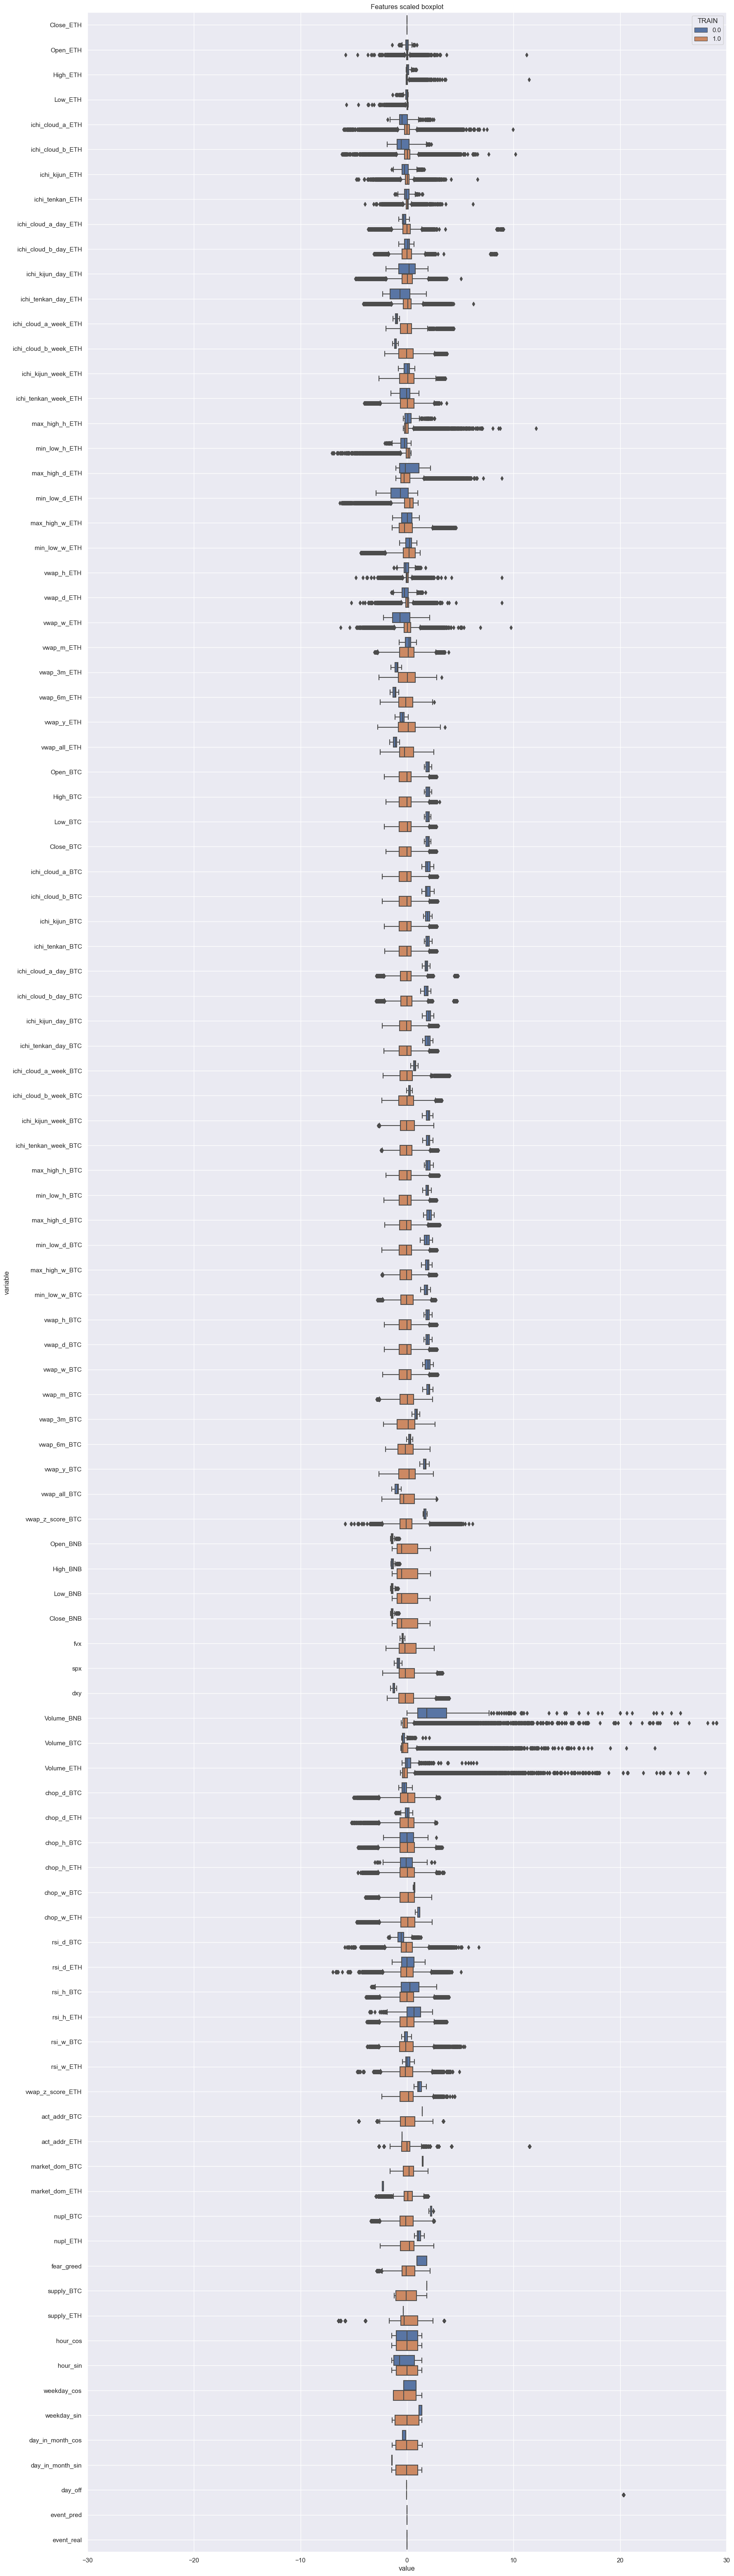

In [62]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<Axes: >

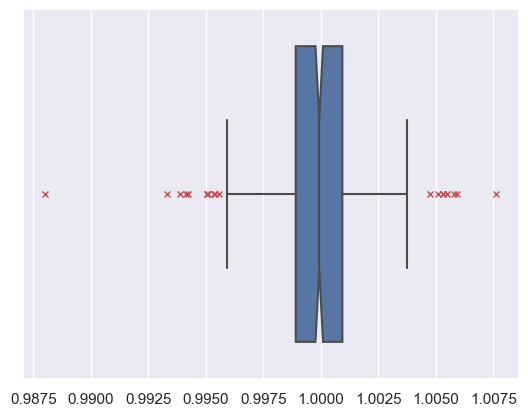

In [63]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


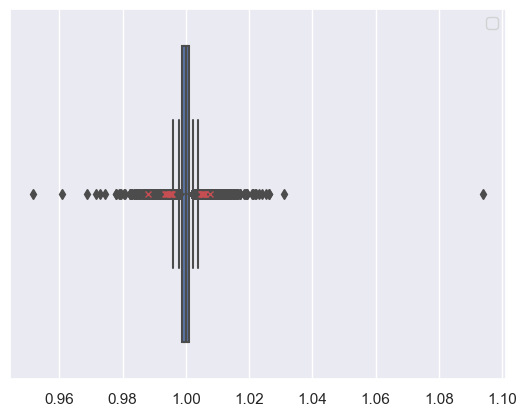

In [64]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

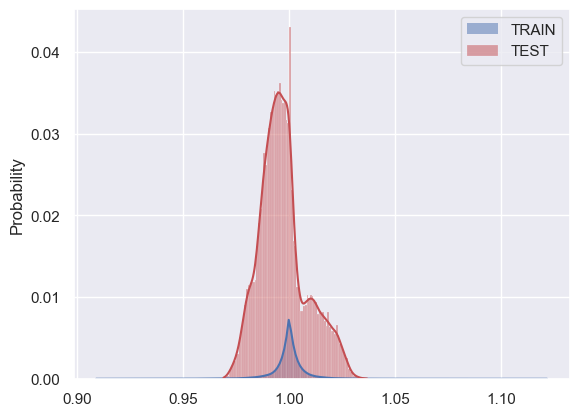

In [65]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [66]:
X_train_sca.shape

(93331, 72, 102)

In [67]:
X_train_sca[:,-1,:].shape

(93331, 102)

In [68]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.10288678],
       [-0.03227297],
       [-0.20539238],
       ...,
       [-0.19281646],
       [-0.23943254],
       [ 0.14769475]])

In [69]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(93331, 103)

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [72]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

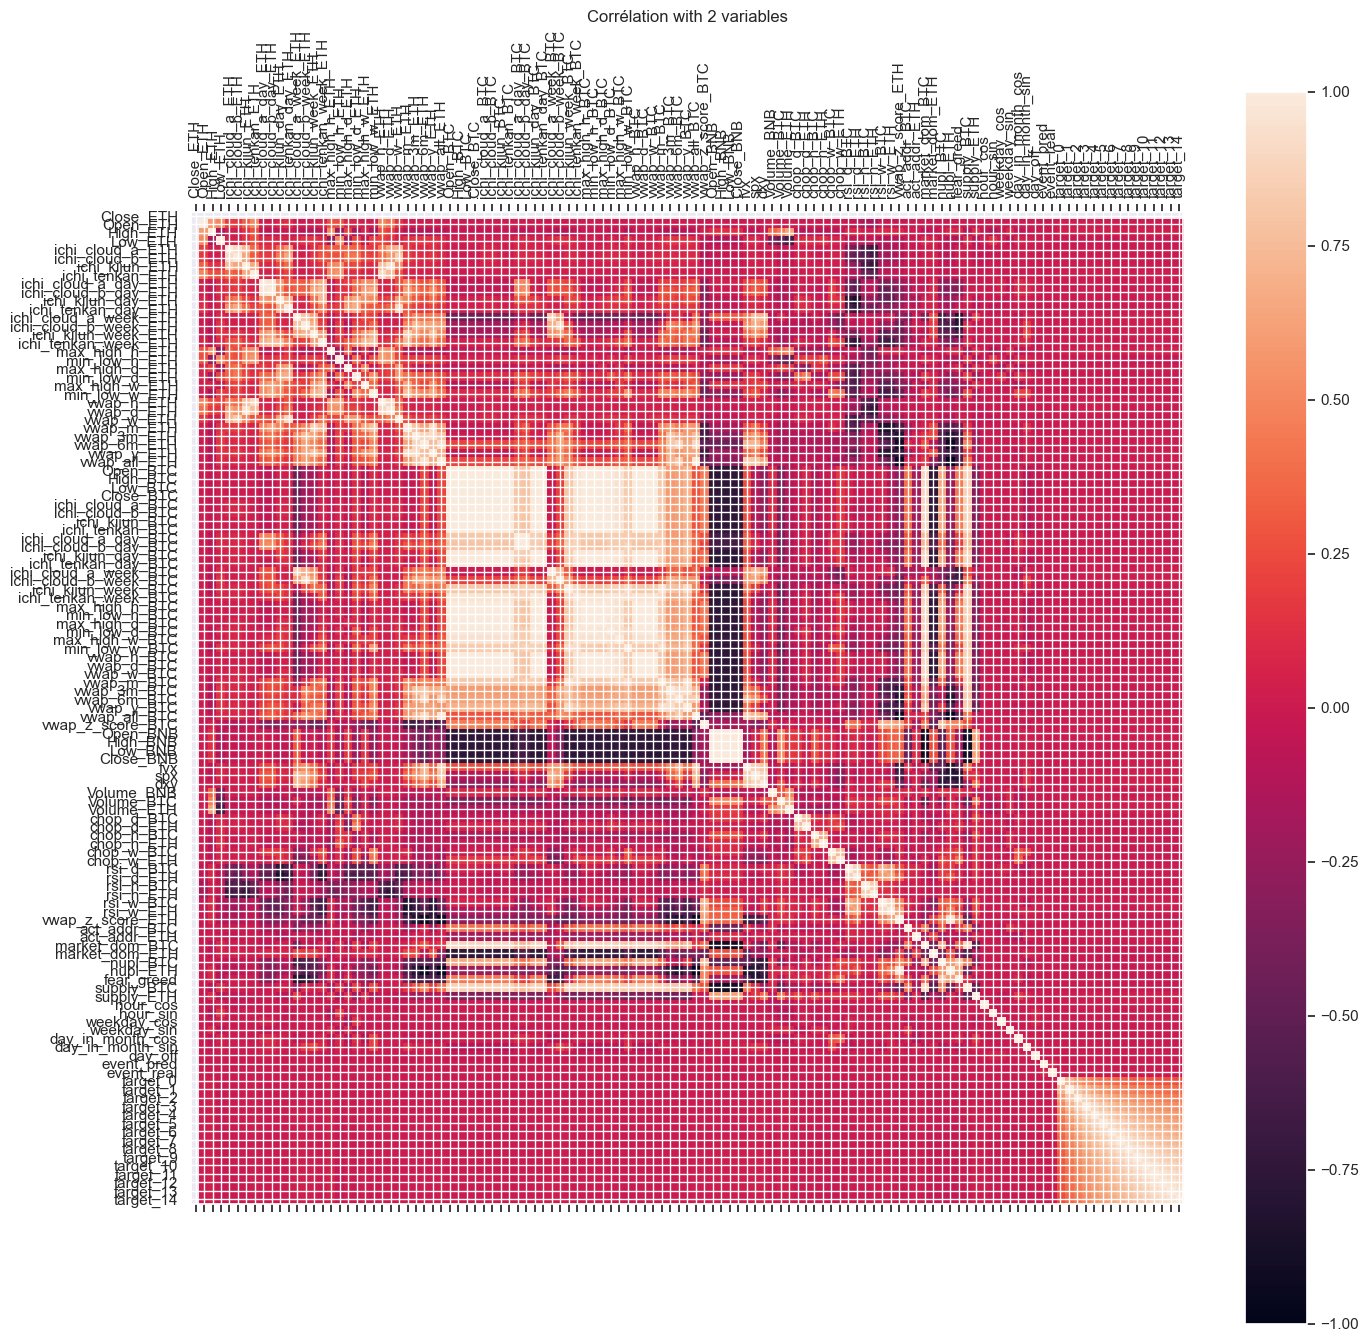

In [73]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


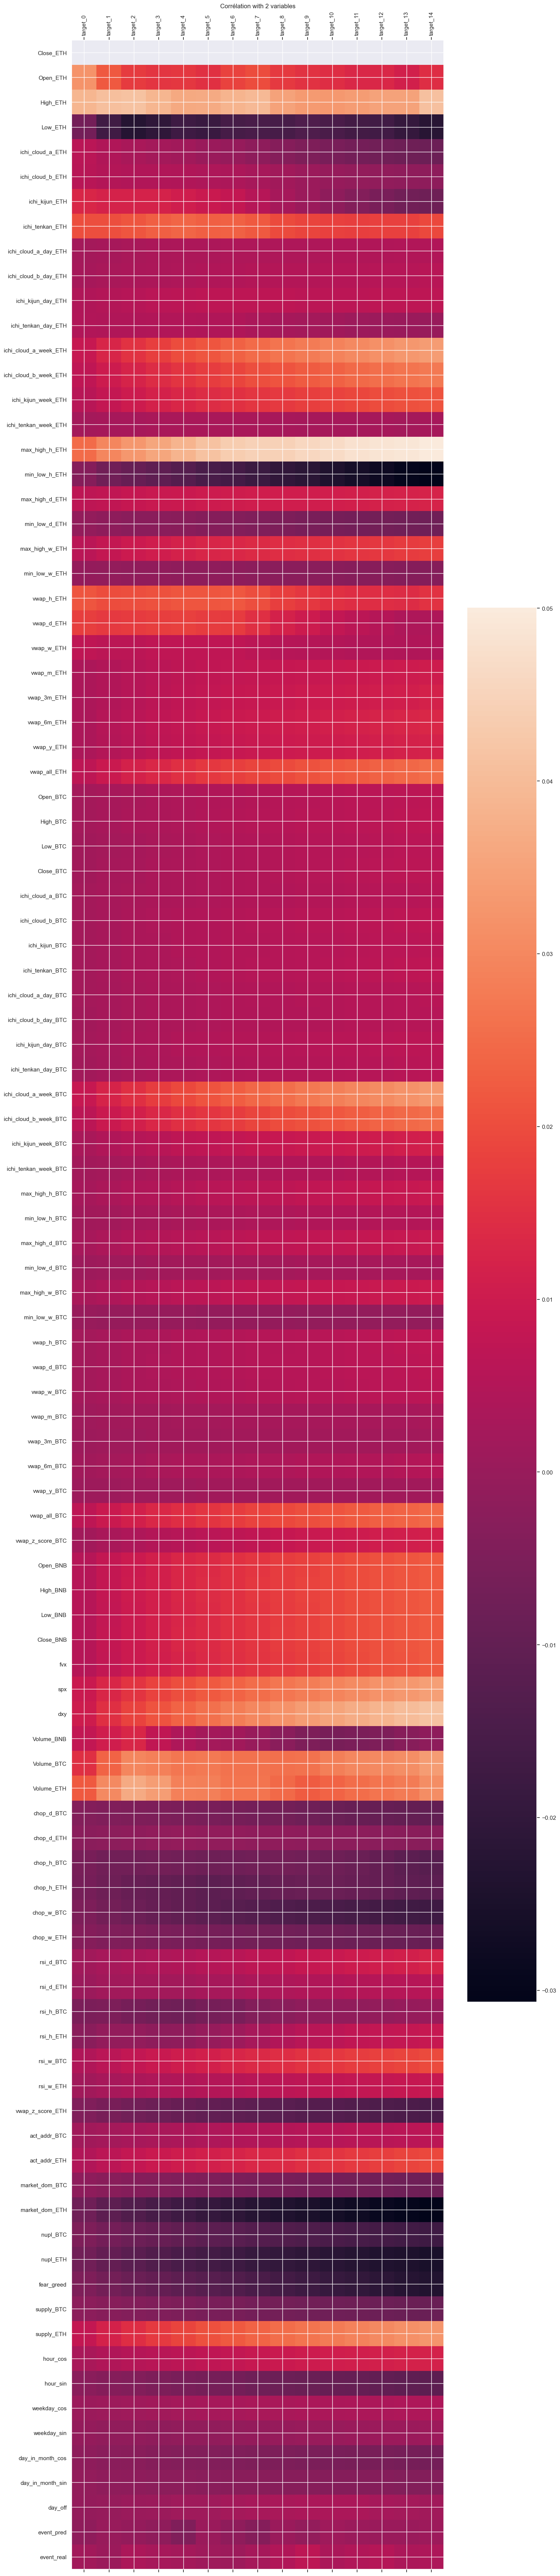

In [74]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


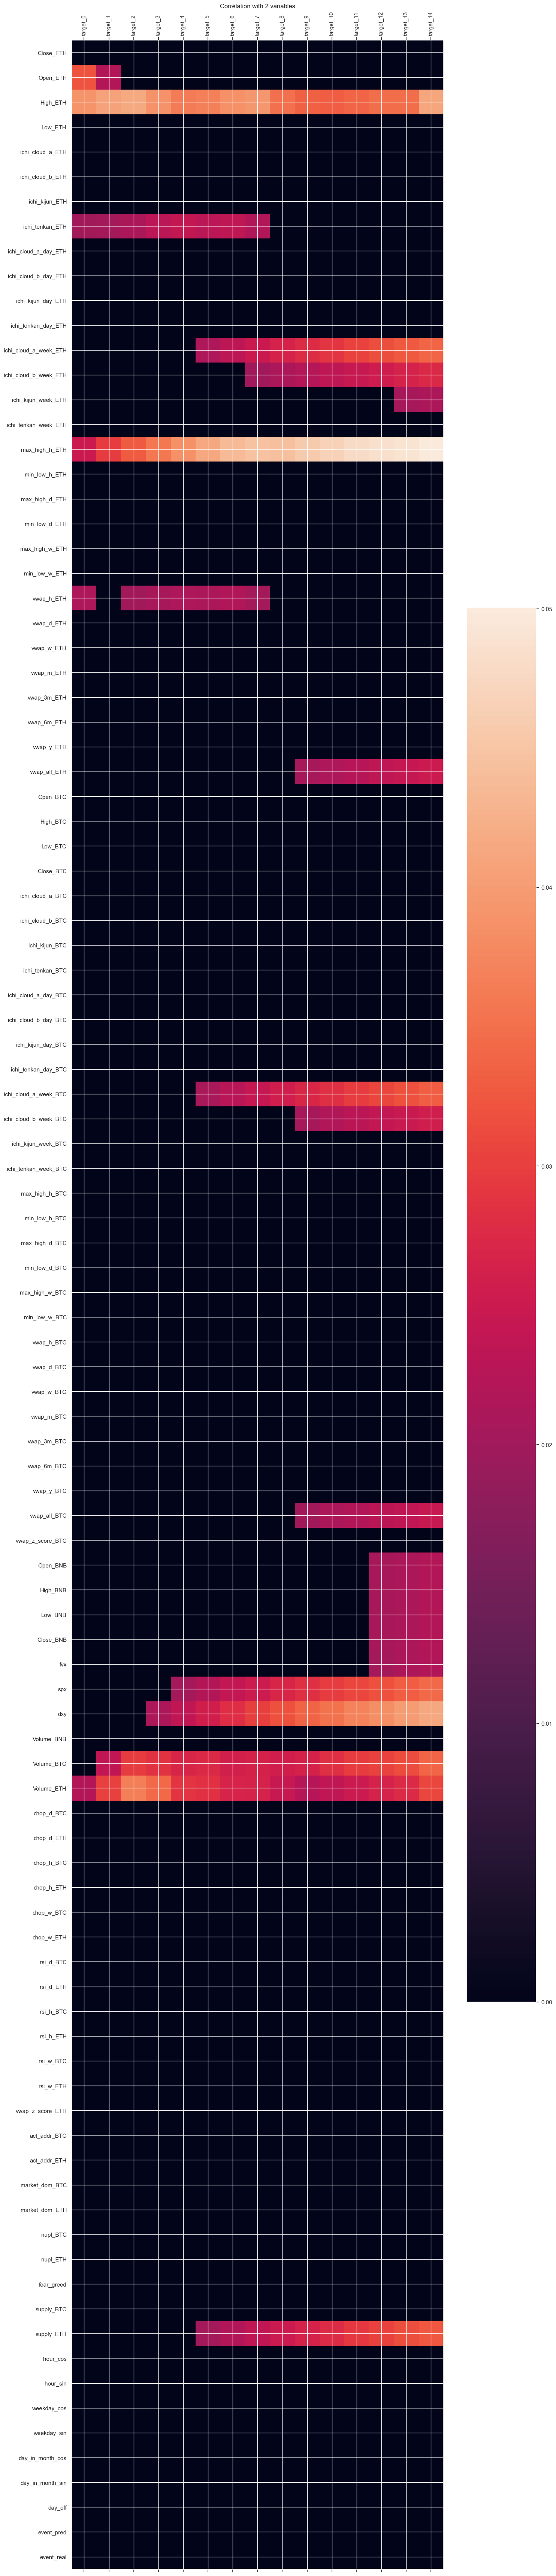

In [75]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [76]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

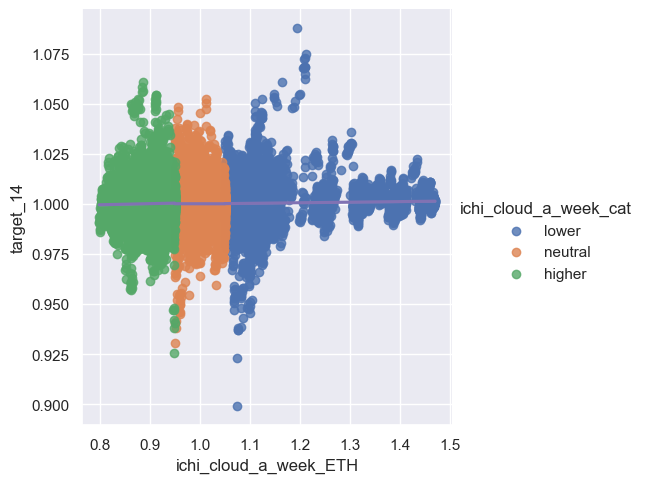

In [77]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

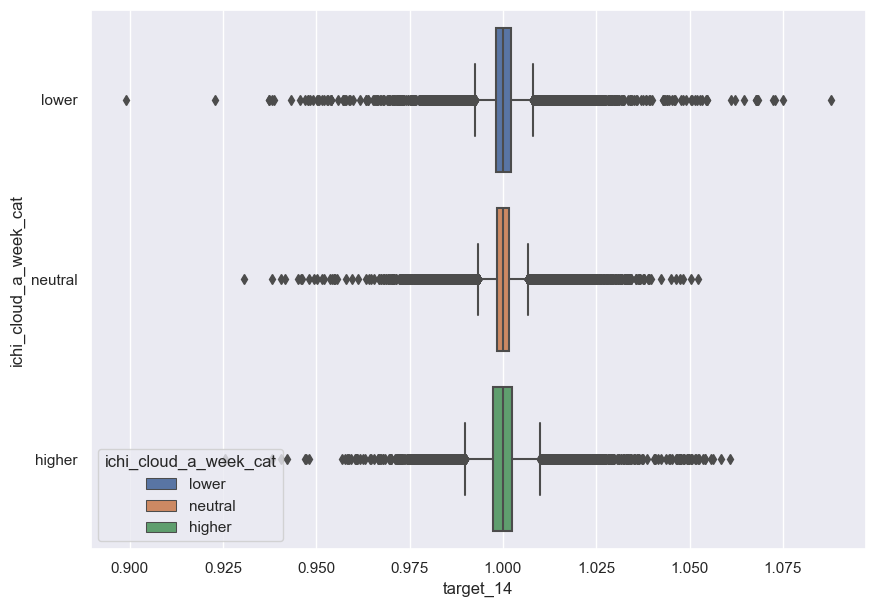

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [79]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


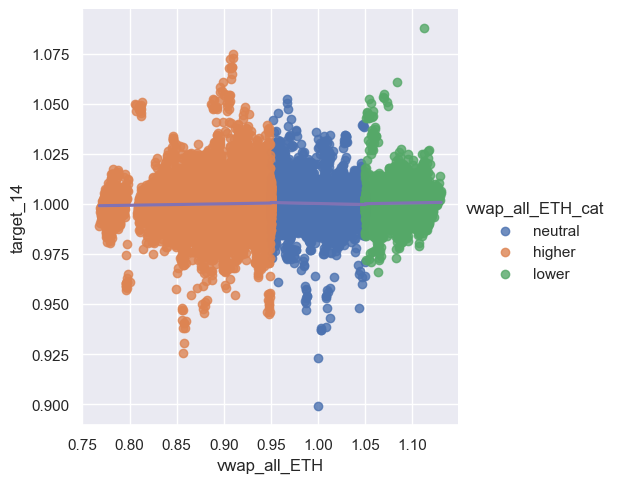

In [80]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

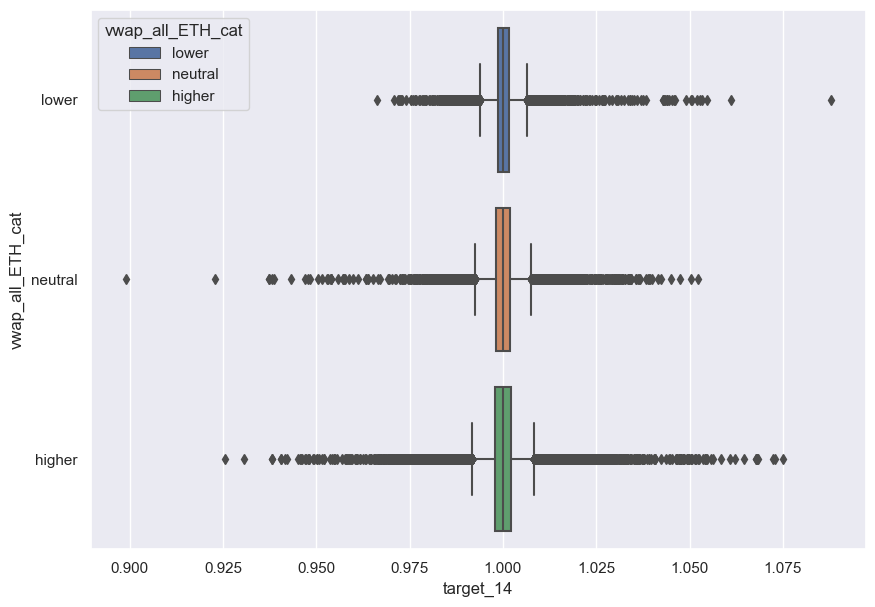

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

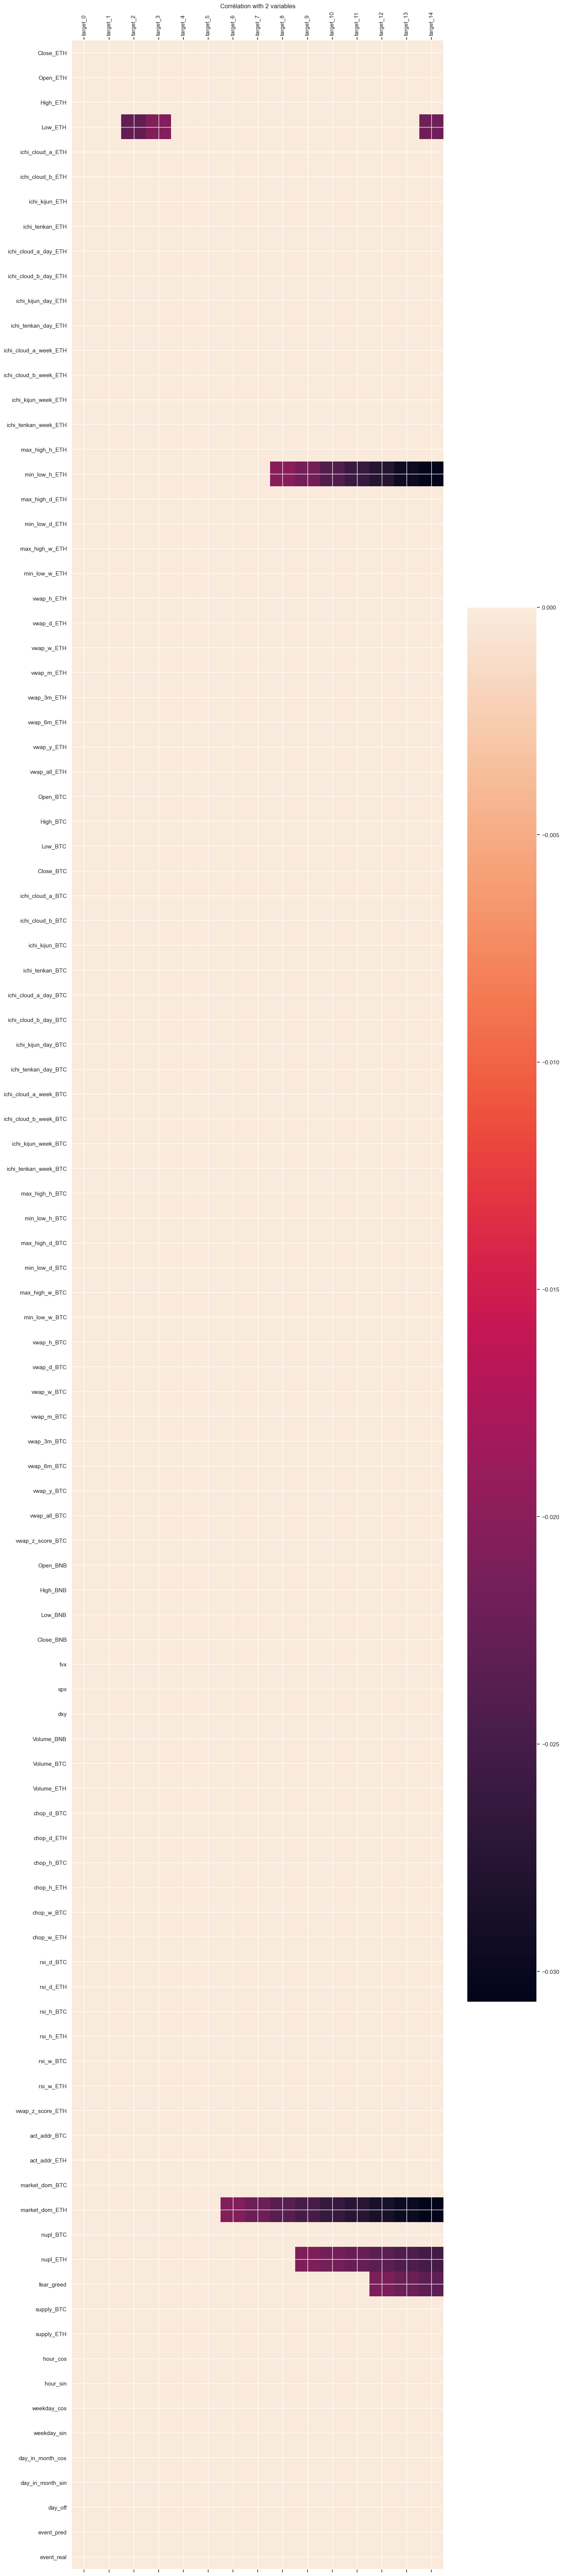

In [82]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

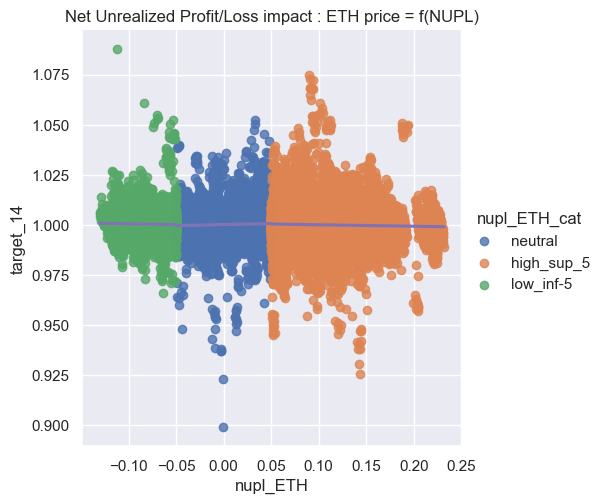

In [83]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

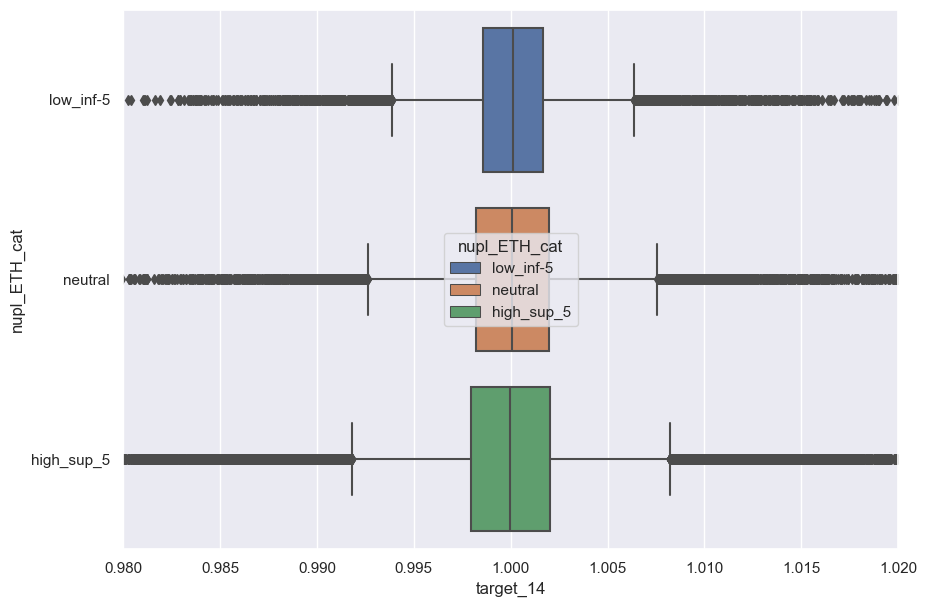

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [85]:
df["target_14"].describe()

count    93331.000000
mean         1.000098
std          0.005402
min          0.899006
25%          0.998119
50%          1.000025
75%          1.001967
max          1.087790
Name: target_14, dtype: float64

In [86]:
df["target_1"].describe()

count    93331.000000
mean         1.000013
std          0.002012
min          0.907143
25%          0.999268
50%          1.000005
75%          1.000756
max          1.053076
Name: target_1, dtype: float64

<Axes: xlabel='target_14'>

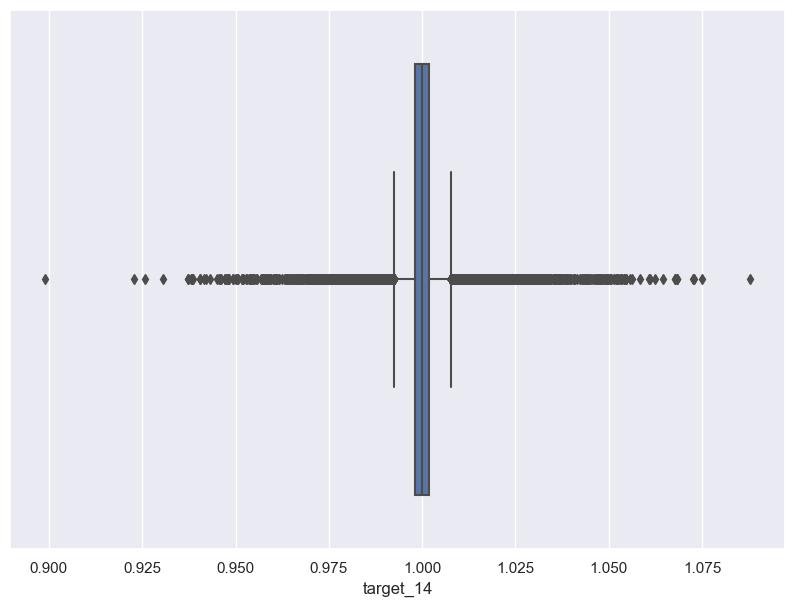

In [87]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [88]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99928834, 0.99839255, 0.99902956, ..., 0.99986065, 1.00021897,
        0.99918881],
       [0.99910357, 0.99974103, 1.00015439, ..., 1.00093129, 0.9999004 ,
        0.99999502],
       [1.00063803, 1.00105176, 1.00098696, ..., 1.00079754, 1.00089225,
        1.00108665]])

In [89]:
y_train_sca

array([[ 0.10288678,  0.08387871, -0.108314  , ..., -0.04072975,
         0.02474249, -0.04917778],
       [-0.03227297, -0.22437723, -0.05549437, ..., -0.09138197,
        -0.16526823, -0.31515178],
       [-0.20539238, -0.03649679, -0.1568349 , ..., -0.14627892,
        -0.29617376, -0.36795438],
       ...,
       [-0.19281646, -0.41881441, -0.25810476, ..., -0.04842888,
         0.04197029, -0.21792734],
       [-0.23943254, -0.07860844,  0.02567594, ...,  0.22168031,
        -0.03840241, -0.01453009],
       [ 0.14769475,  0.2520727 ,  0.23572434, ...,  0.18793685,
         0.2118306 ,  0.26087566]])

## Autoencoder

### Model creation

### Training

In [90]:
X_train_sca.shape

(93331, 72, 102)

In [91]:
3*3*3*10*35/3600

2.625

In [92]:
#tf.keras.optimizers.AdamW()

In [93]:
#tf.keras.optimizers.legacy.AdamW()

In [94]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
#epochs = 500 #100 #150 #6 #300
#patience = 0 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in LIST_UNITS_AE: #[32, 64, 128]: #[104]: #
        for encoding_dim in LIST_UNITS_ENC_AE:#[16, 20, 32]:
            for dropout_autoenc in LIST_DROPOUT_AE: #[0.05, 0.15, 0.25]: #[0.25]:
                for seed in LIST_SEEDS:
                    # check already done ? 
                    #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                    plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                    path_jpg = os.path.join(path_data,
                        f"output_MSE autoencoder - {plt_name}.jpg")
                    if (MODE_TRAIN_AE == False):
                        print(f"BE CAREFUL ! training inactivated => no training done...")
                        continue
                    print(f"Training: {plt_name} ...")
                    # Init
                    tf.keras.backend.clear_session()
                    np.random.seed(seed)
                    random.seed(seed)
                    tf.random.set_seed(seed)
                    # Input dimension
                    input_dim = X_train.shape[-1]
                    # Reduced encoded input dimension
                    # 64/8/0.5
                    # Définir l'encodeur
                    encoder_inputs = keras.Input(shape=(None, input_dim))
                    encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                    #encoder = layers.LayerNormalization()(encoder)
                    #encoder = layers.Dense(encoding_dim, activation='relu')
                    encoder = layers.Dropout(dropout_autoenc)(encoder)
                    encoder_outputs = layers.Dense(encoding_dim)(encoder)
                    encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                    print(encoder_model.summary())
                    # Définir le décodeur
                    decoder_inputs = keras.Input(shape=(None, encoding_dim))
                    decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                    #decoder = layers.LayerNormalization()(decoder)
                    #decoder = layers.Dense(n_unit_enc, activation='relu')
                    decoder = layers.Dropout(dropout_autoenc)(decoder)
                    decoder_outputs = layers.Dense(input_dim)(decoder)
                    decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                    print(decoder_model.summary())
                    # Define complete autoencoder 
                    autoencoder_inputs = keras.Input(shape=(None, input_dim))
                    encoded = encoder_model(autoencoder_inputs)
                    decoded = decoder_model(encoded)
                    autoencoder = keras.Model(autoencoder_inputs, decoded)
                    # Compile : autoencoder
                    optim = tf.keras.optimizers.legacy.Adam()
                    #optim = tf.keras.optimizers.AdamW()
                    #optim = tf.keras.optimizers.Adam()
                    autoencoder.compile(optimizer=optim, loss="mse")
                    # earlystop 
                    es = EarlyStopping(patience=PATIENCE_AE, verbose=2, min_delta=0.001, 
                                    monitor='val_loss', mode='auto', restore_best_weights=True)
                    # Train
                    if PATIENCE_AE == 0:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=EPOCHS_AE, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1)
                    else:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                            epochs=EPOCHS_AE, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                            verbose=1, callbacks=[es])

                    plot_train_history(
                        autoenc_step_history,f"MSE autoencoder - {plt_name}",
                        saveFolder=path_data)
                    #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                    #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                                # save the best
                    mse_curr = np.min(autoenc_step_history.history['val_loss'])
                    print("MSE TEST : ", mse_curr)

                    if mse_curr_min == None:
                        seed_min = seed
                        autoenc_step_history_min = autoenc_step_history
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)
                    else:
                        if mse_curr < mse_curr_min:
                            seed_min = seed
                            autoenc_step_history_min = autoenc_step_history
                            mse_curr_min = mse_curr
                            n_unit_enc_min = n_unit_enc
                            encoding_dim_min = encoding_dim
                            dropout_autoenc_min = dropout_autoenc
                            print("Save autoencoder: ", path_mdl_autoencoder)
                            autoencoder.save(path_mdl_autoencoder)
                            print("Save encoder: ", path_mdl_encoder)
                            encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min

print("Load models...")
autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
print(autoencoder.summary())
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print(encoder_model.summary())
n_unit_enc = encoder_model.layers[1].units
dropout_autoenc = encoder_model.layers[2].rate
encoding_dim = encoder_model.layers[3].units
print(f"Model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

if MODE_TRAIN_AE:
    print(f"Best model : seed:{seed} / n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")
    plot_train_history(
        autoenc_step_history_min, 
        f"Best MSE autoencoder - {plt_name}",
        saveFolder=path_data,
    )

Load models...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 32)          1275936   
                                                                 
 model_1 (Functional)        (None, None, 102)         1168486   
                                                                 
Total params: 2444422 (9.32 MB)
Trainable params: 2444422 (9.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                    

In [95]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [96]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [97]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2917/2917 [==============================] - 68s 23ms/step


(93331, 72, 102)

### Results

In [98]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

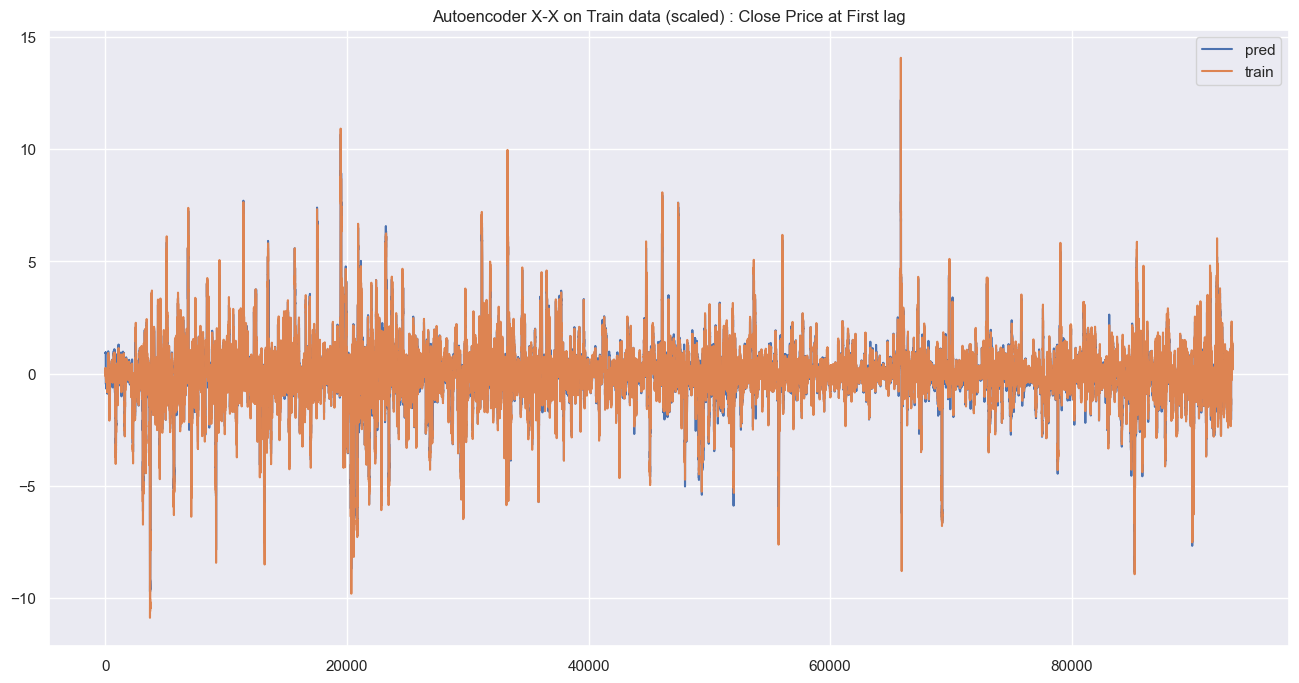

In [99]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [100]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(93331, 72, 102)
(93331, 72, 102)
(72, 102)
(1, 102)


In [101]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.093146  0.107582  0.077922  0.083267          0.115950   
lag_1    0.064263  0.065221  0.051887  0.060861          0.096974   
lag_2    0.055271  0.052886  0.045890  0.053011          0.094485   
lag_3    0.051054  0.048630  0.042497  0.050229          0.092386   
lag_4    0.047895  0.044929  0.039386  0.047508          0.090674   
...           ...       ...       ...       ...               ...   
lag_67   0.040209  0.037074  0.031516  0.041650          0.062841   
lag_68   0.040113  0.037028  0.031442  0.041599          0.062777   
lag_69   0.040031  0.036982  0.031388  0.041543          0.062710   
lag_70   0.039948  0.036928  0.031317  0.041481          0.062638   
lag_71   0.039867  0.036877  0.031248  0.041433          0.062577   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.099180        0.109791         0.097105   
lag_1           0.080266        0.090188         0.076404   
lag_2           0.074035        0.084356         0.069728   
lag_3           0.070382        0.081303         0.065826   
lag_4           0.067940        0.077853         0.060526   
...                  ...             ...              ...   
lag_67          0.054642        0.054223         0.042151   
lag_68          0.054608        0.054218         0.042103   
lag_69          0.054561        0.054216         0.042077   
lag_70          0.054532        0.054203         0.042024   
lag_71          0.054487        0.054190         0.041975   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.116190              0.099549  ...    0.113970  0.101373   
lag_1               0.087855              0.077757  ...    0.083217  0.056826   
lag_2               0.075926              0.070993  ...    0.069815  0.057912   
lag_3               0.070688              0.068928  ...    0.066303  0.057791   
lag_4               0.067741              0.067609  ...    0.064954  0.057367   
...                      ...                   ...  ...         ...       ...   
lag_67              0.061737              0.075901  ...    0.062638  0.059729   
lag_68              0.061748              0.075945  ...    0.062618  0.059733   
lag_69              0.061760              0.075993  ...    0.062605  0.059730   
lag_70              0.061780              0.076036  ...    0.062578  0.059739   
lag_71              0.061805              0.076081  ...    0.062551  0.059758   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.096551     0.114028     0.103898          0.131730   
lag_1   0.057779     0.062209     0.064412          0.093229   
lag_2   0.053699     0.052221     0.060919          0.082612   
lag_3   0.058398     0.051923     0.065306          0.081370   
lag_4   0.062205     0.050496     0.066339          0.082586   
...          ...          ...          ...               ...   
lag_67  0.061903     0.047877     0.069187          0.115564   
lag_68  0.061913     0.047861     0.069170          0.115591   
lag_69  0.061924     0.047846     0.069151          0.115623   
lag_70  0.061931     0.047834     0.069141          0.115644   
lag_71  0.061940     0.047828     0.069132          0.115673   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.106254  0.071803    0.167709    0.112084  
lag_1           0.081009  0.035713    0.124024    0.055441  
lag_2           0.074850  0.024471    0.079512    0.040081  
lag_3           0.071457  0.021182    0.062437    0.032161  
lag_4           0.070471  0.019861    0.054972    0.029870  
...                  ...       ...         ...         ...  
lag_67          0.090178  0.016748    0.039843    0.027901  
lag_68          0.090131  0.016745    0.039830    0.027882  
lag_69          0.090091  0.016743    0.039802    0.027867  
lag_70          0.090040  0.016740    0.039777    0.027854  
lag_71          0.089987  0.01673

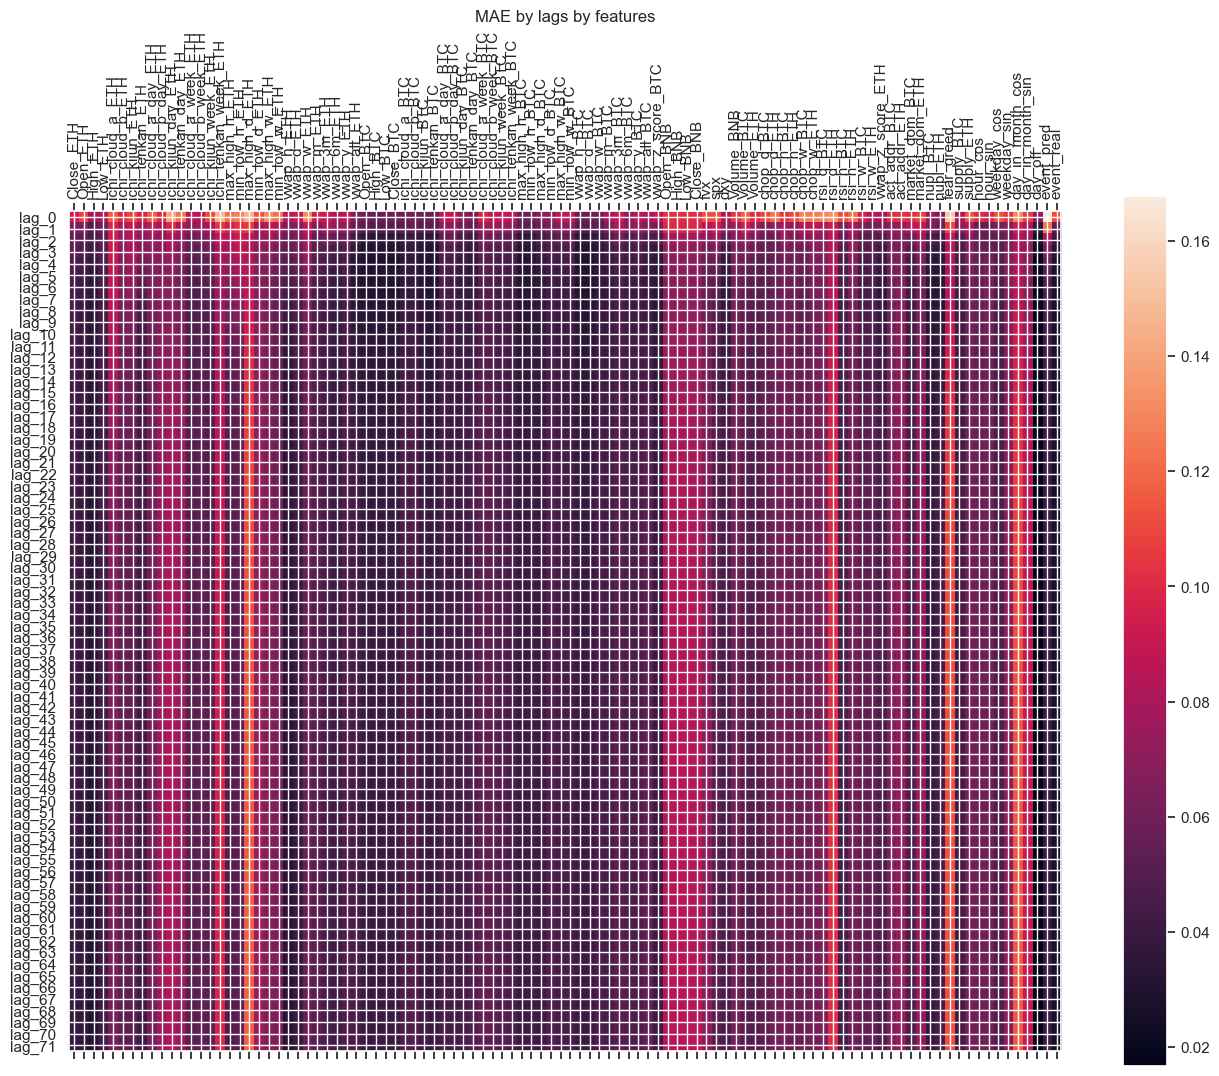

In [102]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

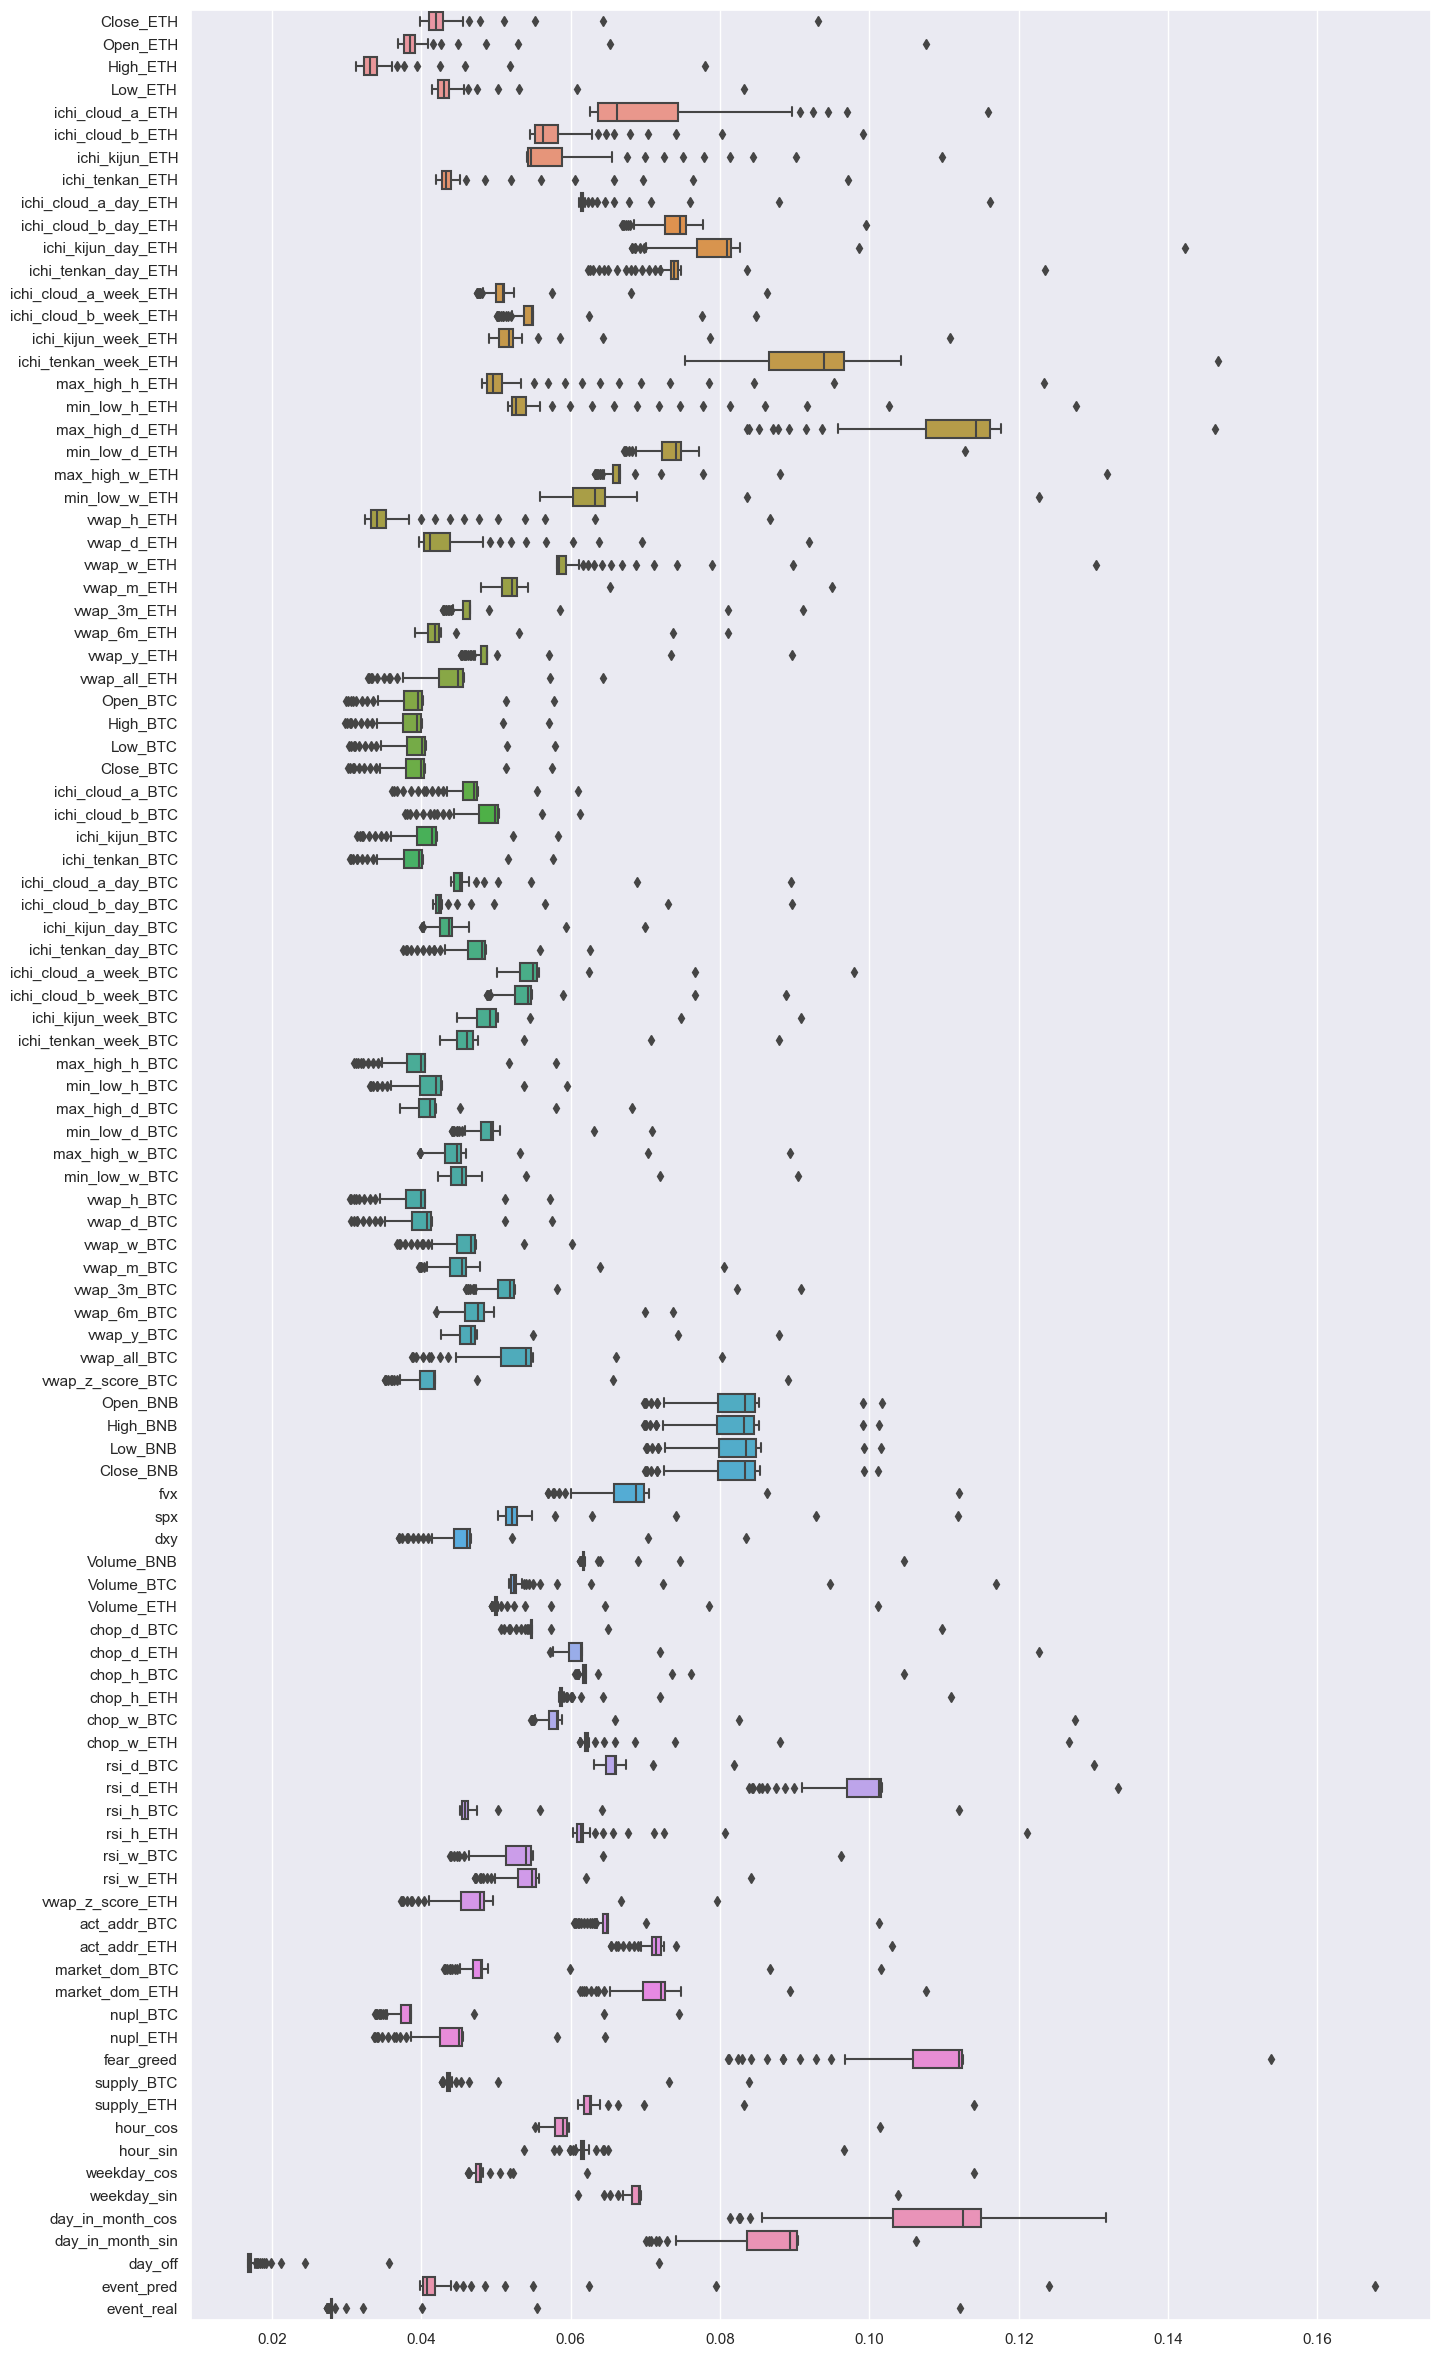

In [103]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [104]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.043361  0.040211  0.034428  0.044073          0.071013   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.058422        0.058857         0.045738              0.063196   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.073899  ...      0.0634  0.059151  0.061922     0.048878   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.069072          0.107752          0.086175  0.018323    0.045212   

   event_real  
0    0.029708  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

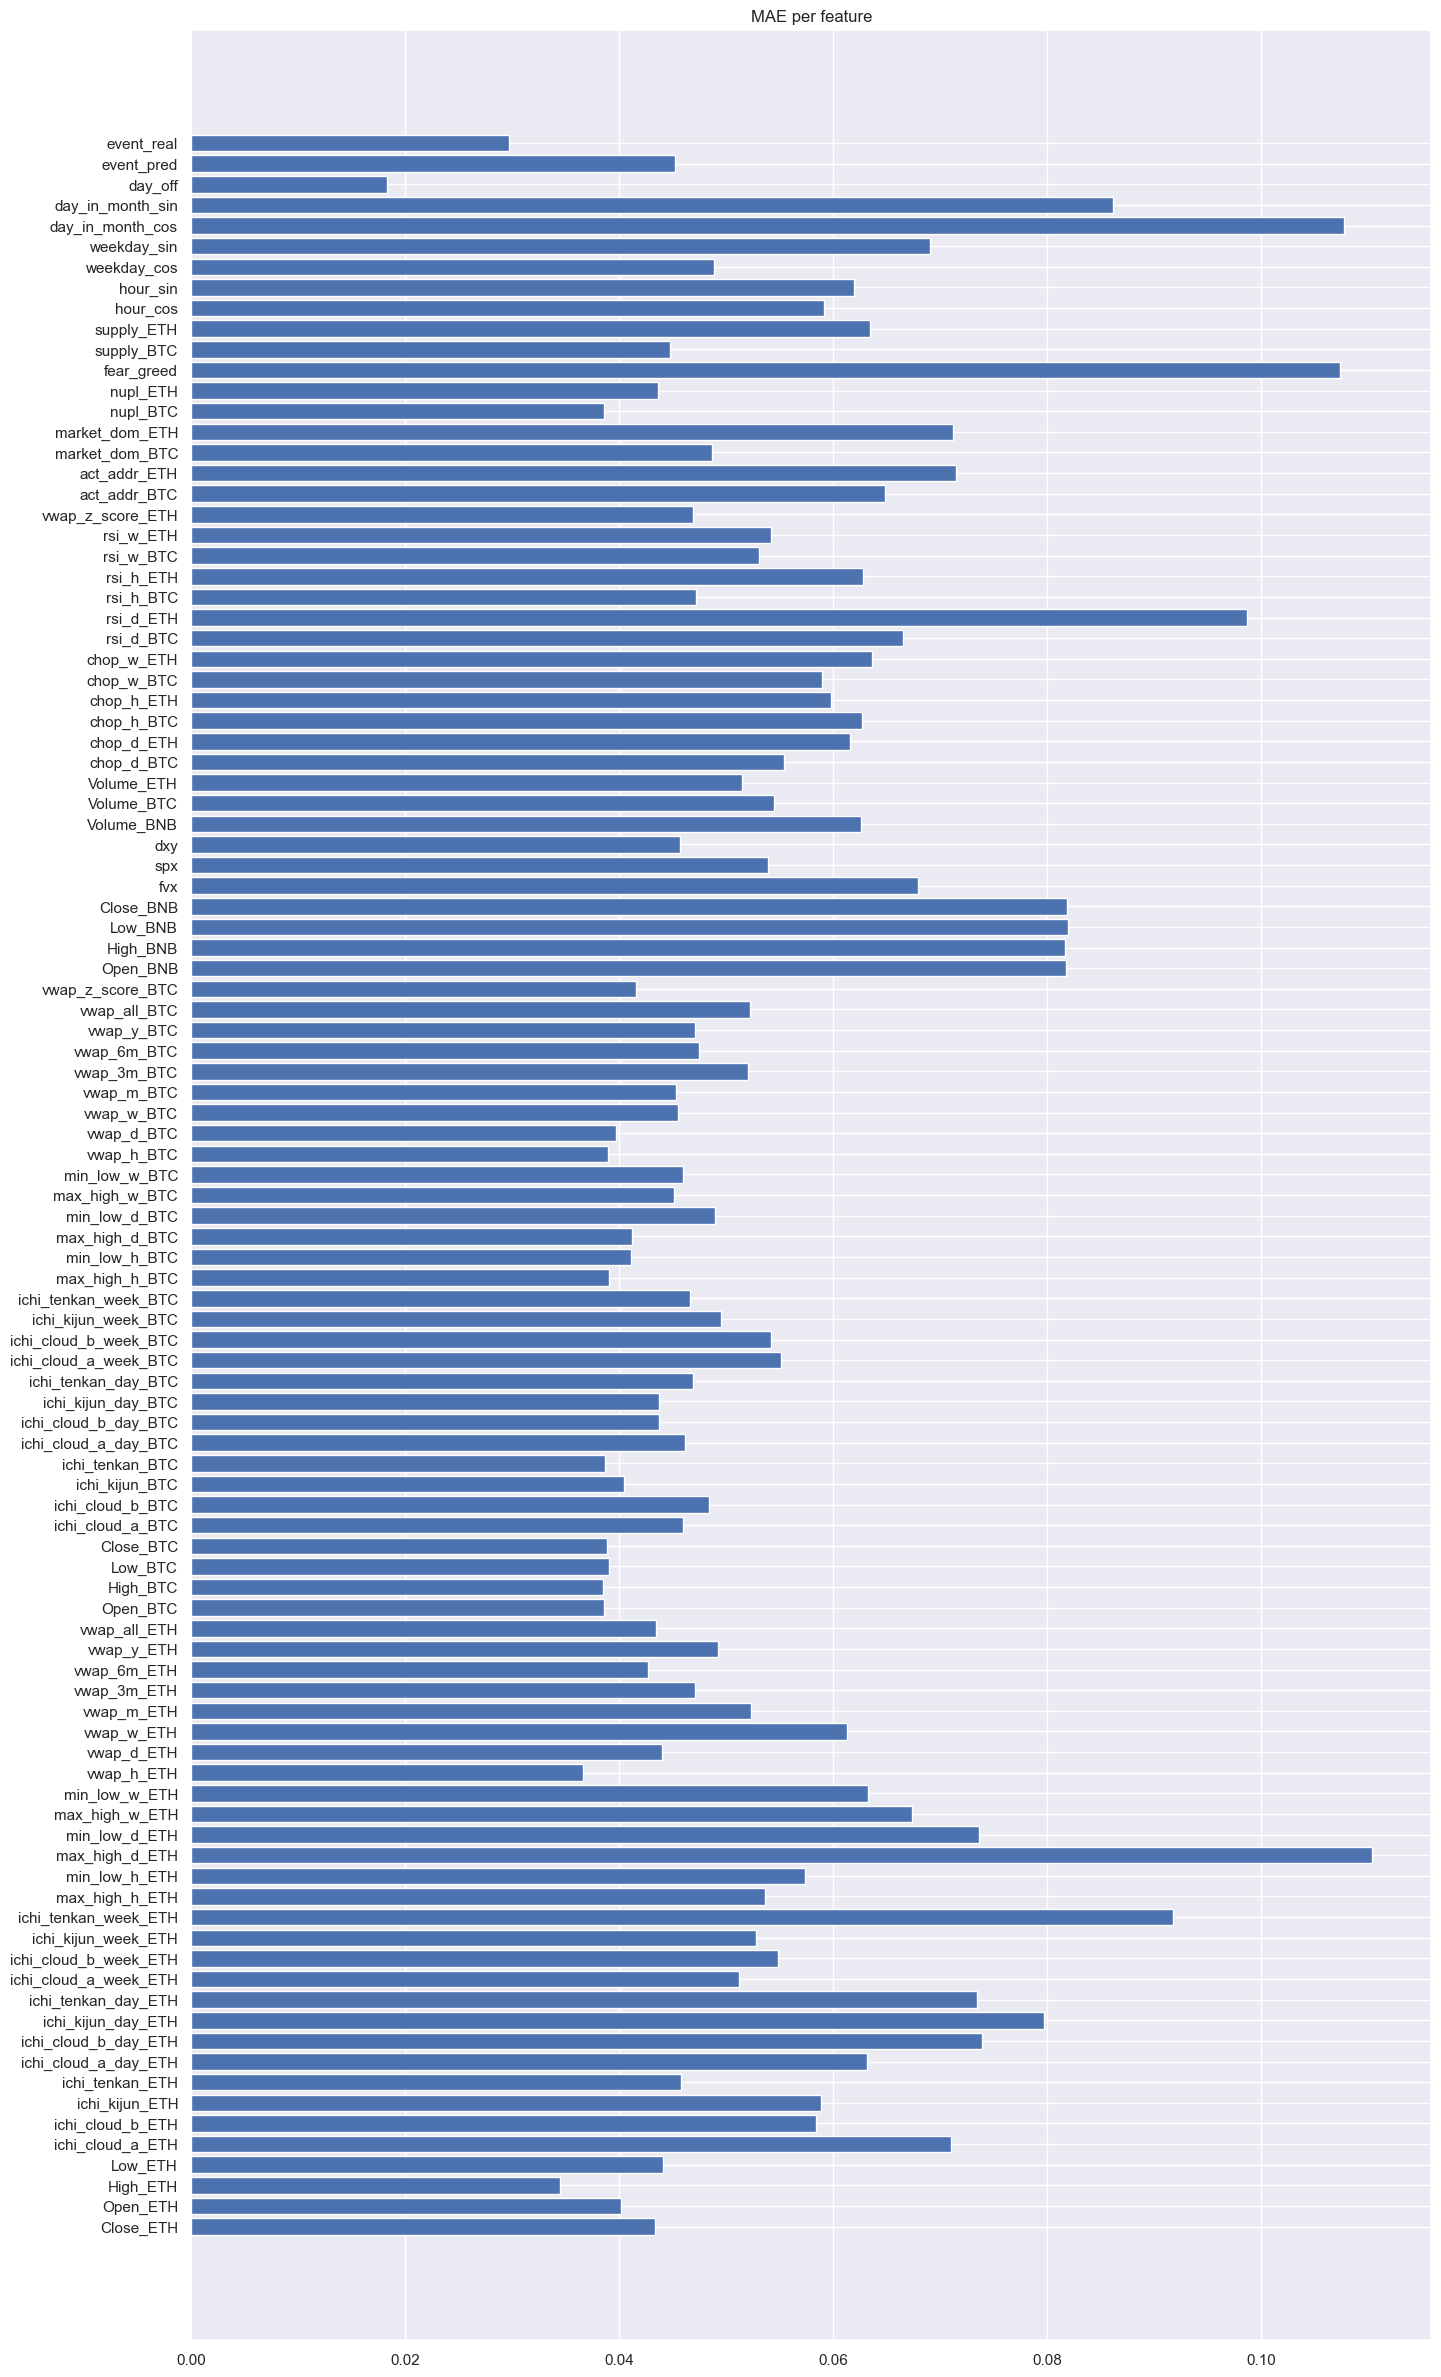

In [105]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [106]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(93331,)
(93331,)
[1196.32 1195.38 1194.55 ... 2024.67 2025.37 2028.18]
[1196.32 1195.38 1194.55]


In [107]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.9997554 , 0.99991566, 0.9999996 , ..., 1.0004711 , 0.99997556,
       1.0005287 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 2024.67 2025.37 2028.18]
[1203.54852555 1203.98428422 1203.88022363 ... 2023.98121495 2024.28845299
 2026.72475859]


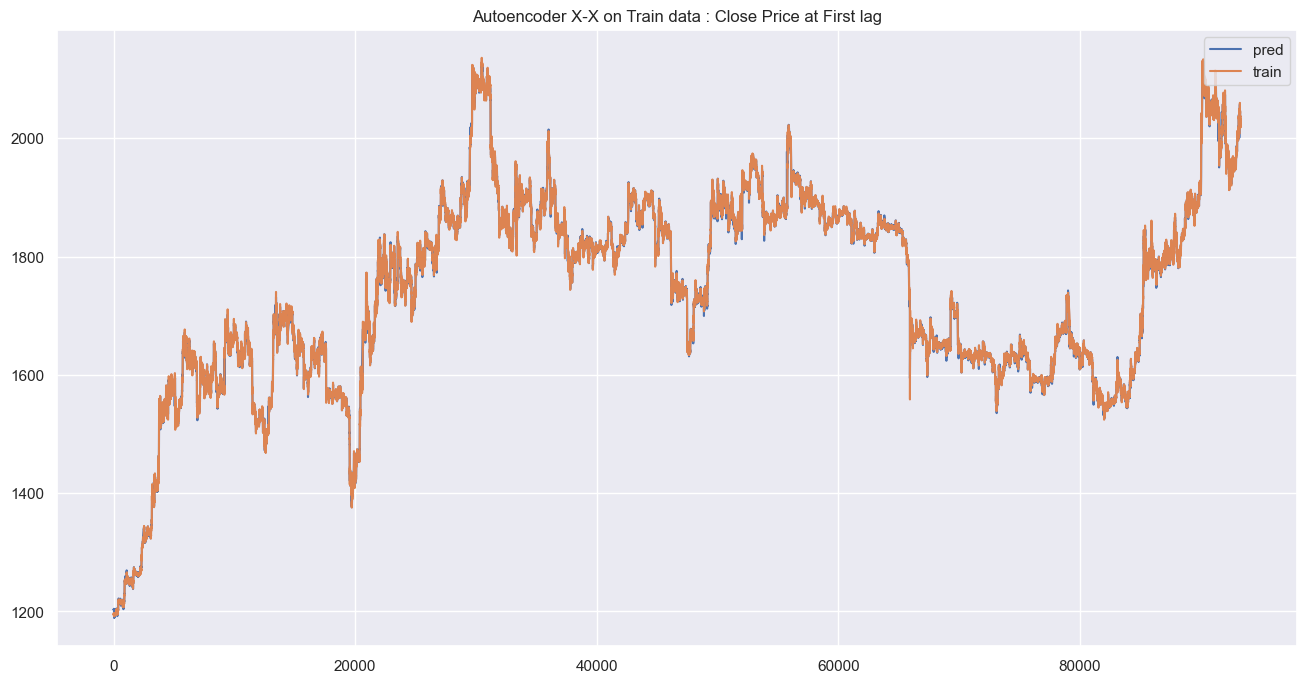

In [108]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [109]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

12/12 [==============================] - 0s 38ms/step


(381, 72, 102)

In [110]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-11-21 08:45:00'

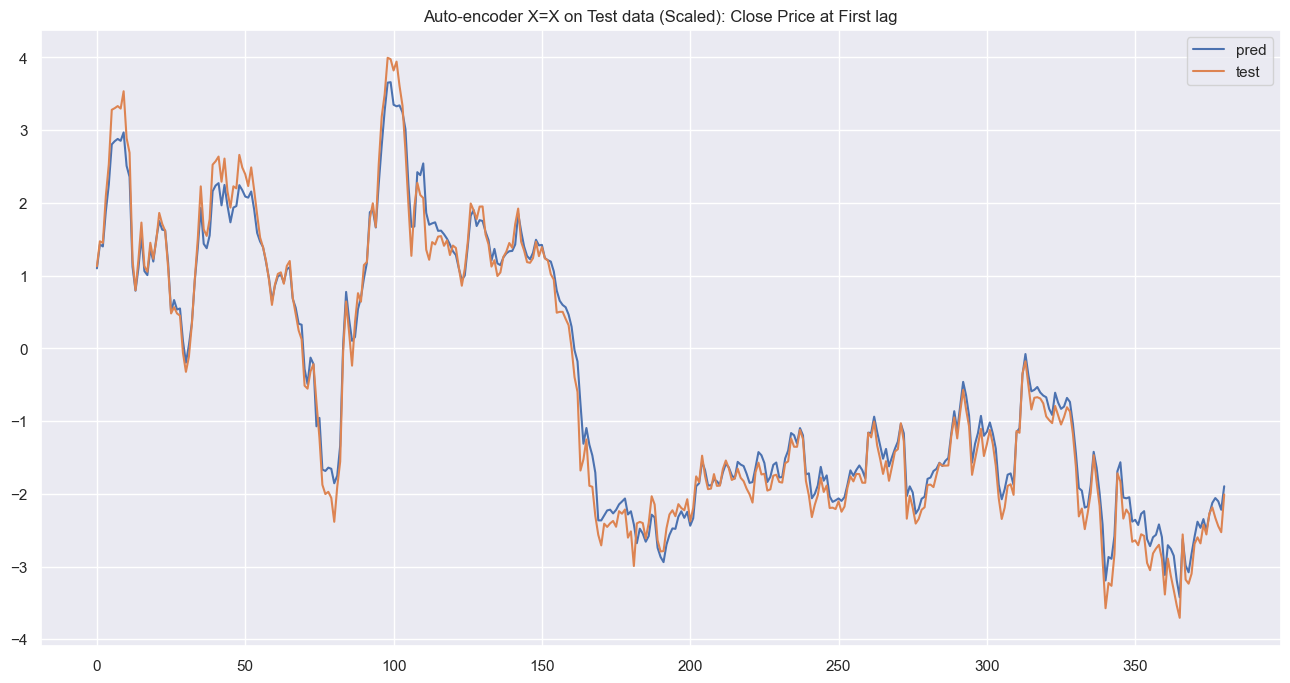

In [111]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [112]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [2010.   2012.13 2013.28 2013.19 2012.9  2014.09 2014.51 2014.09 2012.22]
X test pred :  [2009.52831684 2011.42353719 2012.47837393 2009.79538392 2008.34154042
 2006.36556641 2007.13328535 2006.75532353 2005.02113143]


[2010.   2012.13 2013.28 2013.19 2012.9  2014.09 2014.51 2014.09 2012.22
 2012.51 2011.35 2009.28 2009.4  2007.94 2008.14 2009.05 2008.59 2013.19
 2013.61 2014.3  2015.15 2015.98 2016.29 2014.65 2013.03 2014.29 2014.19
 2014.04 2012.19 2008.75 2007.04 2005.16 2007.55 2006.31 2004.8  2004.78
 2005.08 2004.01 2004.56 2006.61 2007.51 2007.8  2007.46 2011.5  2009.62
 2010.3  2011.57 2009.06 2010.65 2011.48 2012.68 2009.3  2011.09 2010.08
 2012.27 2013.2  2010.84 2008.05 2006.   2003.58 2004.73 2004.4  2002.47
 1997.05 1995.5  1996.99 1996.58 1993.79 1993.32 1990.95 1988.18 1991.7
 1988.21 1989.7  1979.19 1971.9  1961.12 1961.17 1960.31 1959.03 1955.56
 1964.62 1965.81 1989.67 1995.06 1988.33 1980.99 1990.27 1996.09 1990.
 1994.29 1991.07 1985.67 1988.41 1988.38 1995.06 2006.63 2005.1  2006.39
 2005.04 2010.11 2012.75 2007.39 2002.37 1990.88 1980.4  1968.77 1978.58
 1978.98 1975.81 1965.8  1965.94 1965.19 1970.38 1969.25 1974.62 1978.89
 1975.43 1973.41 1967.61 1971.2  1973.86 1973.14 1970.

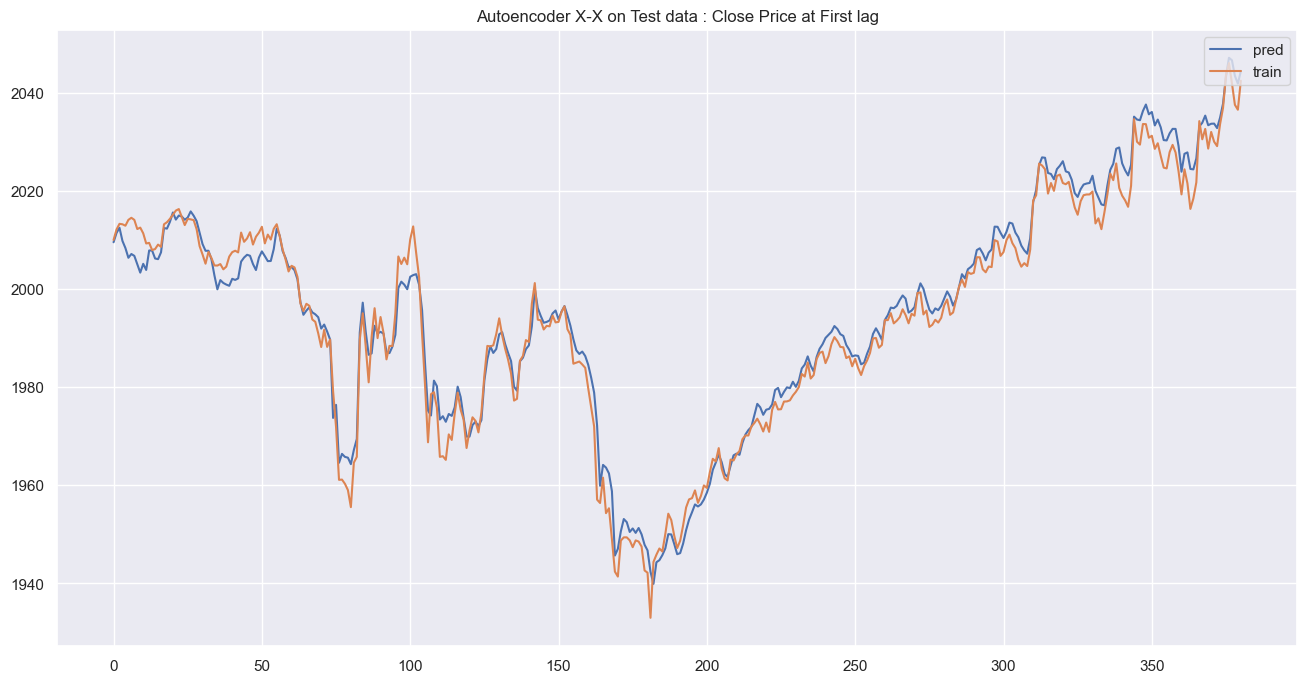

In [113]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [114]:
X_test_sca.shape

(381, 72, 102)

In [115]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.18839192045091696

In [116]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(381, 72, 102)
(381, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.093146  0.107582  0.077922  0.083267          0.115950   
lag_1    0.064263  0.065221  0.051887  0.060861          0.096974   
lag_2    0.055271  0.052886  0.045890  0.053011          0.094485   
lag_3    0.051054  0.048630  0.042497  0.050229          0.092386   
lag_4    0.047895  0.044929  0.039386  0.047508          0.090674   
...           ...       ...       ...       ...               ...   
lag_67   0.106435  0.106625  0.089161  0.123288          0.189386   
lag_68   0.106804  0.106724  0.089544  0.123496          0.190413   
lag_69   0.106842  0.106909  0.089528  0.123574          0.190943   
lag_70   0.107236  0.106525  0.089366  0.123844          0.191369   
lag_71   0.107599  0.107080  0.089508  0.124507          0.192448   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.099180        0.109791         0.097105   
lag_1           0.080266        0.090188         0.076404   
lag_2           0.074035        0.084356         0.069728   
lag_3           0.070382        0.081303         0.065826   
lag_4           0.067940        0.077853         0.060526   
...                  ...             ...              ...   
lag_67          0.090917        0.203479         0.099128   
lag_68          0.091594        0.204179         0.099554   
lag_69          0.091745        0.204950         0.099420   
lag_70          0.091400        0.205458         0.099770   
lag_71          0.091292        0.205484         0.099229   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.116190              0.099549  ...  0.101373  0.096551   
lag_1               0.087855              0.077757  ...  0.056826  0.057779   
lag_2               0.075926              0.070993  ...  0.057912  0.053699   
lag_3               0.070688              0.068928  ...  0.057791  0.058398   
lag_4               0.067741              0.067609  ...  0.057367  0.062205   
...                      ...                   ...  ...       ...       ...   
lag_67              0.119439              0.049727  ...  0.102536  0.123240   
lag_68              0.119953              0.049318  ...  0.102707  0.123479   
lag_69              0.120470              0.048971  ...  0.102499  0.123735   
lag_70              0.120966              0.048877  ...  0.102321  0.123501   
lag_71              0.121459              0.048693  ...  0.102412  0.122837   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.114028     0.103898          0.131730          0.106254   
lag_1      0.062209     0.064412          0.093229          0.081009   
lag_2      0.052221     0.060919          0.082612          0.074850   
lag_3      0.051923     0.065306          0.081370          0.071457   
lag_4      0.050496     0.066339          0.082586          0.070471   
...             ...          ...               ...               ...   
lag_67     0.045932     0.148709          0.306114          0.064110   
lag_68     0.045745     0.149983          0.308475          0.063668   
lag_69     0.045532     0.150895          0.310239          0.062871   
lag_70     0.045390     0.152068          0.312489          0.062085   
lag_71     0.045174     0.152993          0.314348          0.061344   

         day_off  event_pred  event_real  dataset  
lag_0   0.071803    0.167709    0.112084    TRAIN  
lag_1   0.035713    0.124024    0.055441    TRAIN  
lag_2   0.024471    0.079512    0.040081    TRAIN  
lag_3   0.021182    0.062437    0.032161    TRAIN  
lag_4   0.019861    0.054972    0.029870    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.050119    0.077978    0.059525     TEST  
lag_68  0.049916    0.077939    0.059010     TEST  
lag_69  0.049603    0.077850    0.058888     TEST  
lag_70  0.049567    0.077725    0.058808     TEST  
lag_71  0.049304    0.077307    0.058532     TEST  

[144 ro

In [117]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.098651  0.097754  0.083722  0.110286          0.163544   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.089414        0.189109         0.093901               0.11602   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.054386  ...    0.099709  0.104224  0.117998     0.047605   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.121514          0.248329          0.110829  0.049791    0.085493   

   event_real  
0    0.068088  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

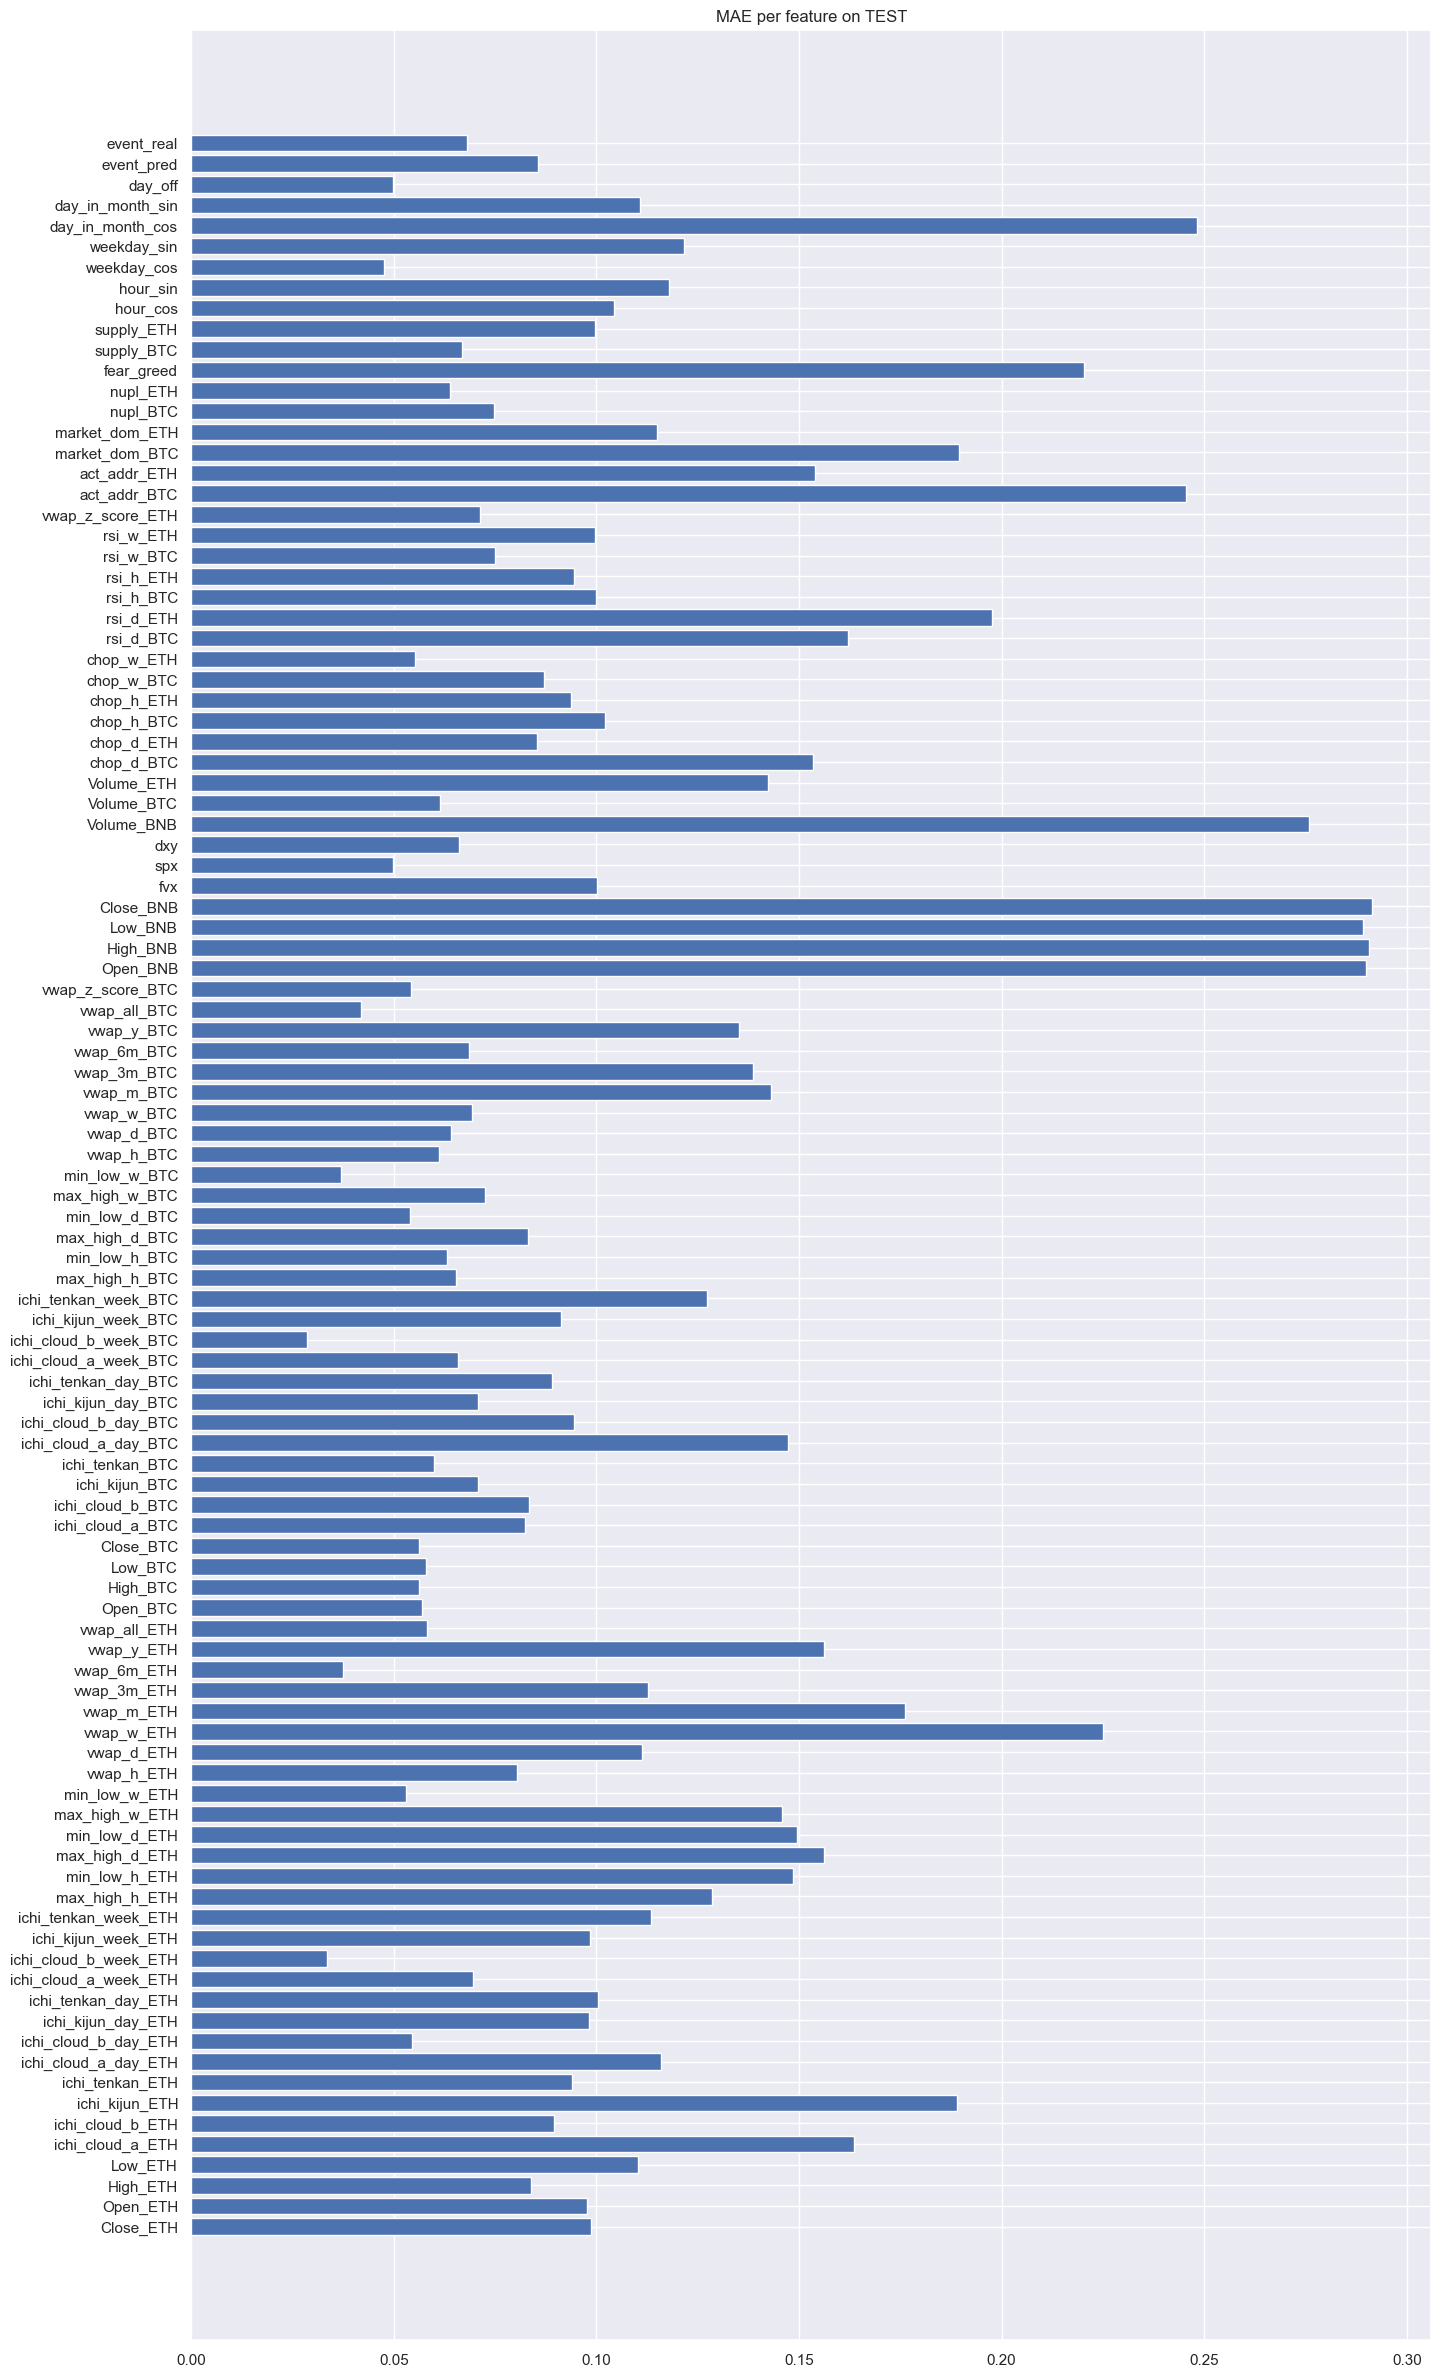

In [118]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [119]:
df_mae_ae_test_feat.values[0]

array([0.09865065, 0.09775394, 0.0837216 , 0.11028649, 0.16354439,
       0.08941351, 0.1891092 , 0.09390062, 0.11602012, 0.05438626,
       0.09810371, 0.10025826, 0.06941579, 0.03360094, 0.09831014,
       0.11340924, 0.128553  , 0.14852691, 0.15618888, 0.14944537,
       0.14591212, 0.05308954, 0.08038045, 0.11113456, 0.22507595,
       0.17618208, 0.11282428, 0.03750352, 0.15607447, 0.05826806,
       0.0570304 , 0.05611513, 0.05800359, 0.05619513, 0.08242921,
       0.08328996, 0.07074178, 0.05992756, 0.14731669, 0.09444149,
       0.07073248, 0.0891127 , 0.06590361, 0.02855722, 0.09123561,
       0.12737499, 0.06538198, 0.06316741, 0.0831079 , 0.05396912,
       0.07260468, 0.03686145, 0.06107527, 0.0639757 , 0.06935935,
       0.14309208, 0.13873398, 0.06848928, 0.13522545, 0.04189379,
       0.05433667, 0.28996107, 0.29061685, 0.28928726, 0.29148713,
       0.10014519, 0.04981465, 0.06599874, 0.27596253, 0.06145567,
       0.14233493, 0.15334282, 0.08523117, 0.10219328, 0.09383

In [120]:
2/df_mae_ae_test_feat.values[0].sum()

0.17928038688272568

In [121]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.093146
1       TRAIN   Close_ETH  0.064263
2       TRAIN   Close_ETH  0.055271
3       TRAIN   Close_ETH  0.051054
4       TRAIN   Close_ETH  0.047895
...       ...         ...       ...
14683    TEST  event_real  0.059525
14684    TEST  event_real  0.059010
14685    TEST  event_real  0.058888
14686    TEST  event_real  0.058808
14687    TEST  event_real  0.058532

[14688 rows x 3 columns]

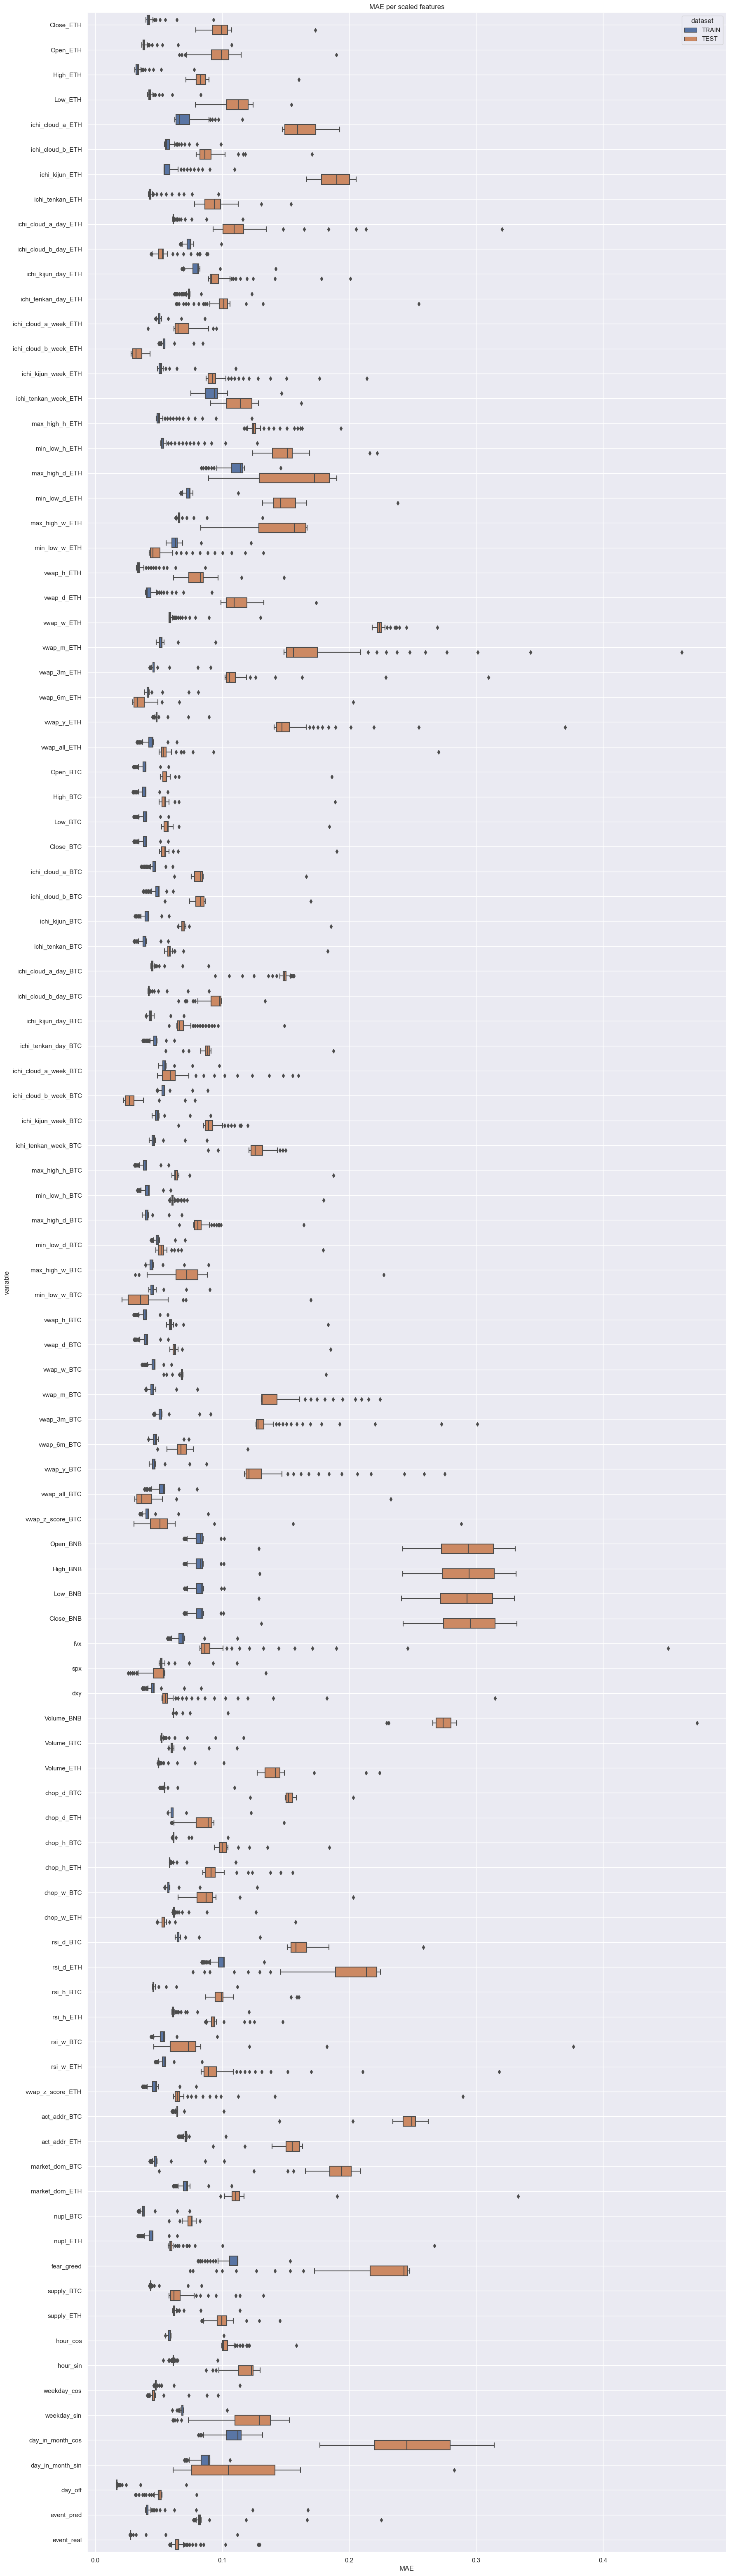

In [122]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [123]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(93331, 72, 102)
(93331, 72, 102)
(72, 102)
(381, 72, 102)
(381, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [124]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.004061  0.003714  0.003118  0.004480          0.009119   
0   0.027707  0.028602  0.025149  0.029117          0.037965   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.006092        0.007266         0.004907              0.006496   
0          0.013701        0.057004         0.017386              0.018788   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.008754  ...  0.005712  0.006129     0.004346     0.008341   
0              0.004702  ...  0.017615  0.020568     0.005502     0.021541   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.018759          0.011869  0.000833    0.004456    0.002015   
0          0.071615          0.022174  0.007381    0.013040    0.012738   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

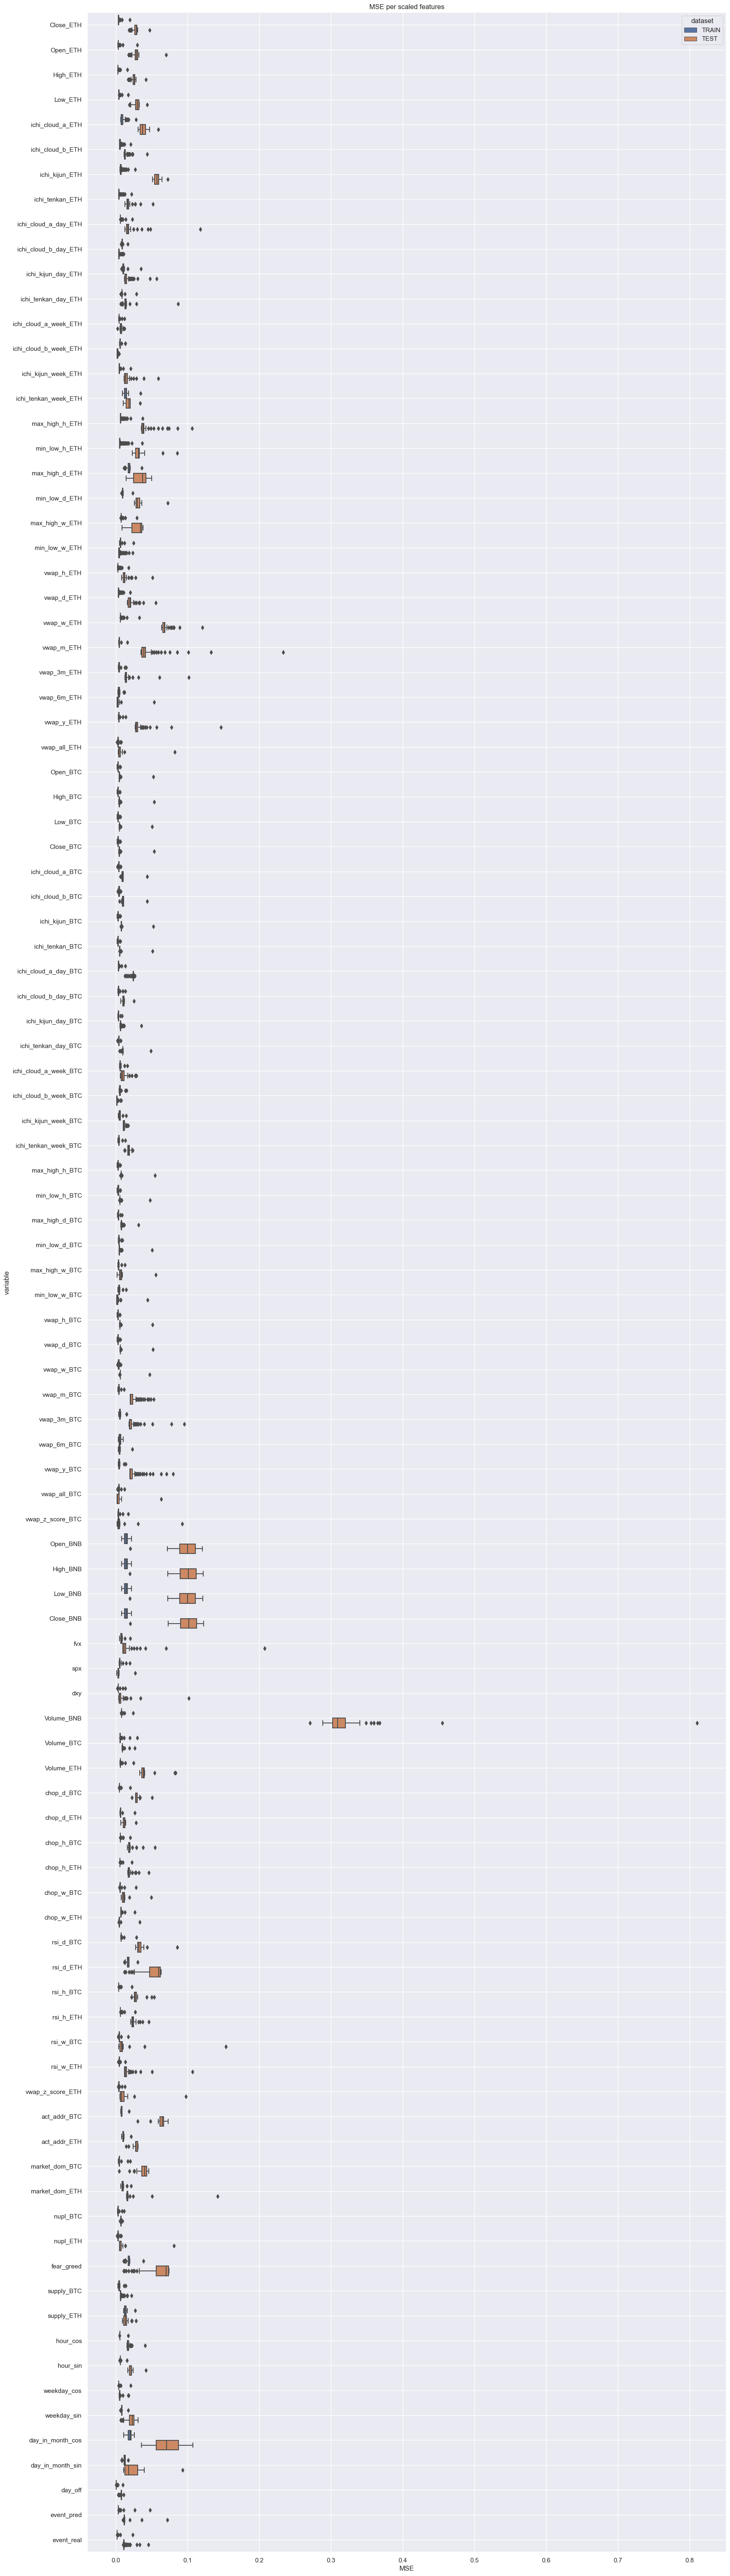

In [125]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

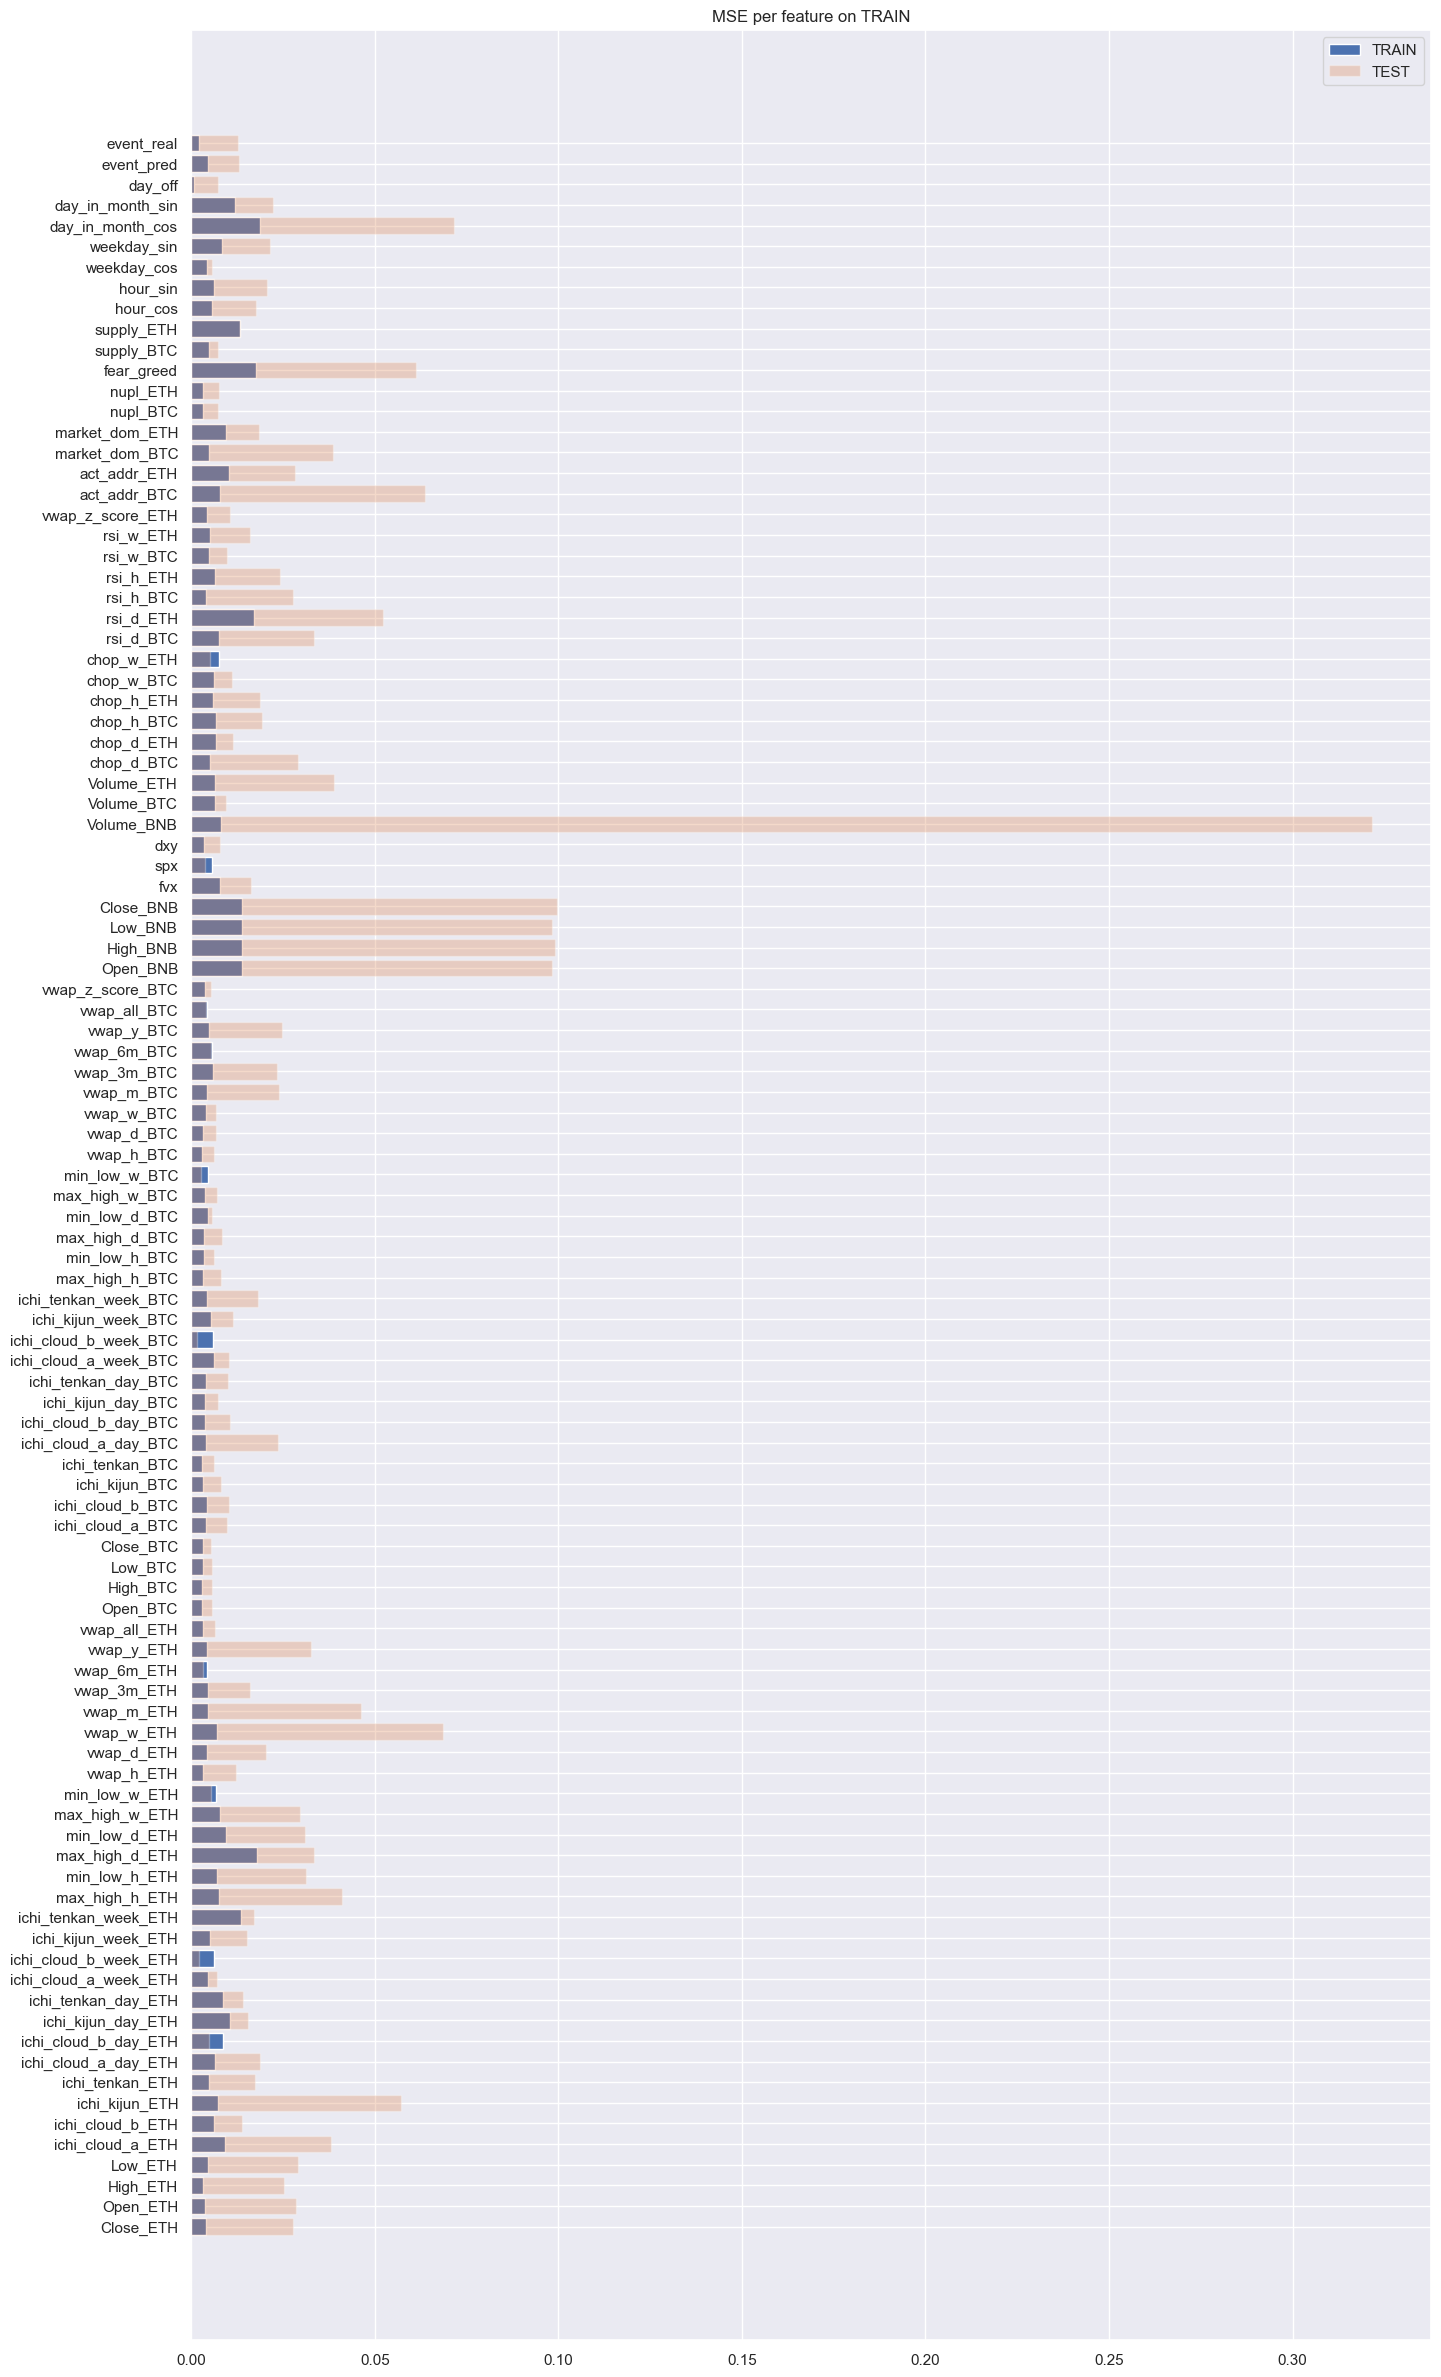

In [126]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [127]:
encoder_model.layers[3].get_weights()

[array([[ 0.01240596, -0.03261789, -0.08734114, ..., -0.05698767,
         -0.02794477,  0.08953414],
        [-0.04344475,  0.06261782, -0.08158588, ..., -0.03354067,
         -0.13119902, -0.10028818],
        [ 0.09952434, -0.10814478, -0.02270626, ...,  0.05264883,
         -0.0911576 , -0.13474698],
        ...,
        [ 0.02589135,  0.08612335, -0.08079195, ..., -0.17842285,
          0.10103264,  0.17343178],
        [ 0.2758045 ,  0.1548707 , -0.13072829, ..., -0.1969904 ,
          0.02389397, -0.21257314],
        [ 0.17908916,  0.21327306, -0.27508667, ..., -0.05443688,
         -0.19381511,  0.1943256 ]], dtype=float32),
 array([-0.07502023, -0.07135796, -0.01603233, -0.07208396,  0.12448683,
        -0.02396388, -0.13188723,  0.03528473,  0.2259679 ,  0.01930368,
         0.24479014, -0.0114355 , -0.02043176,  0.05632822, -0.07081147,
         0.03707137,  0.02711898, -0.01963935,  0.00262132, -0.06311832,
        -0.16345678,  0.04338109, -0.07815944, -0.08202428, -0.234

## Prediction Models

### LSTM all features

In [128]:
X_train_sca.shape

(93331, 72, 102)

In [129]:
X_train_sca.shape[-1]

102

In [130]:
X_train_sca.shape[-2:]

(72, 102)

In [131]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    PATIENCE_PRED = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=PATIENCE_PRED,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if PATIENCE_PRED == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [132]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [133]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

2917/2917 [==============================] - 36s 12ms/step


(93331, 72, 32)

In [134]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

 1/12 [=>............................] - ETA: 0s

12/12 [==============================] - 0s 20ms/step


(381, 72, 32)

In [135]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [136]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [137]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [138]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((93331, 72, 36), (381, 72, 36))

#### Correlations

In [139]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



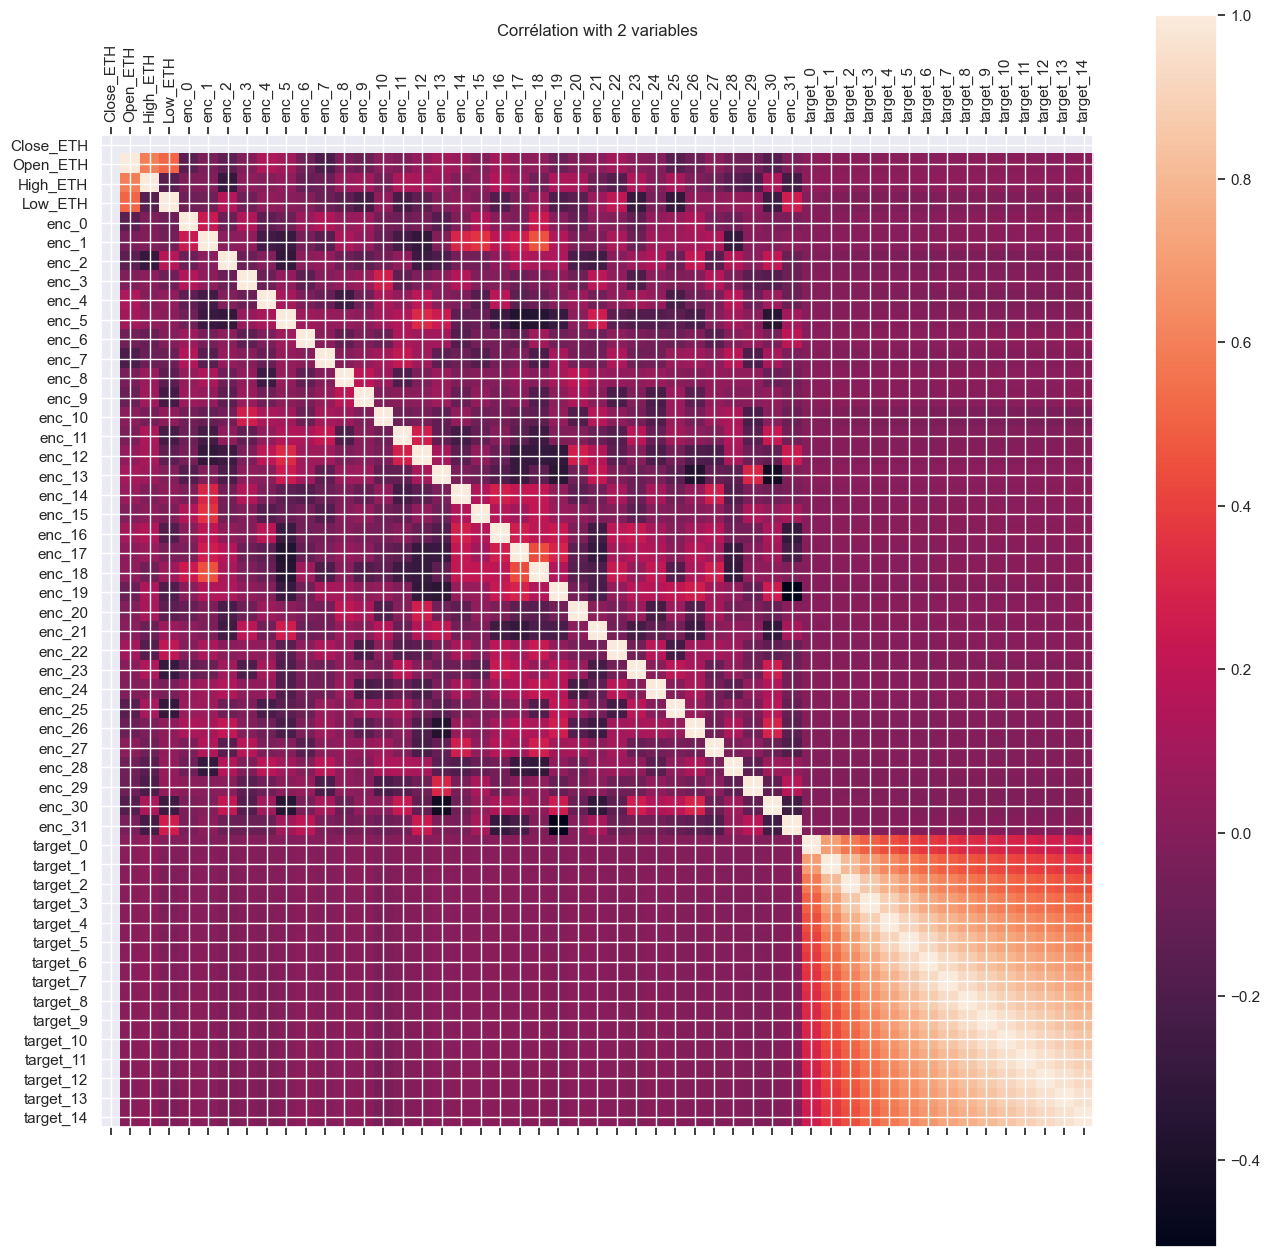

In [140]:
fig = plot_corr(corr_matrix_min)

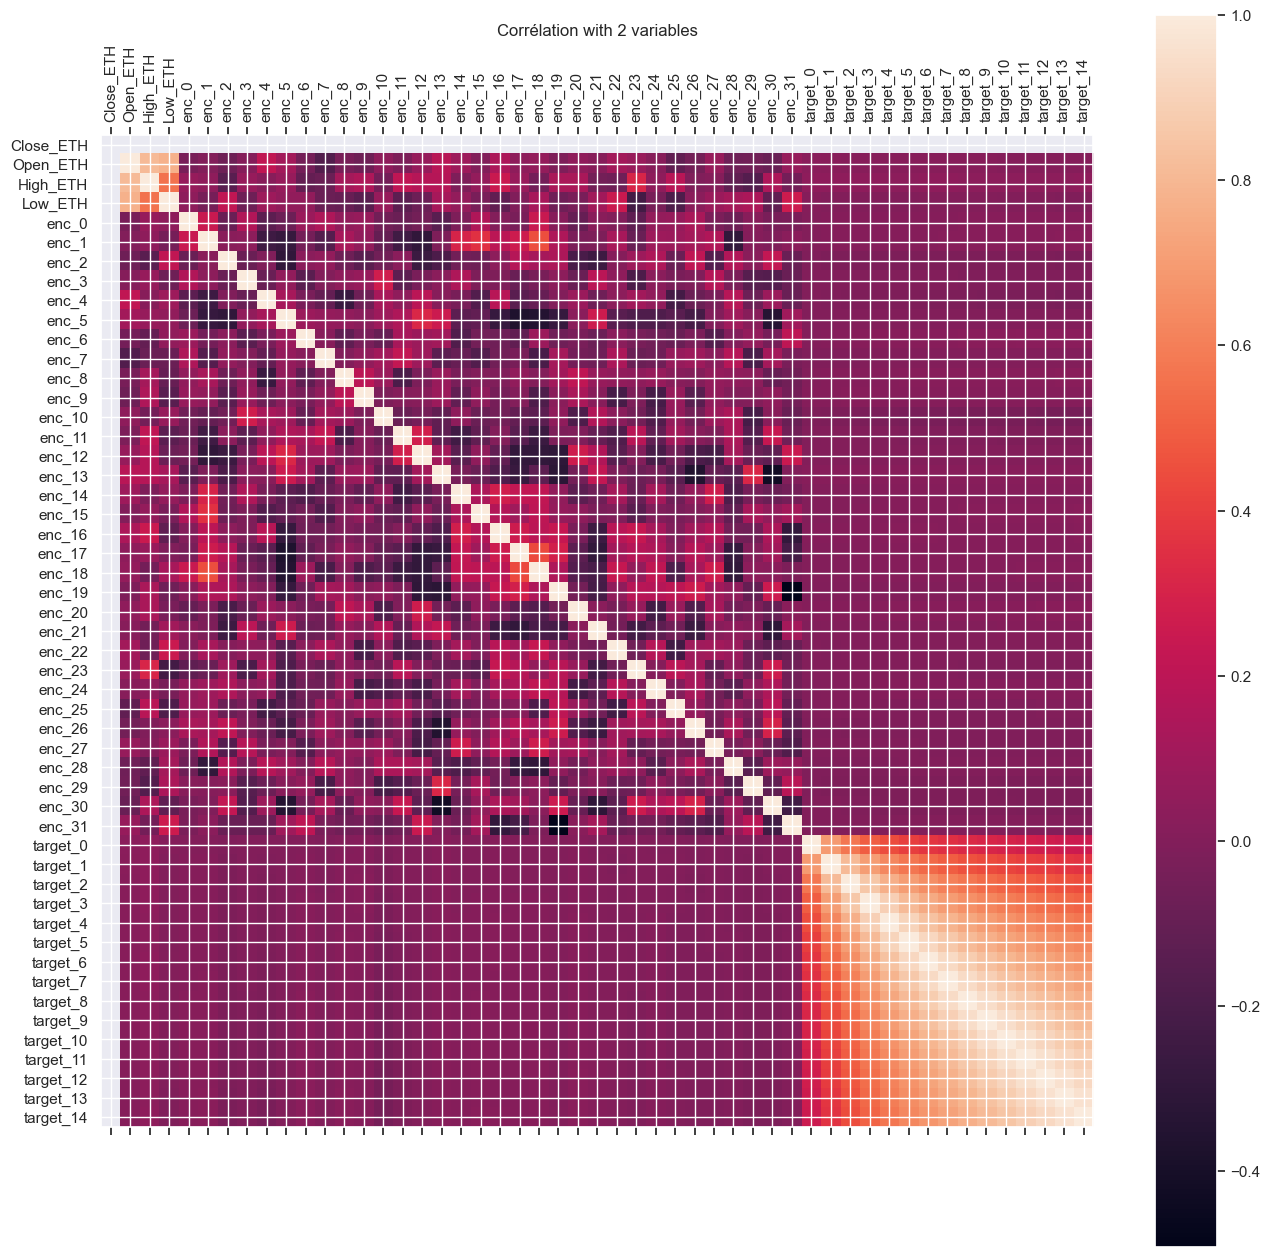

In [141]:
fig = plot_corr(corr_matrix_max) 

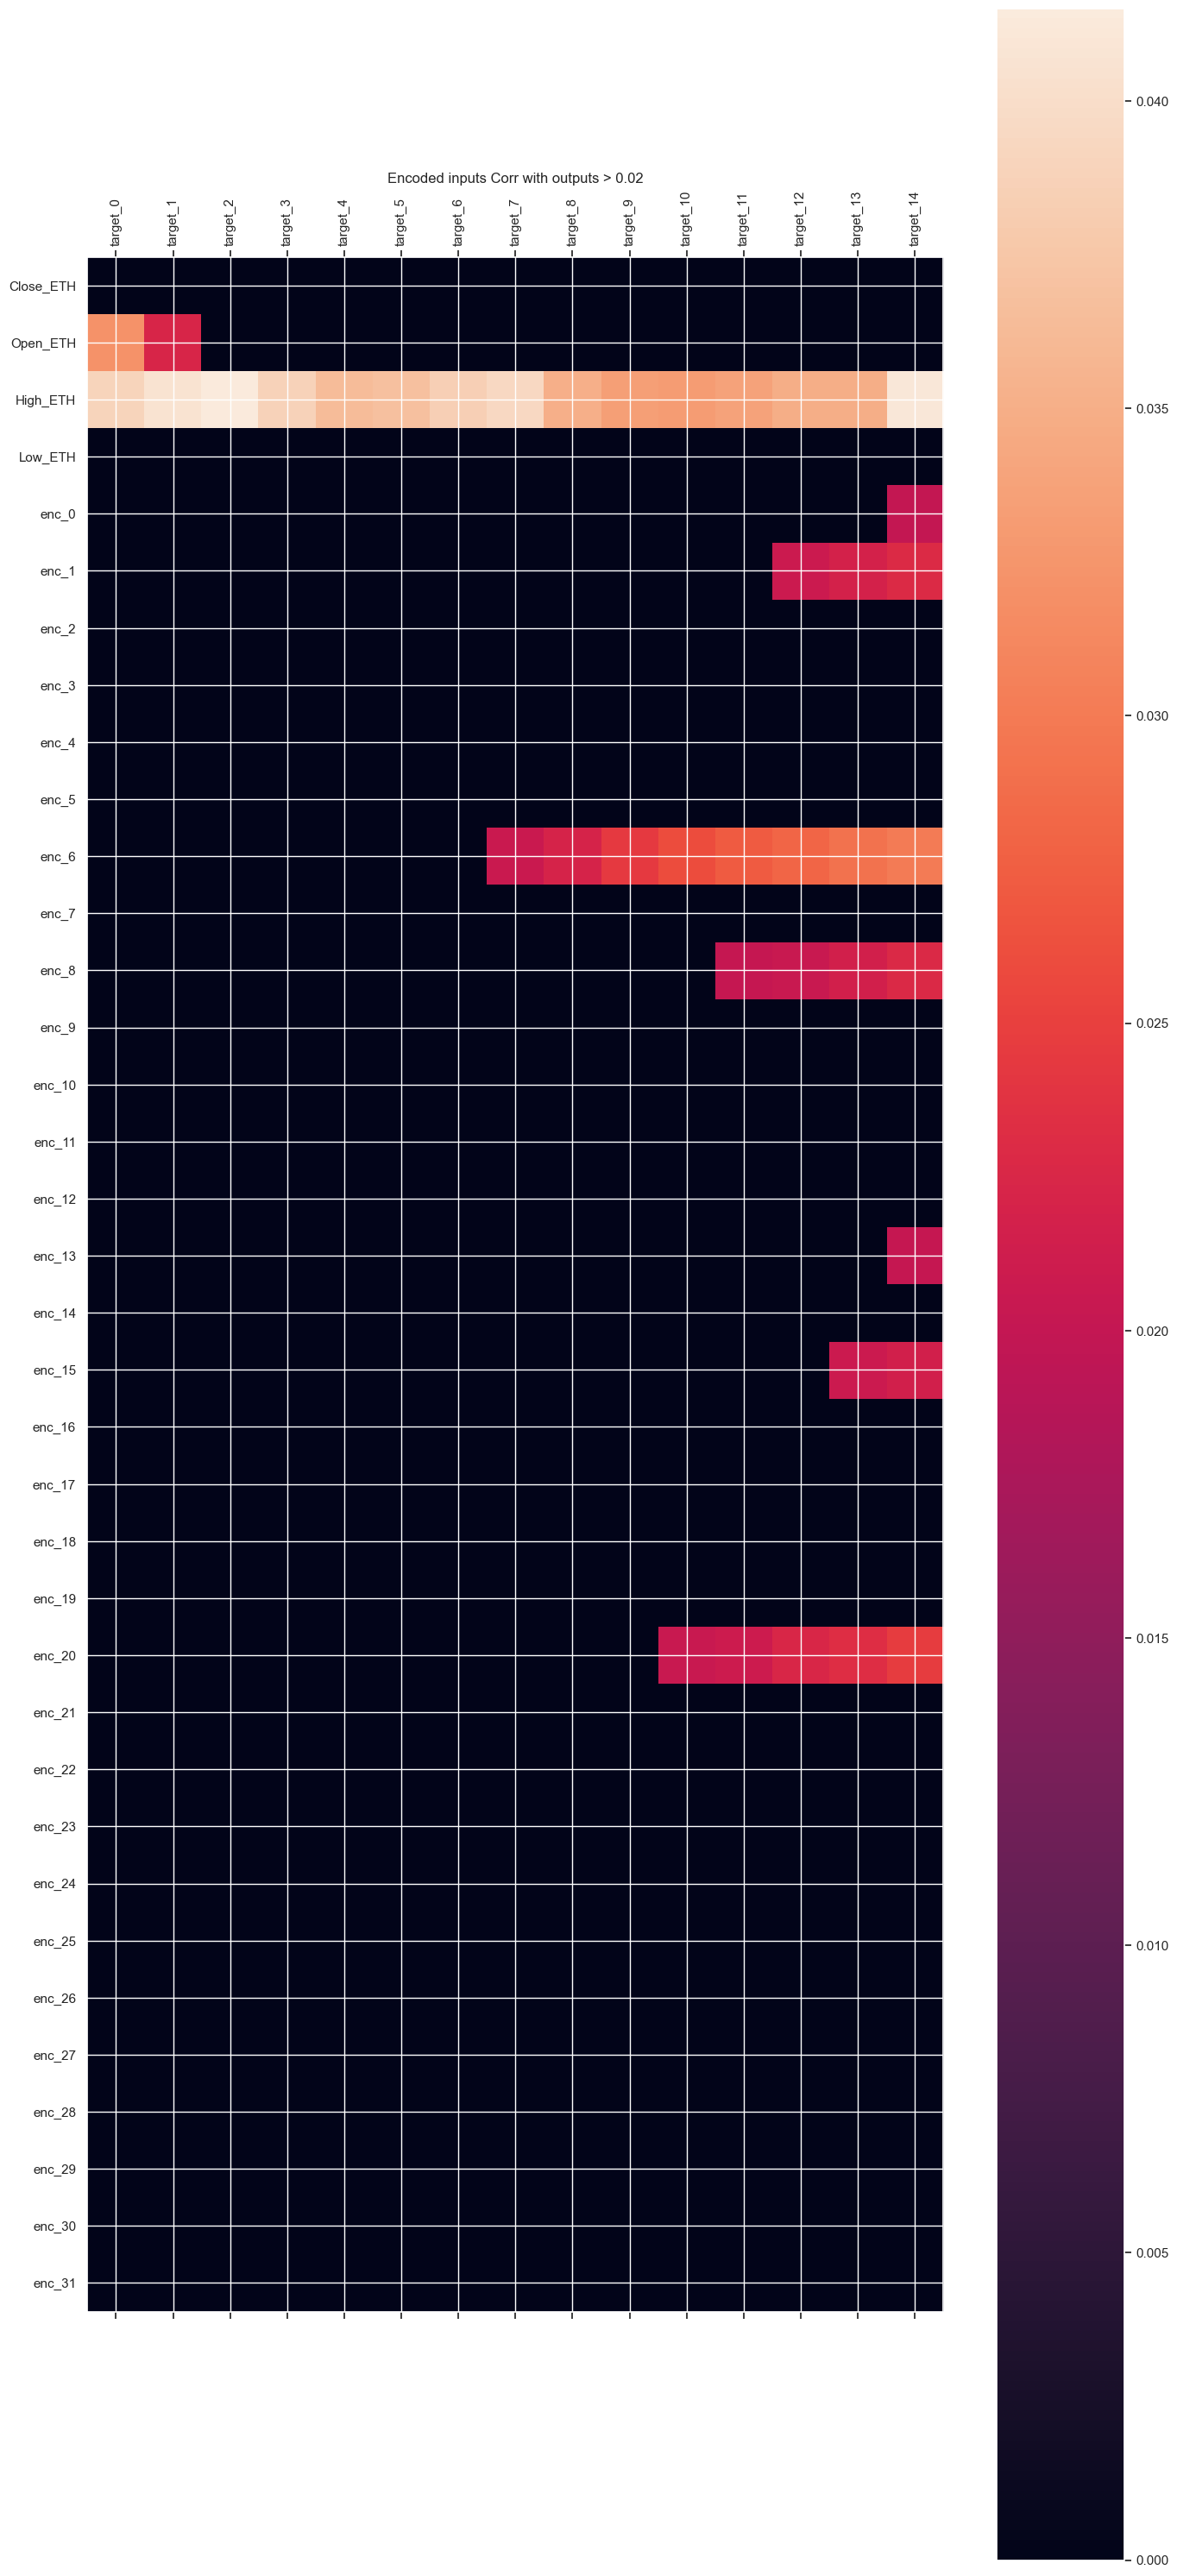

In [142]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

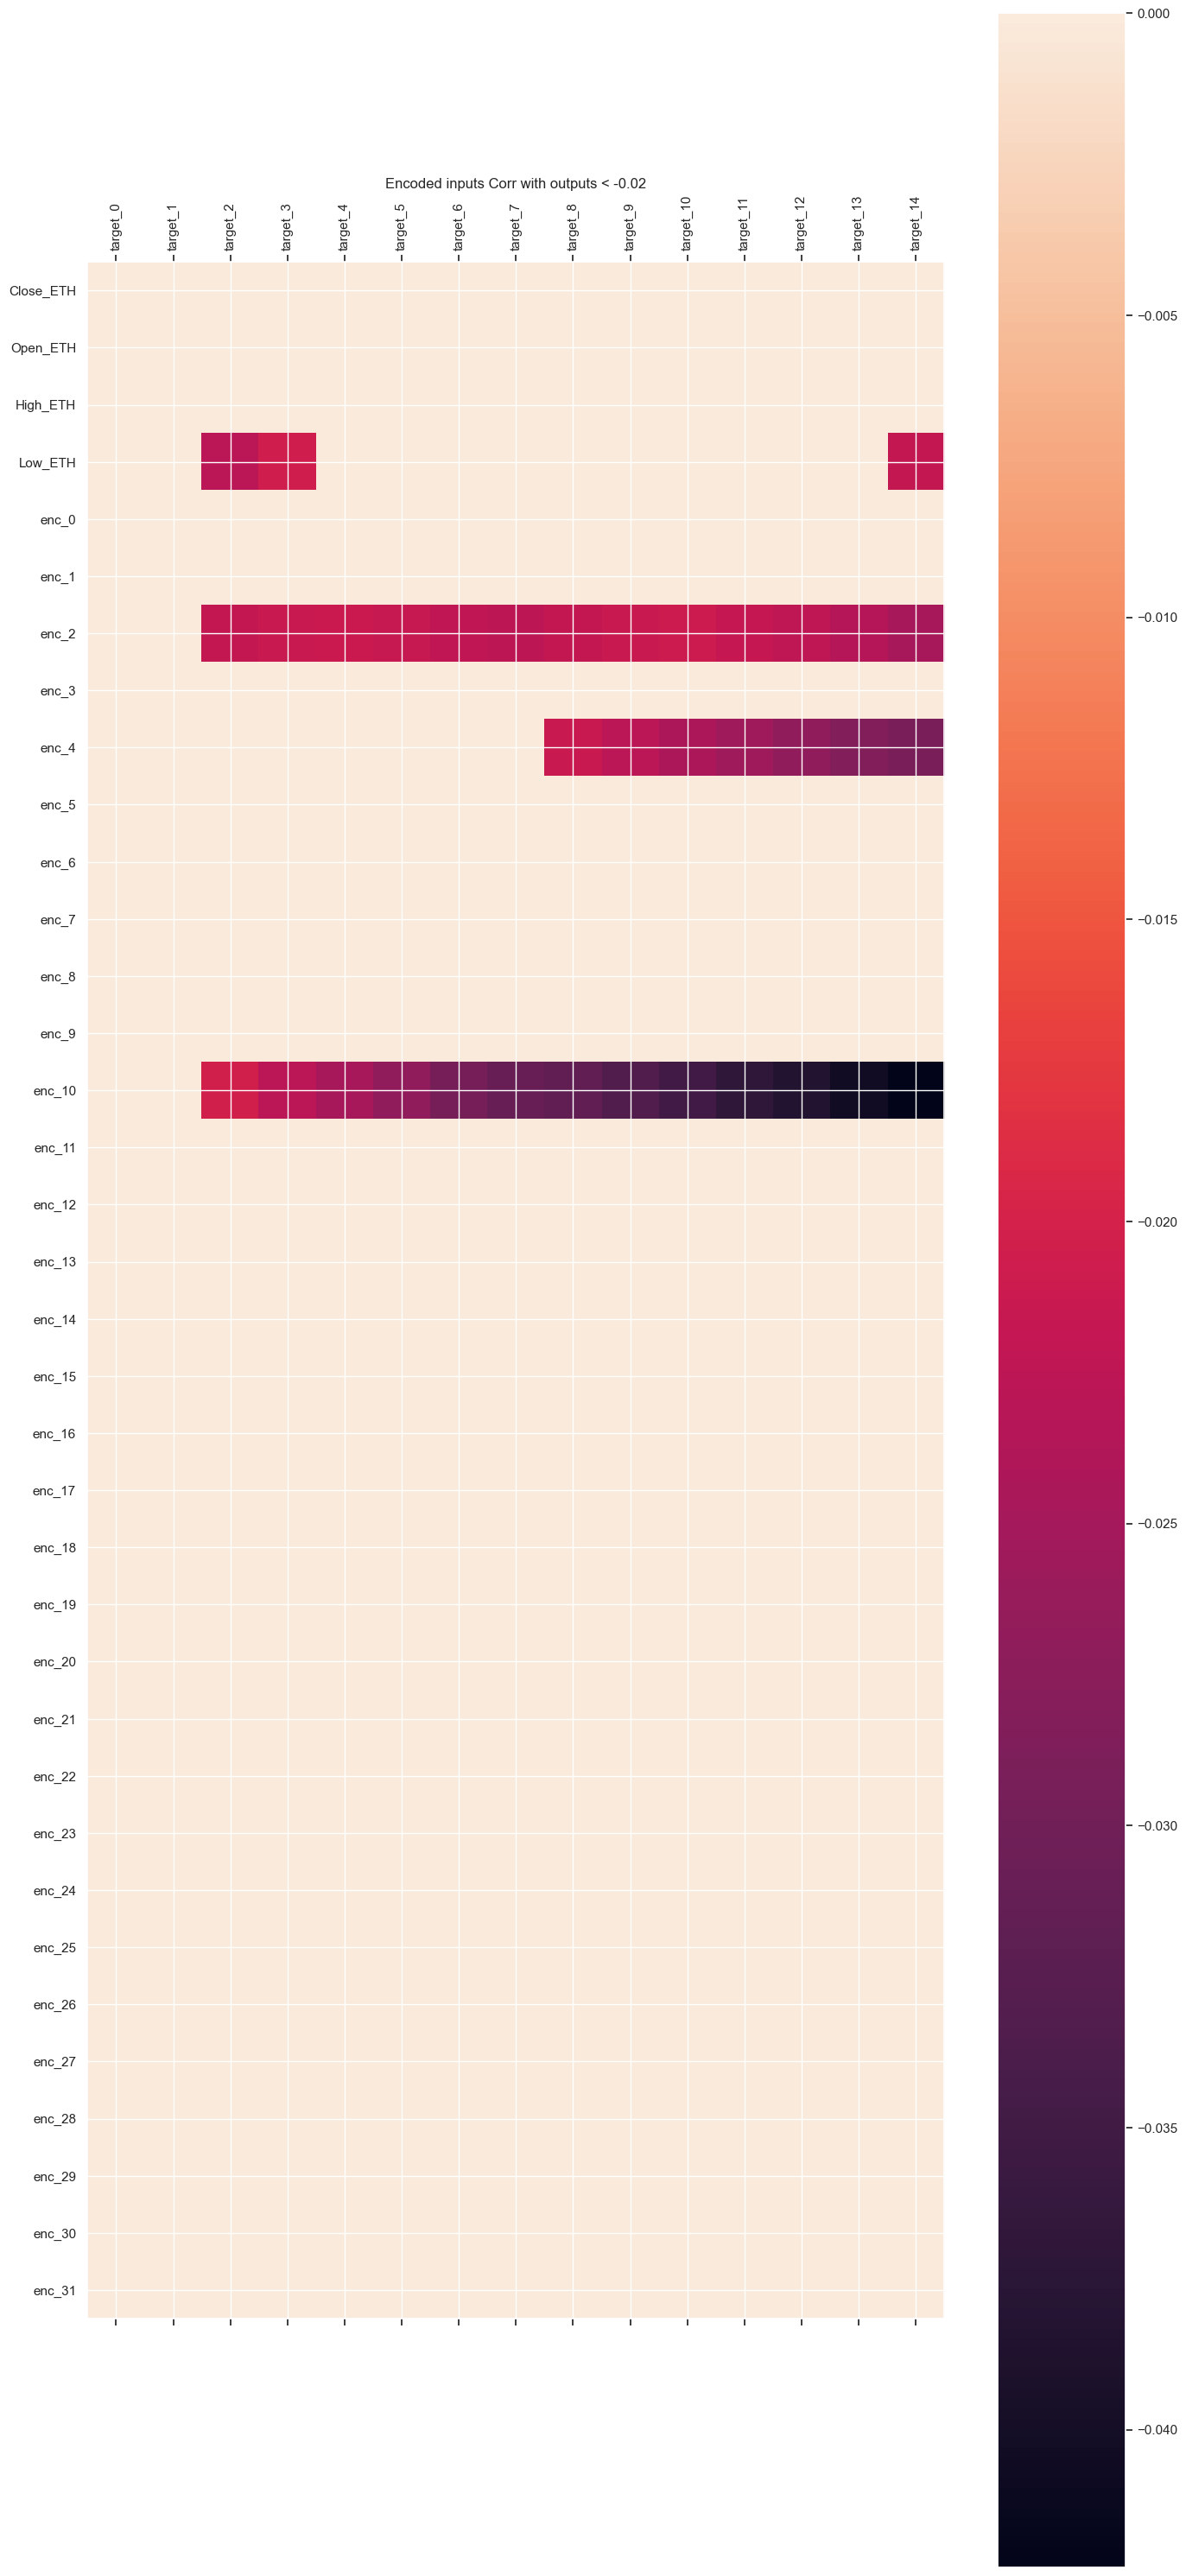

In [143]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [144]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [145]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [146]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [147]:
MODE_AUTO_SELECT

0

In [148]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
nb encoded features:  32


In [149]:
X_train_.shape

(93331, 72, 36)

In [150]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [151]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [152]:
X_train_.shape

(93331, 72, 36)

#### Train

In [153]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)

mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in LIST_UNITS_PRED: #[32, 64, 128]: #[128]: #
        for dropout_rate in  LIST_DROPOUT_PRED: #[0.05, 0.15, 0.25]: #[0.1]:
            for seed in LIST_SEEDS:
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.AdamW()
                if PATIENCE_PRED is not None:
                    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                    verbose=1, patience=PATIENCE_PRED,
                                                    restore_best_weights=True)
                # create model
                multi_step_model = tf.keras.models.Sequential()
                multi_step_model.add(
                    tf.keras.layers.LSTM(
                        n_units,
                        return_sequences=False,
                        input_shape=X_train_.shape[-2:],
                        #kernel_regularizer=reg,
                        #bias_regularizer=reg,
                    )
                )
                multi_step_model.add(tf.keras.layers.LayerNormalization())
                multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
                #multi_step_model.add(tf.keras.layers.BatchNormalization())
                multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
                # compile
                multi_step_model.compile(optimizer=optim, loss='mse')
                # fitting
                if PATIENCE_PRED == 0:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1,
                    )
                else:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1, 
                        callbacks=[es],
                    )
                # eval
                if PATIENCE_PRED !=0:
                    # mode min val loss
                    i_epoch = np.argmin(multi_step_history.history['val_loss'])
                    mse_curr_train = multi_step_history.history['loss'][i_epoch]
                    mse_curr = multi_step_history.history['val_loss'][i_epoch]
                else:
                    # mode last
                    mse_curr_train = multi_step_history.history['loss'][-1]
                    mse_curr = multi_step_history.history['val_loss'][-1]

                print("MSE TRAIN : ", mse_curr_train)
                print("MSE TEST : ", mse_curr)
                    
                # plot MSE
                name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                plot_train_history(
                    multi_step_history,
                    f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                    saveFolder="data",
                )

                # save the best
                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate

                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_units_min = n_units
                        dropout_rate_min = dropout_rate
                        print("Save model: ", path_mdl_predict_autoenc_lstm)
                        multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

    
print("Load model: ", path_mdl_predict_autoenc_lstm)
multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
n_units = multi_step_model.layers[0].units#32
dropout_rate = multi_step_model.layers[2].rate#0.25
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=512 / dropout= 0.5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1124352   
                                                                 
 layer_normalization (Layer  (None, 512)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 15)                7695      
                                                                 
Total params: 1133071 (4.32 MB)
Trainable params: 1133071 (4.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
No

In [154]:
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=512 / dropout= 0.5


In [155]:
np.min(y_train)

0.8990060972444147

In [156]:
np.max(y_train)

1.087790104524251

#### Results

##### Save mdl

In [157]:
X_train_.shape

(93331, 72, 36)

##### Predict

In [158]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

12/12 [==============================] - 0s 22ms/step


##### Plots

In [159]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(93345,)
(93345,)


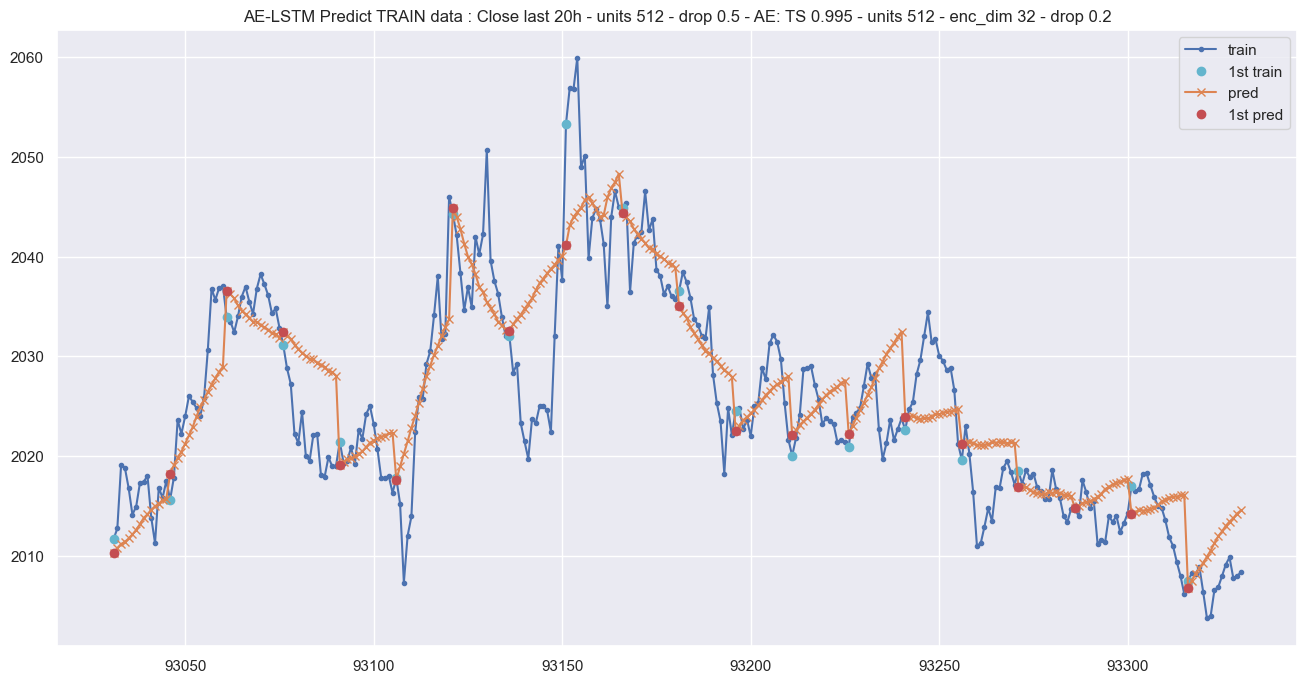

In [160]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

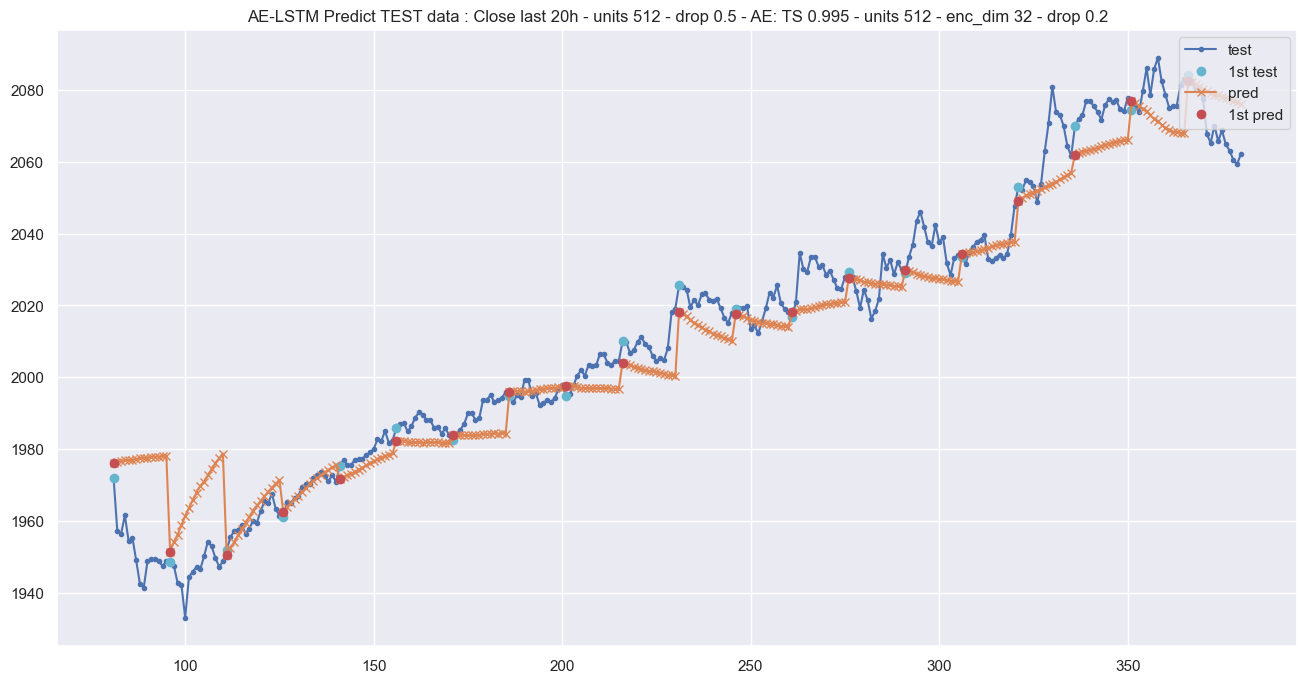

In [161]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

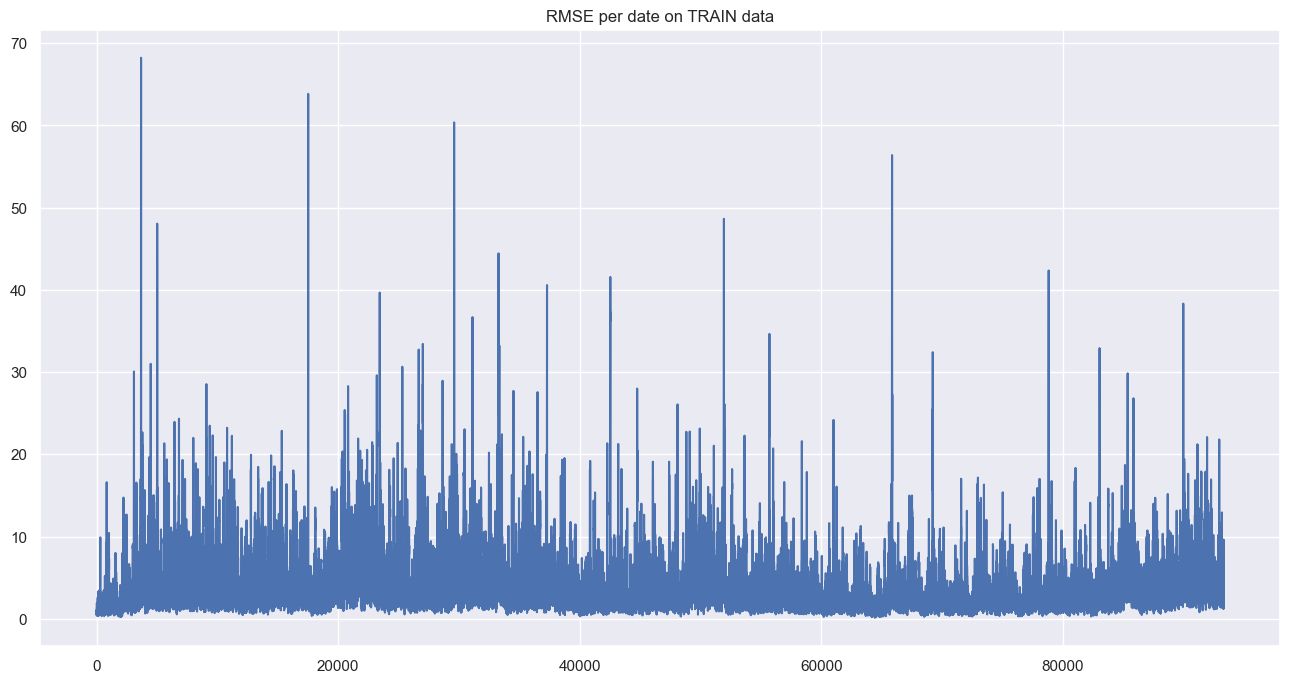

In [162]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

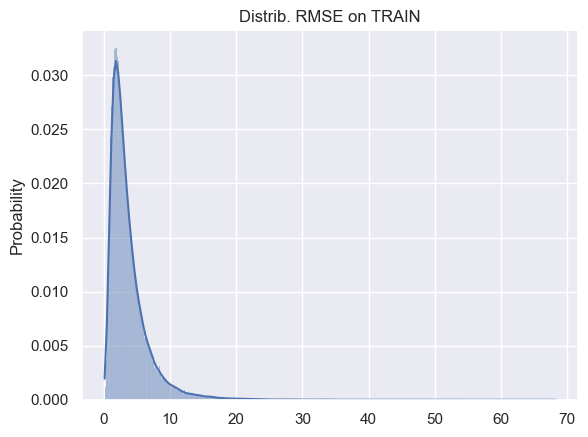

In [163]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 3.75')

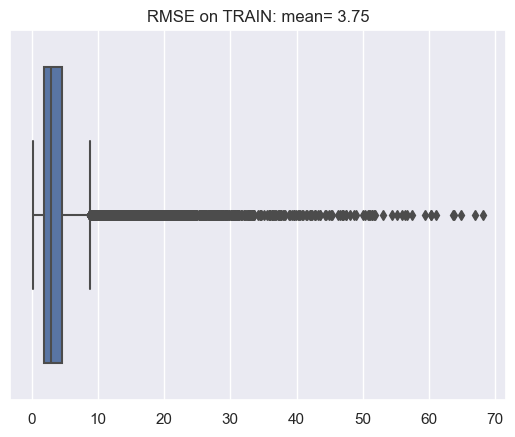

In [164]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

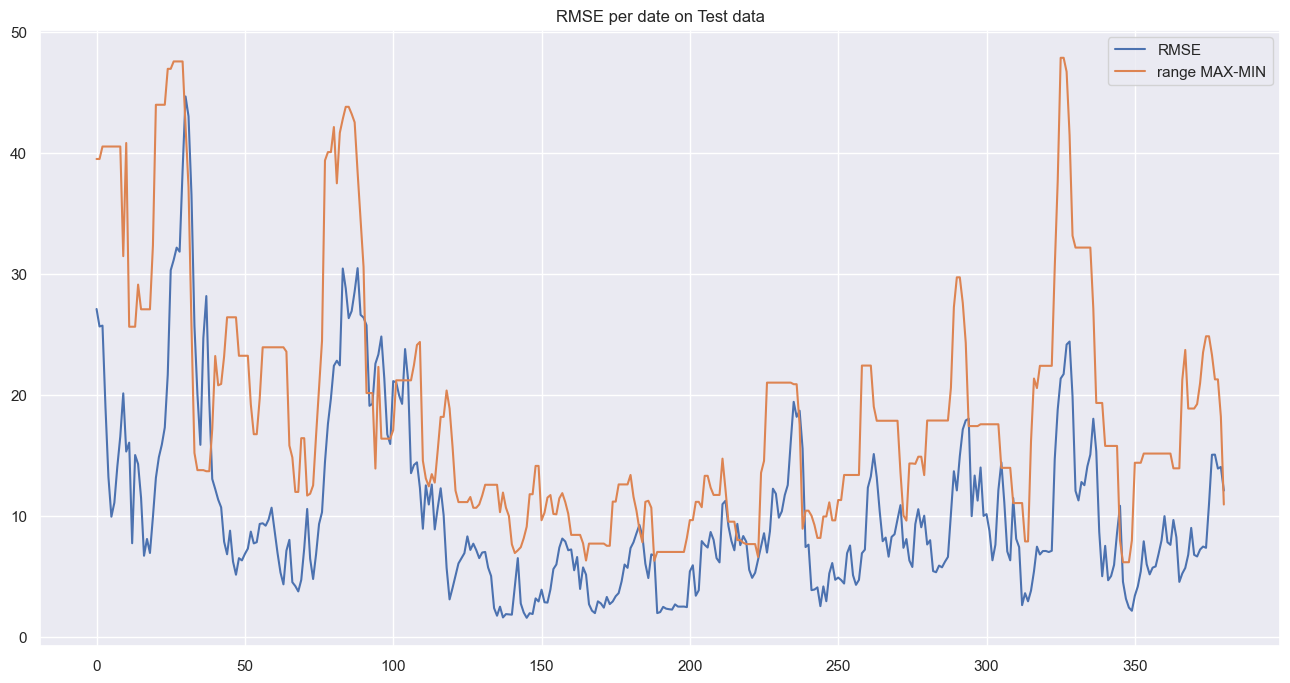

In [165]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [166]:
np.mean(arr_range)

18.662309711286053

<Axes: ylabel='Probability'>

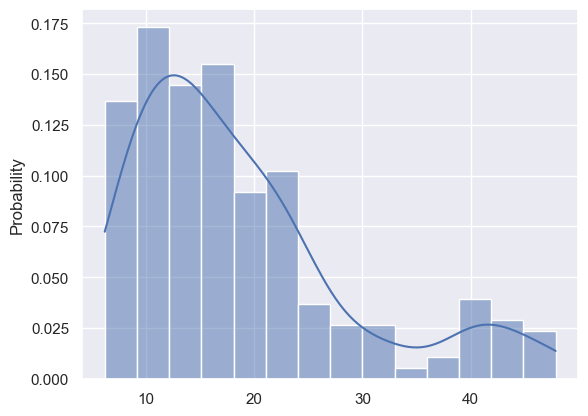

In [167]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [168]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

16.627271054767913

<Axes: ylabel='Probability'>

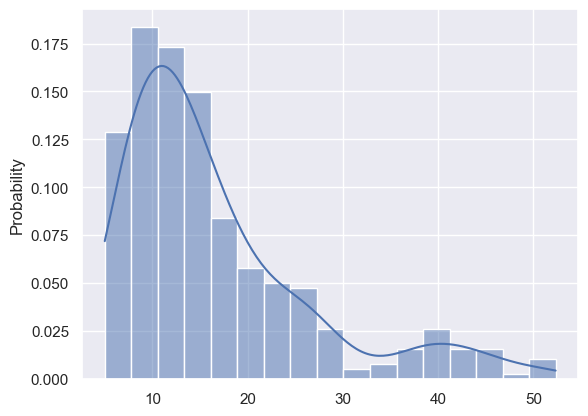

In [169]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

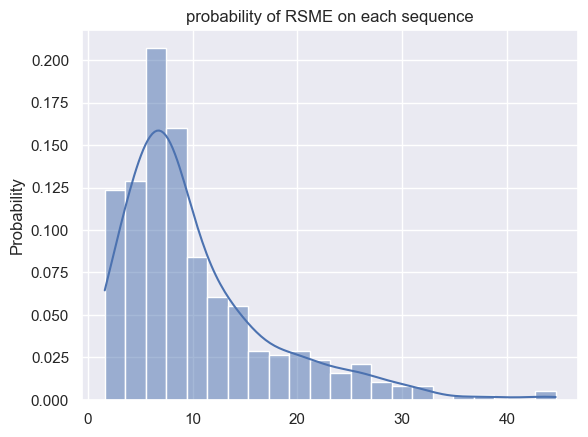

In [170]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 93.31154855643027)

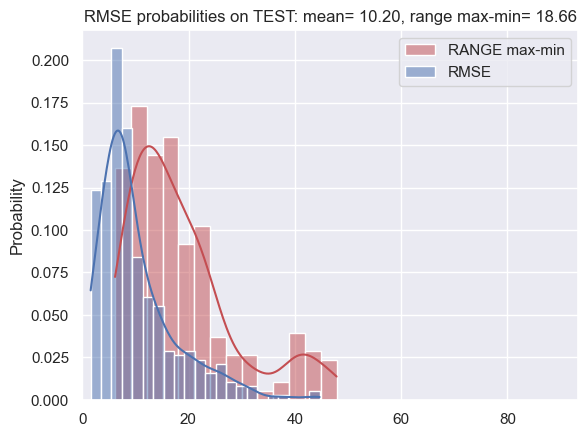

In [171]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 51.01951856212168)

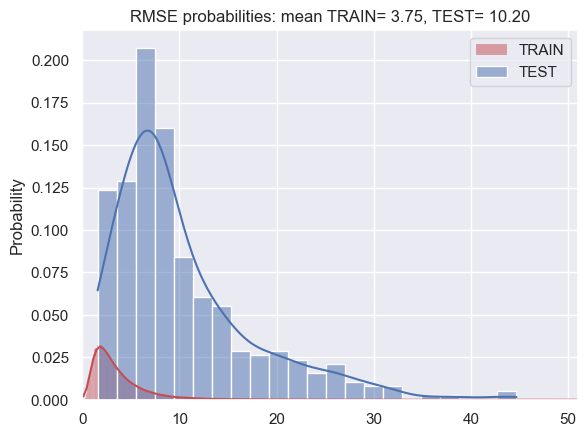

In [172]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 10.20')

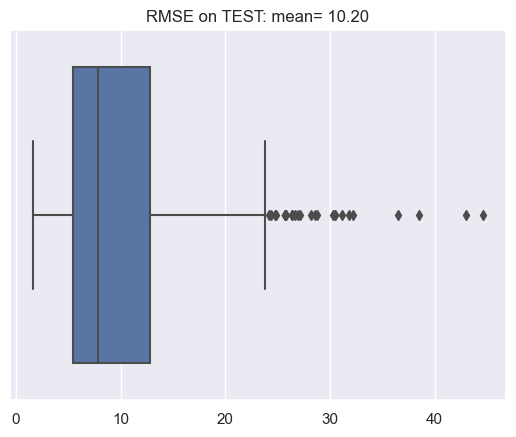

In [173]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [174]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[2080.43 2077.35 2067.69 2065.23 2070.09 2065.69 2068.79 2064.86 2063.13
 2060.59 2059.26 2062.17 2059.14 2060.36 2065.02]
[2079.72204208 2079.61170197 2079.62224007 2079.25848961 2078.99094582
 2078.76667023 2078.71782303 2078.56520653 2078.68112564 2078.59942436
 2078.50309372 2078.35159302 2078.05355072 2077.95461655 2077.60971069]


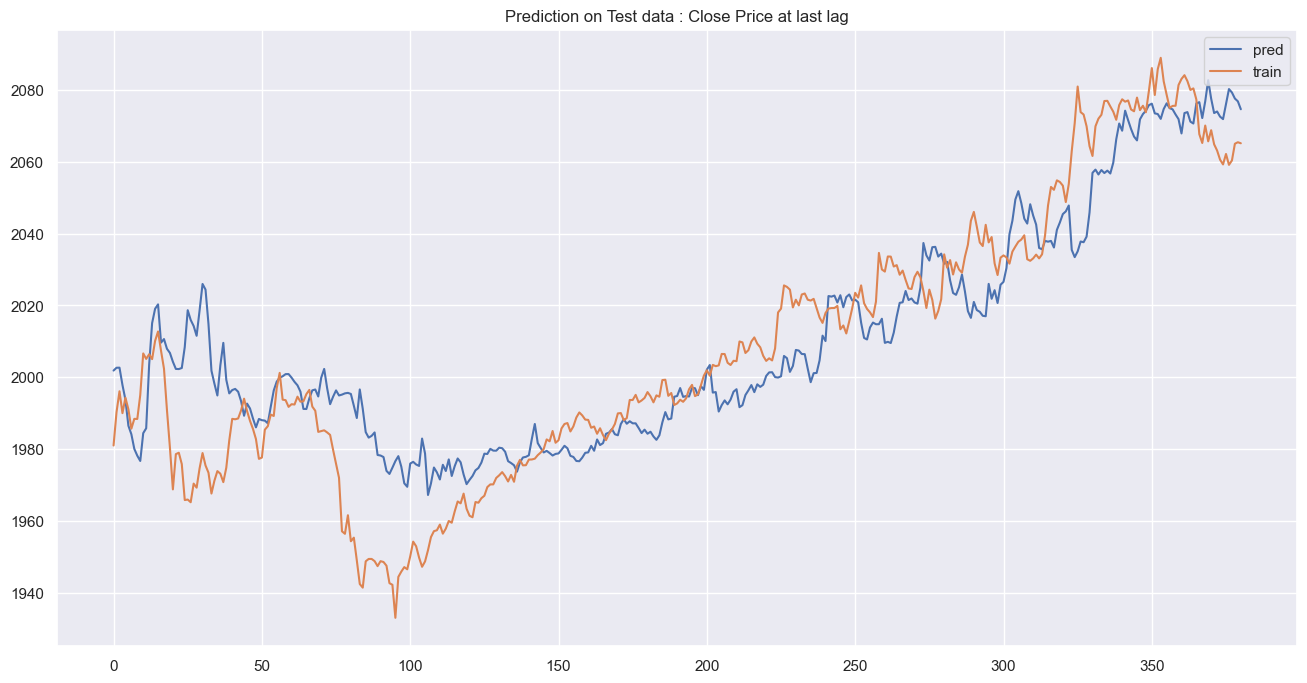

In [175]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

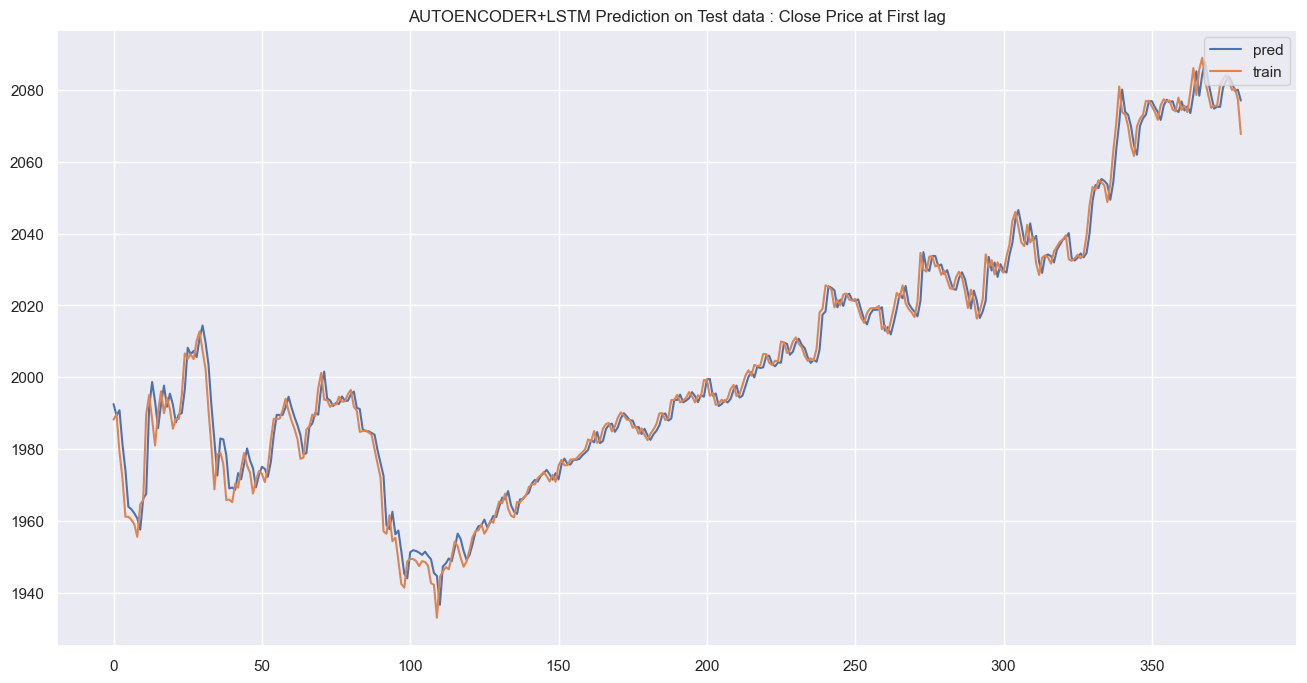

In [176]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

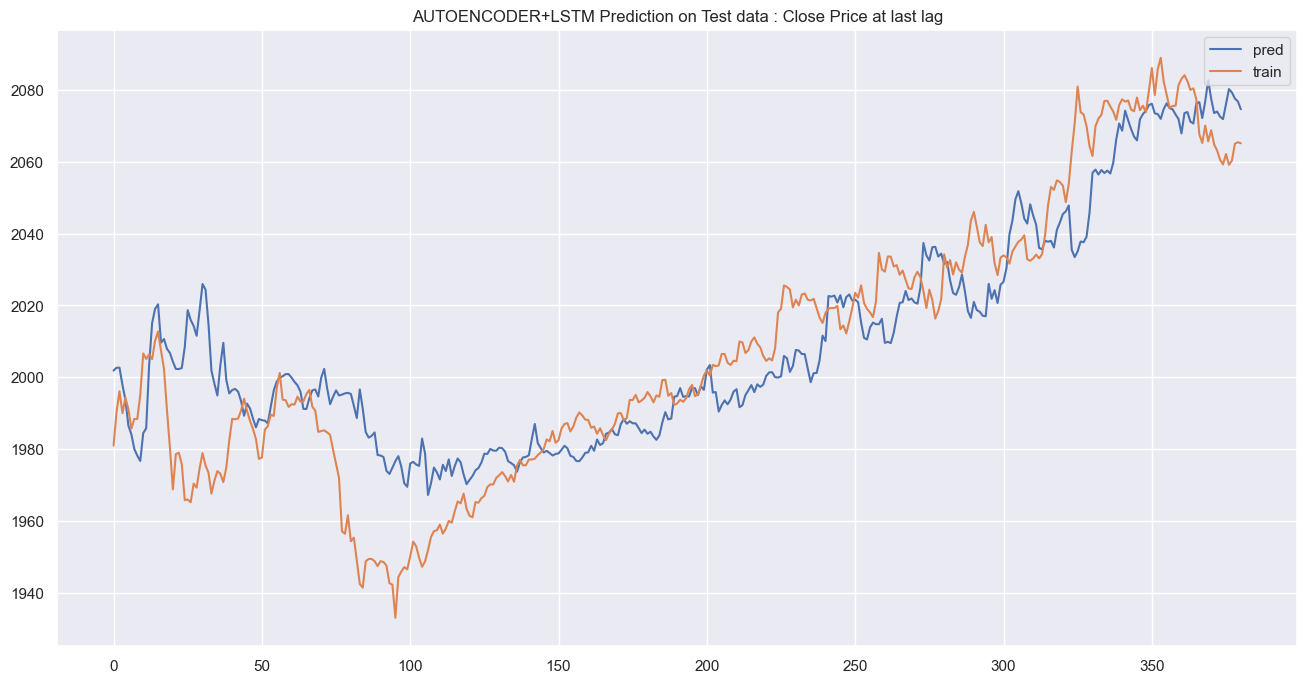

In [177]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [178]:
X_test_sca.shape

(381, 72, 102)

In [179]:
df_feat["Close_ETH"].iloc[-1]

2064.89

In [180]:
df_feat["Close_ETH"].iloc[-1]

2064.89

In [181]:
len(list_i_enc_select)

32

In [182]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[2033.1  2034.15 2033.09 2034.24 2039.48 2047.79 2052.99 2052.19 2054.83
 2054.37 2053.35 2048.77 2053.8  2062.96 2070.74 2080.95 2073.82 2073.16
 2069.89 2064.34 2061.61 2069.89 2072.   2073.08 2076.92 2076.97 2075.42
 2073.95 2071.69 2075.79 2077.4  2076.73 2077.07 2074.56 2074.06 2077.87
 2074.39 2075.6  2073.79 2079.67 2086.09 2078.6  2085.79 2088.95 2082.4
 2078.63 2075.01 2075.55 2075.6  2081.37 2083.07 2084.11 2082.45 2080.
 2080.43 2077.35 2067.69 2065.23 2070.09 2065.69 2068.79 2064.86 2063.13
 2060.59 2059.26 2062.17 2059.14 2060.36 2065.02 2065.44 2065.15 2064.89]
X_last[0,:,0] after divide by price:
[0.98460451 0.98511301 0.98459966 0.98515659 0.98769426 0.99171869
 0.99423698 0.99384955 0.99512807 0.9949053  0.99441132 0.99219329
 0.99462925 0.99906533 1.00283308 1.00777765 1.00432469 1.00400506
 1.00242144 0.99973364 0.99841154 1.00242144 1.00344328 1.00396631
 1.00582598 1.00585019 1.00509955 1.00438764 1.00329315 1.00527873
 1.0060

In [183]:
X_last_encoded_sca.shape

(1, 72, 32)

In [184]:
list_i_enc_select

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [185]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 32)

In [186]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [187]:
X_train_.shape

(93331, 72, 36)

In [188]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
93881  1700695500000   2059.15   2061.46  2058.47    2060.36   1431.2804   
93882  1700695800000   2060.35   2066.30  2059.19    2065.02   1306.2176   
93883  1700696100000   2065.01   2065.87  2064.16    2065.44    768.8257   
93884  1700696400000   2065.44   2066.58  2065.15    2065.15    533.2508   
93885  1700696700000   2065.16   2067.69  2064.62    2064.89    693.2496   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1742.347452       1741.894136   
1      2023-01-01 00:05:00       1742.347452       1741.894136   
2      2023-01-01 00:10:00       1742.347452       1741.894136   
3      2023-01-01 00:15:00       1742.347452       1741.894136   
4      2023-01-01 00:20:00       1742.347452       1741.894136   
...                    ...               ...               ...   
93881  2023-11-22 23:25:00       2076.605000       2059.135000   
93882  2023-11-22 23:30:00       2076.605000       2059.135000   
93883  2023-11-22 23:35:00       2078.370000       2060.900000   
93884  2023-11-22 23:40:00       2078.600000       2061.130000   
93885  2023-11-22 23:45:00       2078.600000       2061.870000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
93881         2075.23  ...         NaN            NaN           NaN   
93882         2075.23  ...         NaN            NaN           NaN   
93883         2075.23  ...         NaN            NaN           NaN   
93884         2072.68  ...         NaN            NaN           NaN   
93885         2072.68  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
93881               NaN         0.0               NaN         0.0      0.0   
93882               NaN         0.0               NaN         0.0      0.0   
93883               NaN         0.0               NaN         0.0      0.0   
93884               NaN         0.0               NaN         0.0      0.0   
93885               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
93881                  NaN  False  
93882                  NaN  False  
93883                  NaN  False  
93884                  NaN  False  
93885                  NaN  False  

[93886 rows x 136 columns]

In [189]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [190]:
y_last_pred_unscaled

array([[0.9997914 , 0.9996704 , 0.99960685, 0.99934745, 0.9991717 ,
        0.99899596, 0.9988936 , 0.9987644 , 0.9987659 , 0.9986603 ,
        0.9985612 , 0.99842846, 0.9982554 , 0.9981782 , 0.99799323]],
      dtype=float32)

In [191]:
df_feat["Close_ETH"].iloc[-1]

2064.89

In [192]:
y_last_pred_raw

array([[2064.4592, 2064.2092, 2064.0781, 2063.5425, 2063.1794, 2062.8167,
        2062.6052, 2062.3386, 2062.3416, 2062.1235, 2061.919 , 2061.6448,
        2061.2874, 2061.128 , 2060.746 ]], dtype=float32)

In [193]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [194]:
list_pred

[2063.5425,
 2063.1794,
 2062.8167,
 2062.6052,
 2062.3386,
 2062.3416,
 2062.1235,
 2061.919,
 2061.6448,
 2061.2874,
 2061.128,
 2060.746]

In [195]:
save_list(list_pred, path_save_pred_vals)

In [196]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [197]:
list_pred_reload

[2063.5425,
 2063.1794,
 2062.8167,
 2062.6052,
 2062.3386,
 2062.3416,
 2062.1235,
 2061.919,
 2061.6448,
 2061.2874,
 2061.128,
 2060.746]